In [474]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy import stats

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
)

In [475]:
teams = ["dire", "radiant"]
positions = ["1", "2", "3", "4", "5"]
times = [5, 10, 15, 20]
analysis_time = 20
hero_limit = 40

# statistic columns
player_stats_params = [
    "networth",
    "xpm",
    "kills",
    "hero_damage",
    "tower_damage",
    "camps_stacked",
    "actions"
]
game_stats_params = ["towers_lost"]
player_stats_key = "position_{pos}_{param}_{time}"
player_hero_key = "position_{pos}_hero"

In [476]:
def load_data(
    time: int,
    hero_count: int,
    include_result: bool = False,
    include_heroes: bool = False,
    player_params: list = player_stats_params,
):
    """
    Load data from csv file and return a dataframe
    """
    if time not in times:
        raise ValueError("time must be one of 5, 10, 15, 20")


    df = pd.read_csv("../data/parsed_data.csv")

    # filter heroes
    hero_cols = []
    for team in teams:
        for pos in positions:
            hero_cols.append(f"{team}_position_{pos}_hero")

    # limit number of heroes across all positions
    filtered_df = df
    for col in hero_cols:
        filter_keys = filtered_df[col].value_counts()[:hero_count].keys()
        filtered_df = filtered_df.loc[filtered_df[col].isin(filter_keys)]

    radiant_columns = {}
    dire_columns = {}
    stats_columns = []

    # player stats columns
    for pos in positions:
        for param in player_params:
            col_name = player_stats_key.format(pos=pos, param=param, time=time)
            radiant_col_name = f"radiant_{col_name}"
            dire_col_name = f"dire_{col_name}"
            radiant_columns[radiant_col_name] = col_name
            dire_columns[dire_col_name] = col_name
            stats_columns.append(col_name)

        if include_heroes:
            col_name = player_hero_key.format(pos=pos)
            radiant_col_name = f"radiant_{col_name}"
            dire_col_name = f"dire_{col_name}"
            radiant_columns[radiant_col_name] = col_name
            dire_columns[dire_col_name] = col_name
            stats_columns.append(col_name)

    # game stats columns
    col_name = f"towers_lost_{time}"
    radiant_col_name = f"radiant_{col_name}"
    dire_col_name = f"dire_{col_name}"
    radiant_columns[radiant_col_name] = col_name
    dire_columns[dire_col_name] = col_name
    stats_columns.append(col_name)

    # include heroes
    if include_heroes:
        for col in hero_cols:
            df[col] = df[col].astype("category")

    # split the data into two halves randomly
    winner_data = filtered_df.sample(frac=0.5, random_state=0)
    loser_data = filtered_df.drop(winner_data.index)

    # rename columns and drop opponent data
    radiant_winner = winner_data[winner_data["winner"] == "radiant"]
    radiant_winner = radiant_winner[radiant_columns.keys()]
    radiant_winner = radiant_winner.rename(columns=radiant_columns)

    dire_winner = winner_data[winner_data["winner"] == "dire"]
    dire_winner = dire_winner[dire_columns.keys()]
    dire_winner = dire_winner.rename(columns=dire_columns)

    winner_data = pd.concat([radiant_winner, dire_winner], axis=0)
    winner_data = winner_data.dropna(subset=stats_columns)

    radiant_loser = loser_data[loser_data["winner"] == "dire"]
    radiant_loser = radiant_loser[radiant_columns.keys()]
    radiant_loser = radiant_loser.rename(columns=radiant_columns)

    dire_loser = loser_data[loser_data["winner"] == "radiant"]
    dire_loser = dire_loser[dire_columns.keys()]
    dire_loser = dire_loser.rename(columns=dire_columns)

    loser_data = pd.concat([radiant_loser, dire_loser], axis=0)
    loser_data = loser_data.dropna(subset=stats_columns)

    # remove outliers
    winner_data = winner_data[stats_columns]
    loser_data = loser_data[stats_columns]
    winner_data = winner_data[
        (np.abs(stats.zscore(winner_data)) < 3).all(axis=1)
    ]
    loser_data = loser_data[(np.abs(stats.zscore(loser_data)) < 3).all(axis=1)]

    # remove data if more than 6 towers lost
    winner_data = winner_data[winner_data[f"towers_lost_{time}"] <= 6]
    loser_data = loser_data[loser_data[f"towers_lost_{time}"] <= 6]
    print(winner_data.shape, loser_data.shape)

    if include_result:
        winner_data["result"] = 1
        loser_data["result"] = 0

    return winner_data, loser_data

### Basic statistics

In [477]:
# load data
winner_data, loser_data = load_data(time=analysis_time, hero_count=hero_limit)

# statistics of the winner
print(winner_data.describe(include="all"))

(1239, 36) (1192, 36)
       position_1_networth_20  position_1_xpm_20  position_1_kills_20  \
count             1239.000000        1239.000000          1239.000000   
mean             10043.864407         588.161380             4.019370   
std               1439.730562          95.219636             2.550861   
min               5915.000000         335.650000             0.000000   
25%               9047.000000         523.050000             2.000000   
50%              10005.000000         583.800000             4.000000   
75%              10959.500000         646.425000             6.000000   
max              14699.000000         876.100000            12.000000   

       position_1_hero_damage_20  position_1_tower_damage_20  \
count                1239.000000                 1239.000000   
mean                 7624.870864                  688.887813   
std                  3210.833784                  933.324723   
min                   202.000000                    0.000000   


In [478]:
# statistics of the loser
print(loser_data.describe(include="all"))

       position_1_networth_20  position_1_xpm_20  position_1_kills_20  \
count             1192.000000        1192.000000          1192.000000   
mean              8937.149329         526.322148             2.868289   
std               1384.241513          91.822162             2.058816   
min               5185.000000         280.500000             0.000000   
25%               8001.000000         462.712500             1.000000   
50%               8881.500000         519.500000             3.000000   
75%               9880.250000         583.512500             4.000000   
max              13262.000000         821.400000             9.000000   

       position_1_hero_damage_20  position_1_tower_damage_20  \
count                1192.000000                 1192.000000   
mean                 6448.451342                  277.172819   
std                  2782.208494                  427.004632   
min                   790.000000                    0.000000   
25%                  4

**Skewness**
- Zero: symmetric, normal distribution
- Positive: right skewed
- Negative: left skewed

**Kurtosis**
- Zero: thin tails, normal distribution
- Positive: fat tails, sharp peak
- Negative: thin tails, flat peak

In [479]:
# skewness and kurtosis of winner
skewness = winner_data.skew().rename("skewness")
kurtosis = winner_data.kurt().rename("kurtosis")
winner_skew_kurt = pd.concat([skewness, kurtosis], axis=1)
print(winner_skew_kurt)

                             skewness  kurtosis
position_1_networth_20       0.235299  0.109260
position_1_xpm_20            0.320999  0.008843
position_1_kills_20          0.613875  0.118491
position_1_hero_damage_20    0.387040 -0.162988
position_1_tower_damage_20   2.107424  5.451391
position_1_camps_stacked_20  1.338576  1.196892
position_1_actions_20        0.132663 -0.793777
position_2_networth_20       0.132442 -0.122698
position_2_xpm_20            0.365092  0.002778
position_2_kills_20          0.465277 -0.149820
position_2_hero_damage_20    0.446765  0.187258
position_2_tower_damage_20   2.499188  6.959297
position_2_camps_stacked_20  2.135118  4.534154
position_2_actions_20        0.077271 -0.877267
position_3_networth_20       0.095243  0.045989
position_3_xpm_20            0.282251 -0.099139
position_3_kills_20          0.524259 -0.158895
position_3_hero_damage_20    0.366489 -0.124200
position_3_tower_damage_20   1.914987  3.813637
position_3_camps_stacked_20  1.859822  3

In [480]:
# skewness and kurtosis of loser
skewness = loser_data.skew().rename("skewness")
kurtosis = loser_data.kurt().rename("kurtosis")
loser_skew_kurt = pd.concat([skewness, kurtosis], axis=1)
print(loser_skew_kurt)

                             skewness   kurtosis
position_1_networth_20       0.157616  -0.193194
position_1_xpm_20            0.322797   0.023758
position_1_kills_20          0.653855  -0.074229
position_1_hero_damage_20    0.414216  -0.332046
position_1_tower_damage_20   1.835095   2.933753
position_1_camps_stacked_20  1.297742   1.154950
position_1_actions_20        0.081984  -0.891298
position_2_networth_20       0.182637   0.085569
position_2_xpm_20            0.327496   0.188616
position_2_kills_20          0.693741   0.189932
position_2_hero_damage_20    0.455549  -0.010944
position_2_tower_damage_20   1.995362   4.198663
position_2_camps_stacked_20  2.094937   4.673546
position_2_actions_20        0.079872  -0.884454
position_3_networth_20       0.137253  -0.124898
position_3_xpm_20            0.147106   0.020640
position_3_kills_20          0.802323   0.293681
position_3_hero_damage_20    0.430536  -0.064915
position_3_tower_damage_20   1.916956   3.992400
position_3_camps_sta

### Distributions

(1239, 36) (1192, 36)


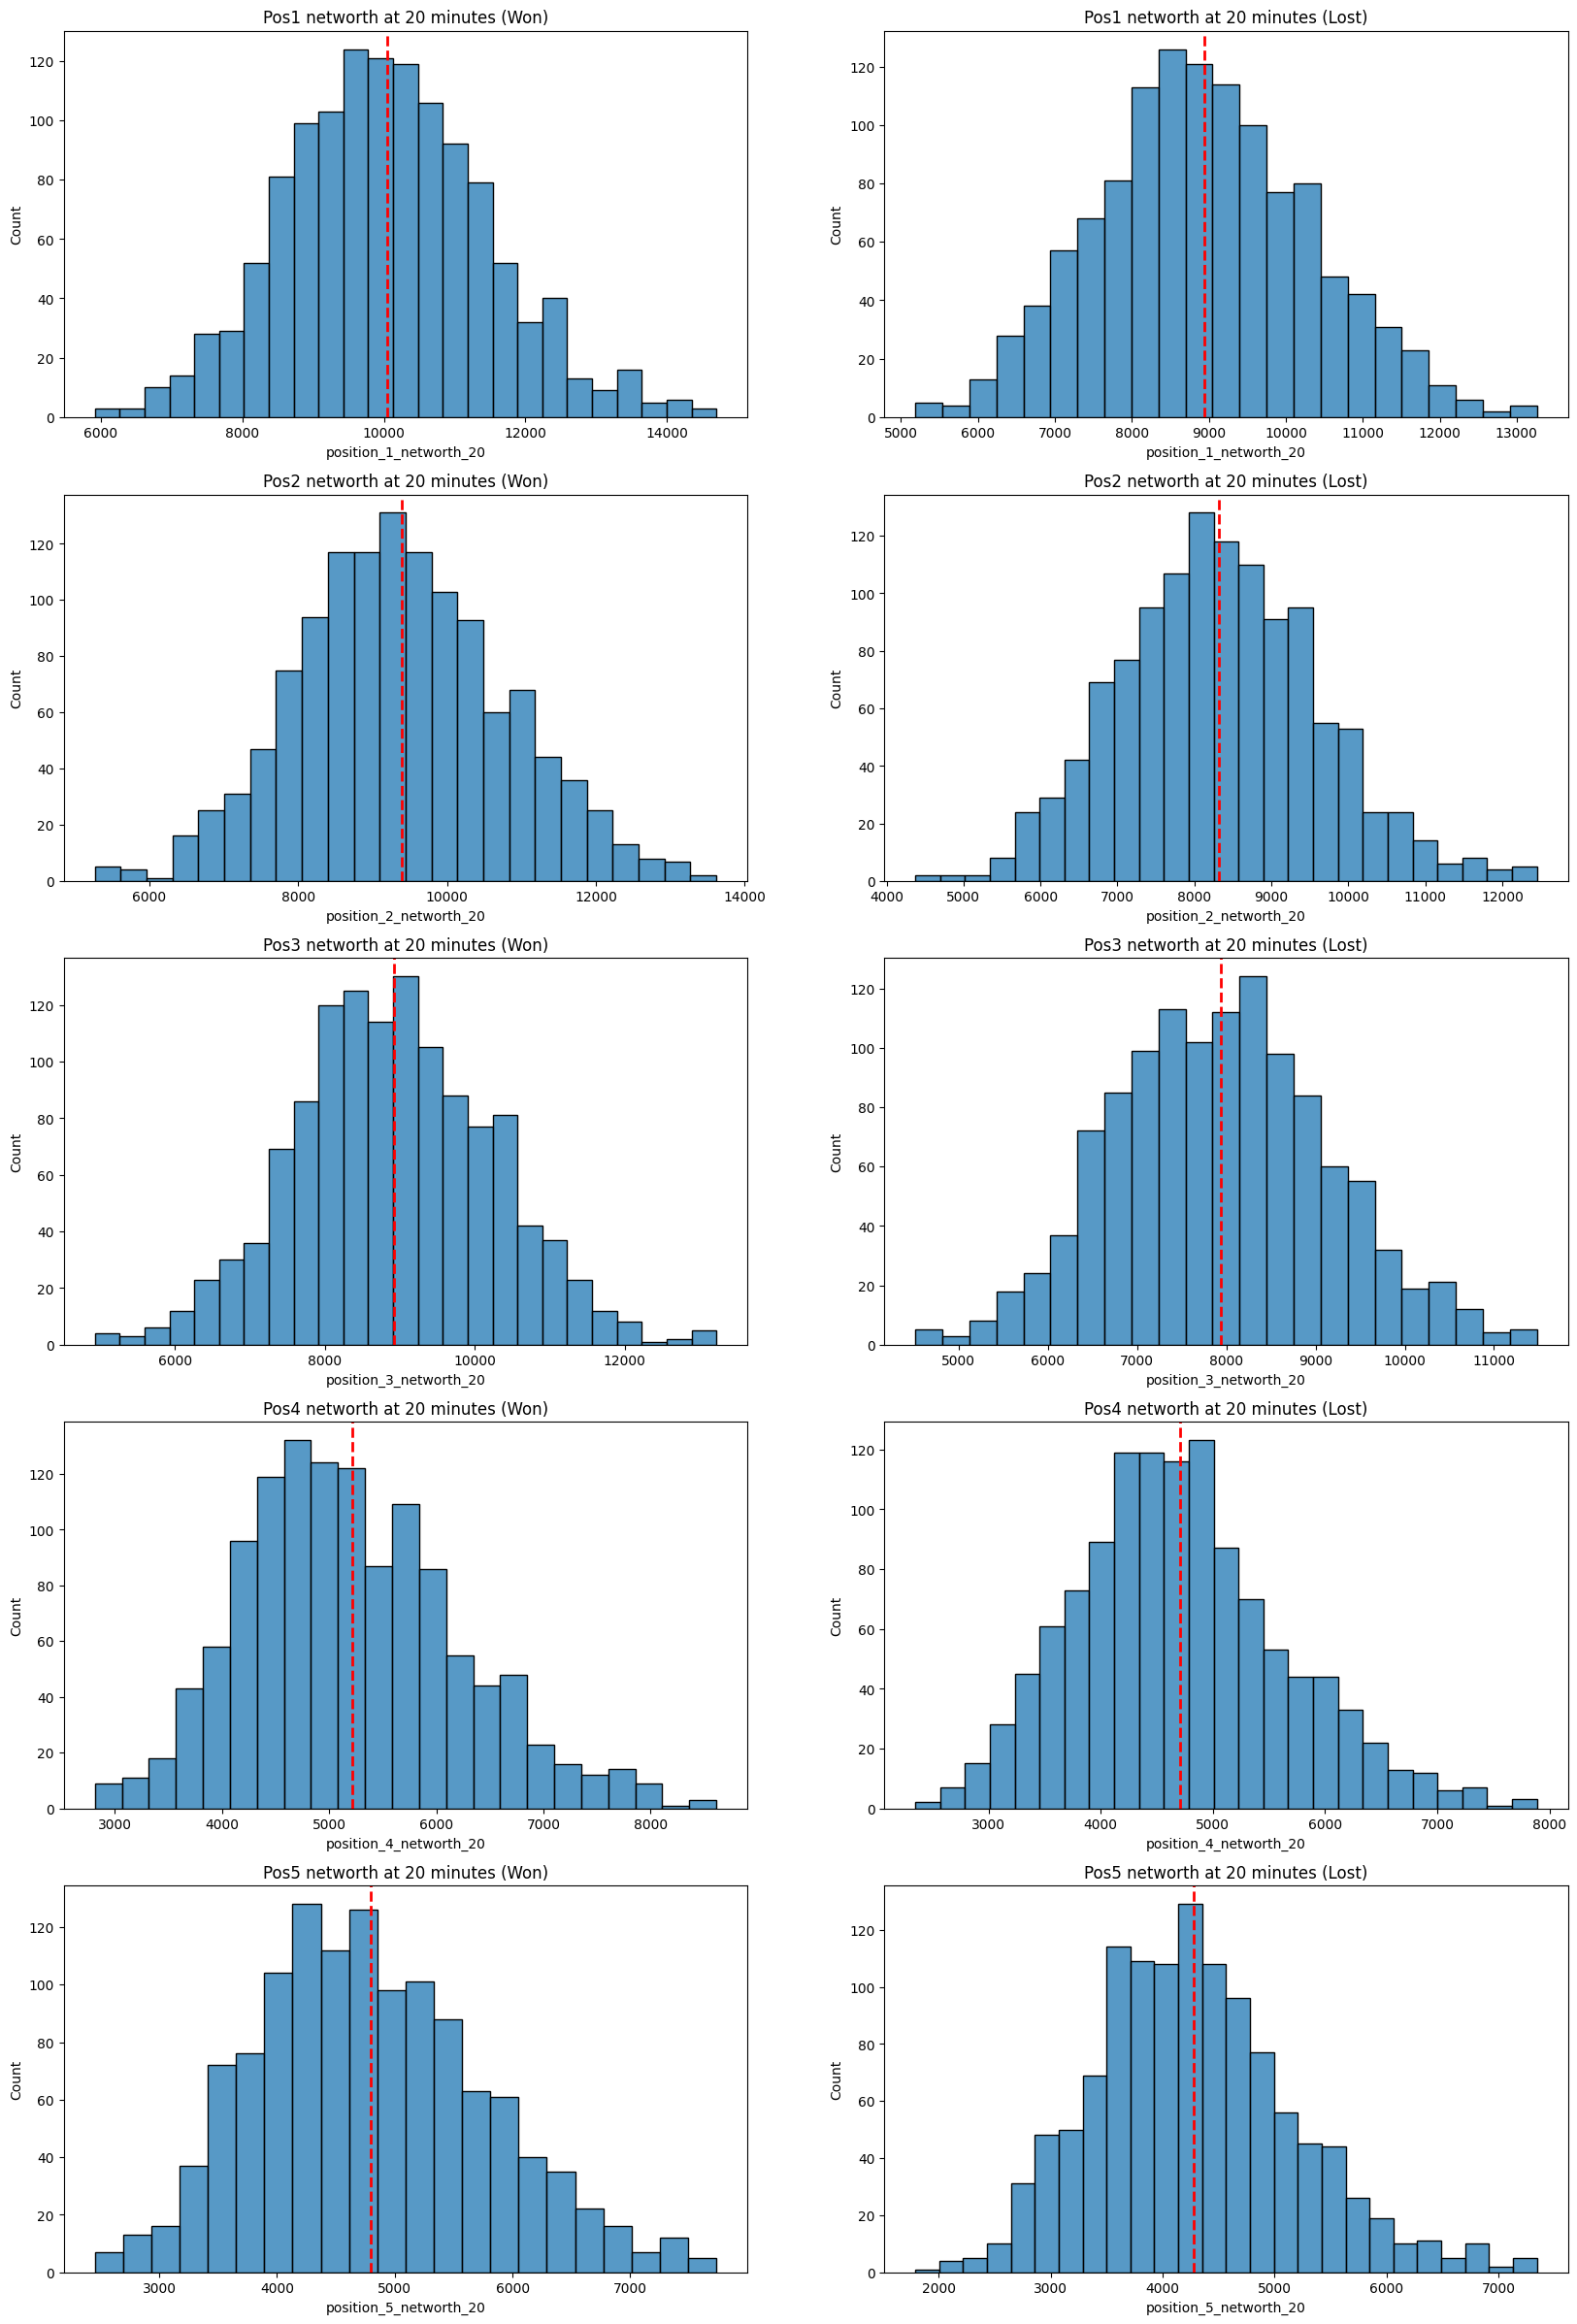

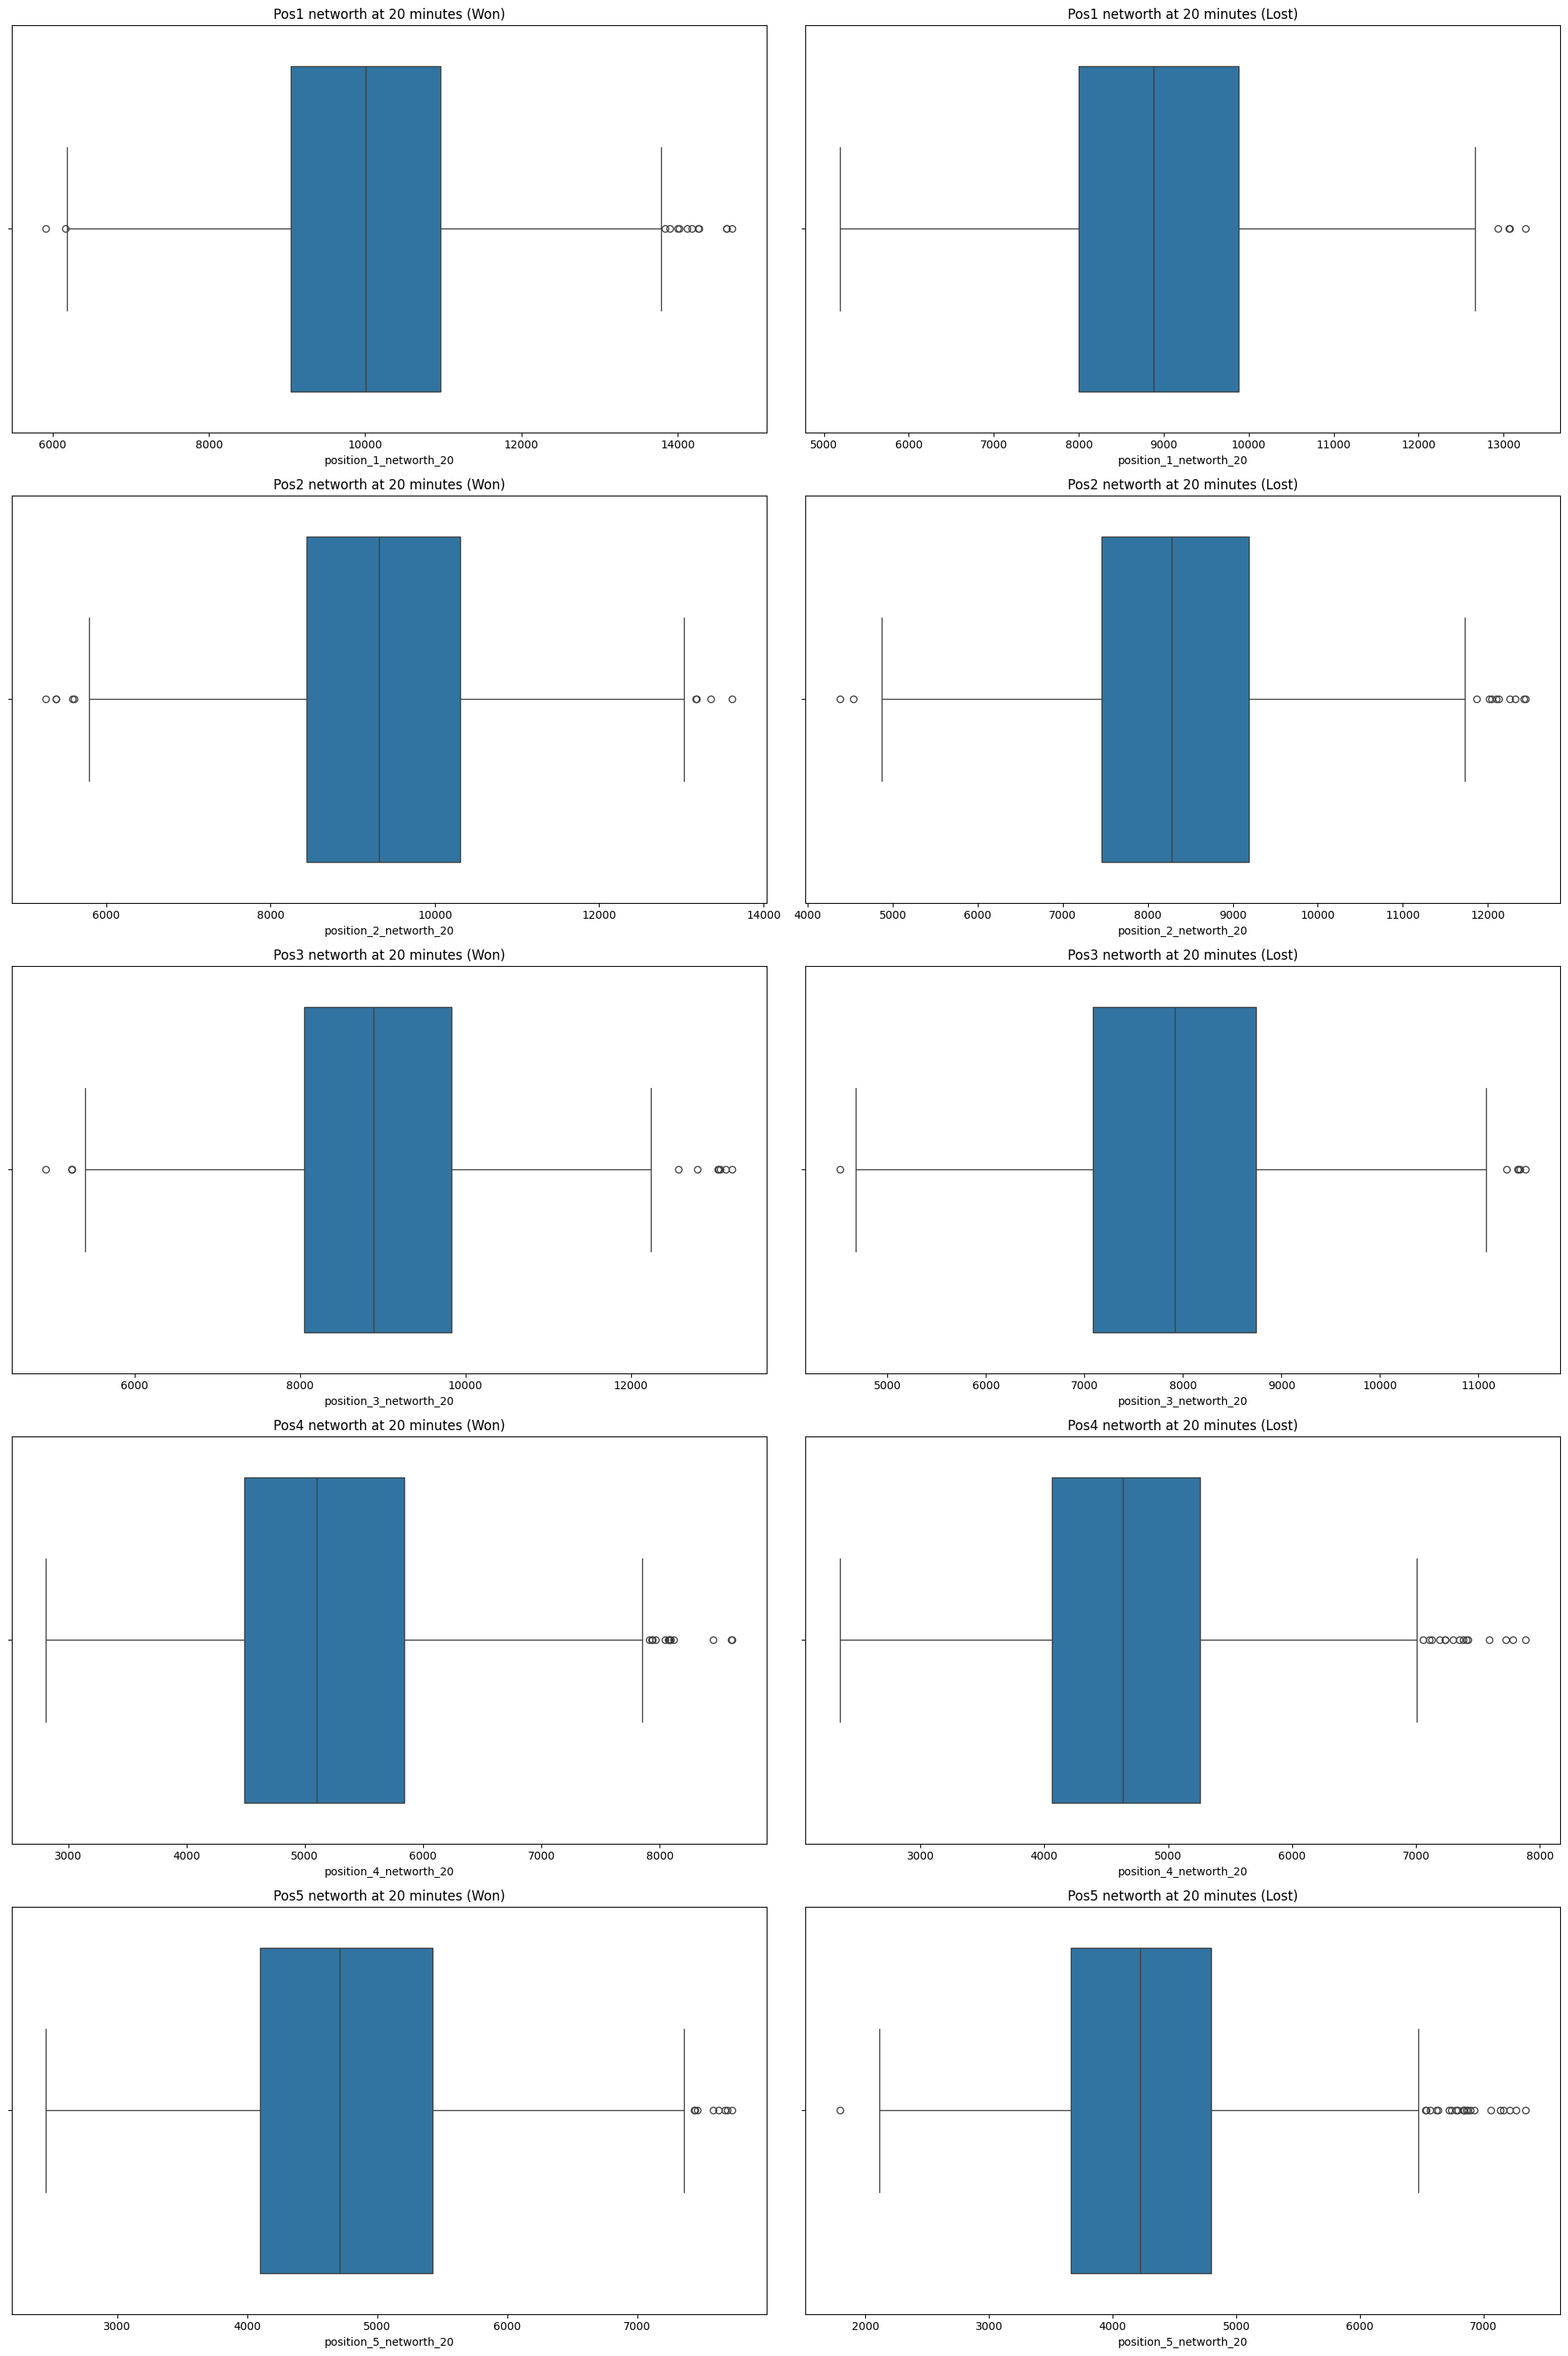

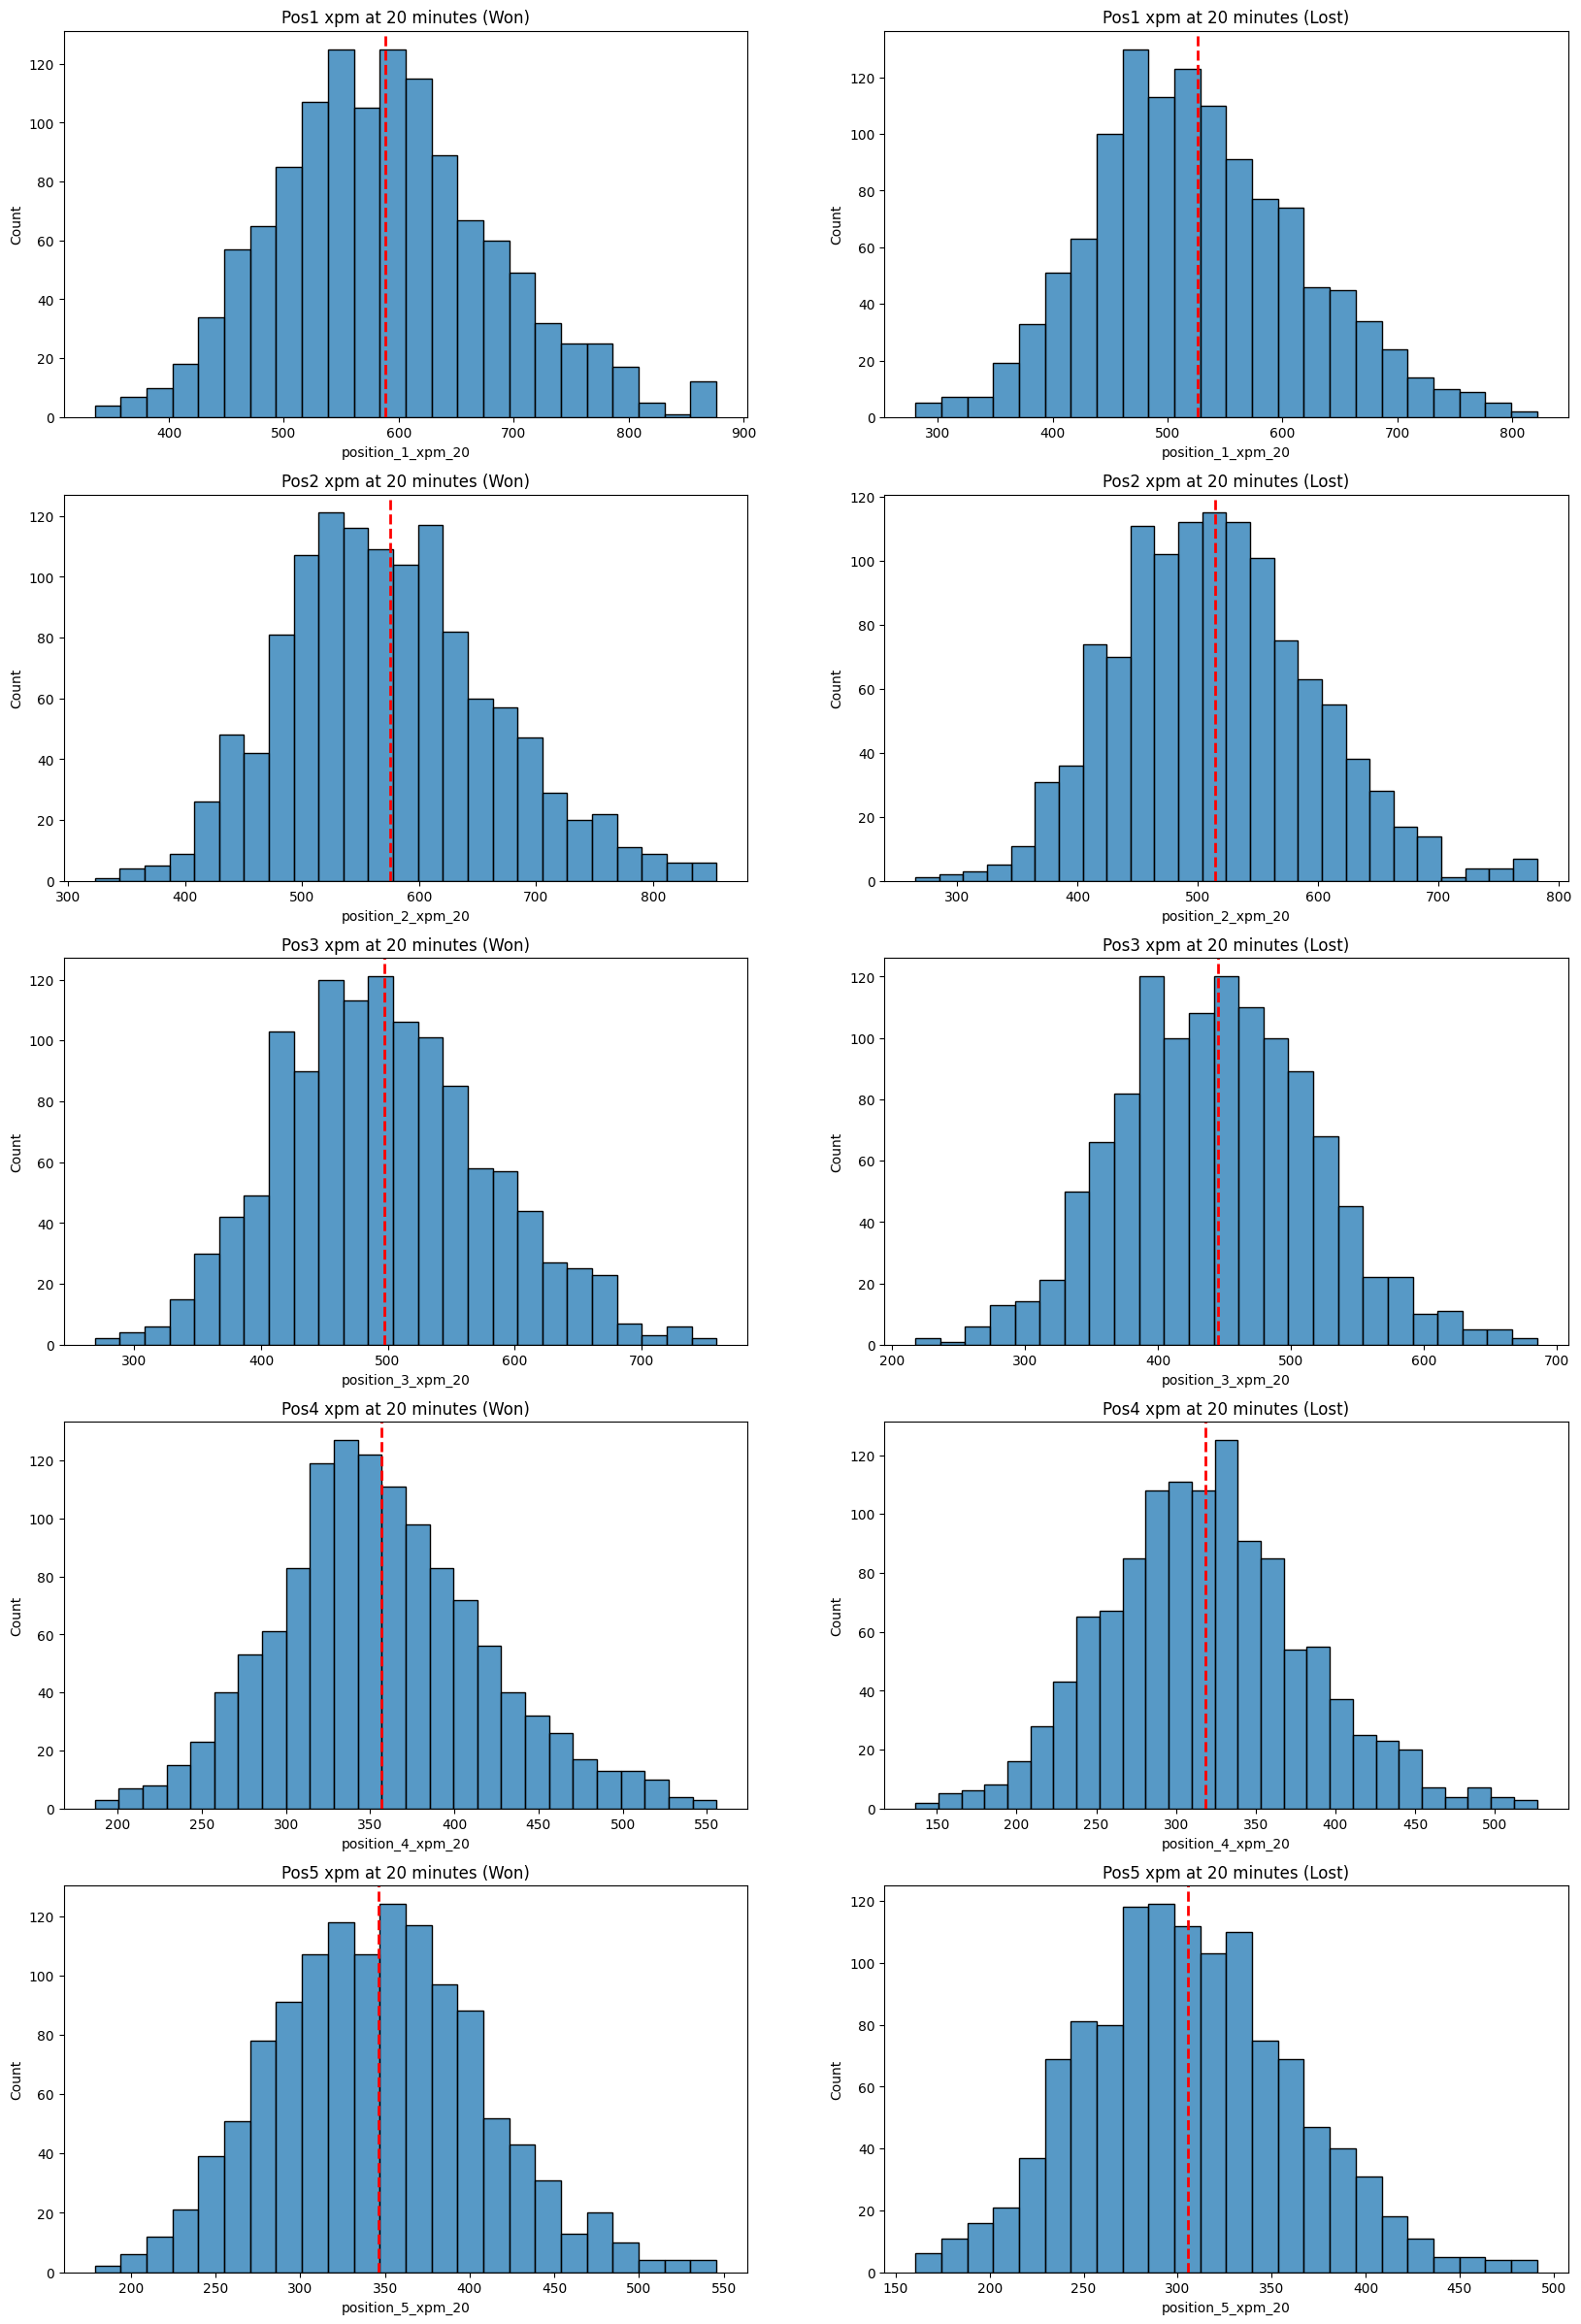

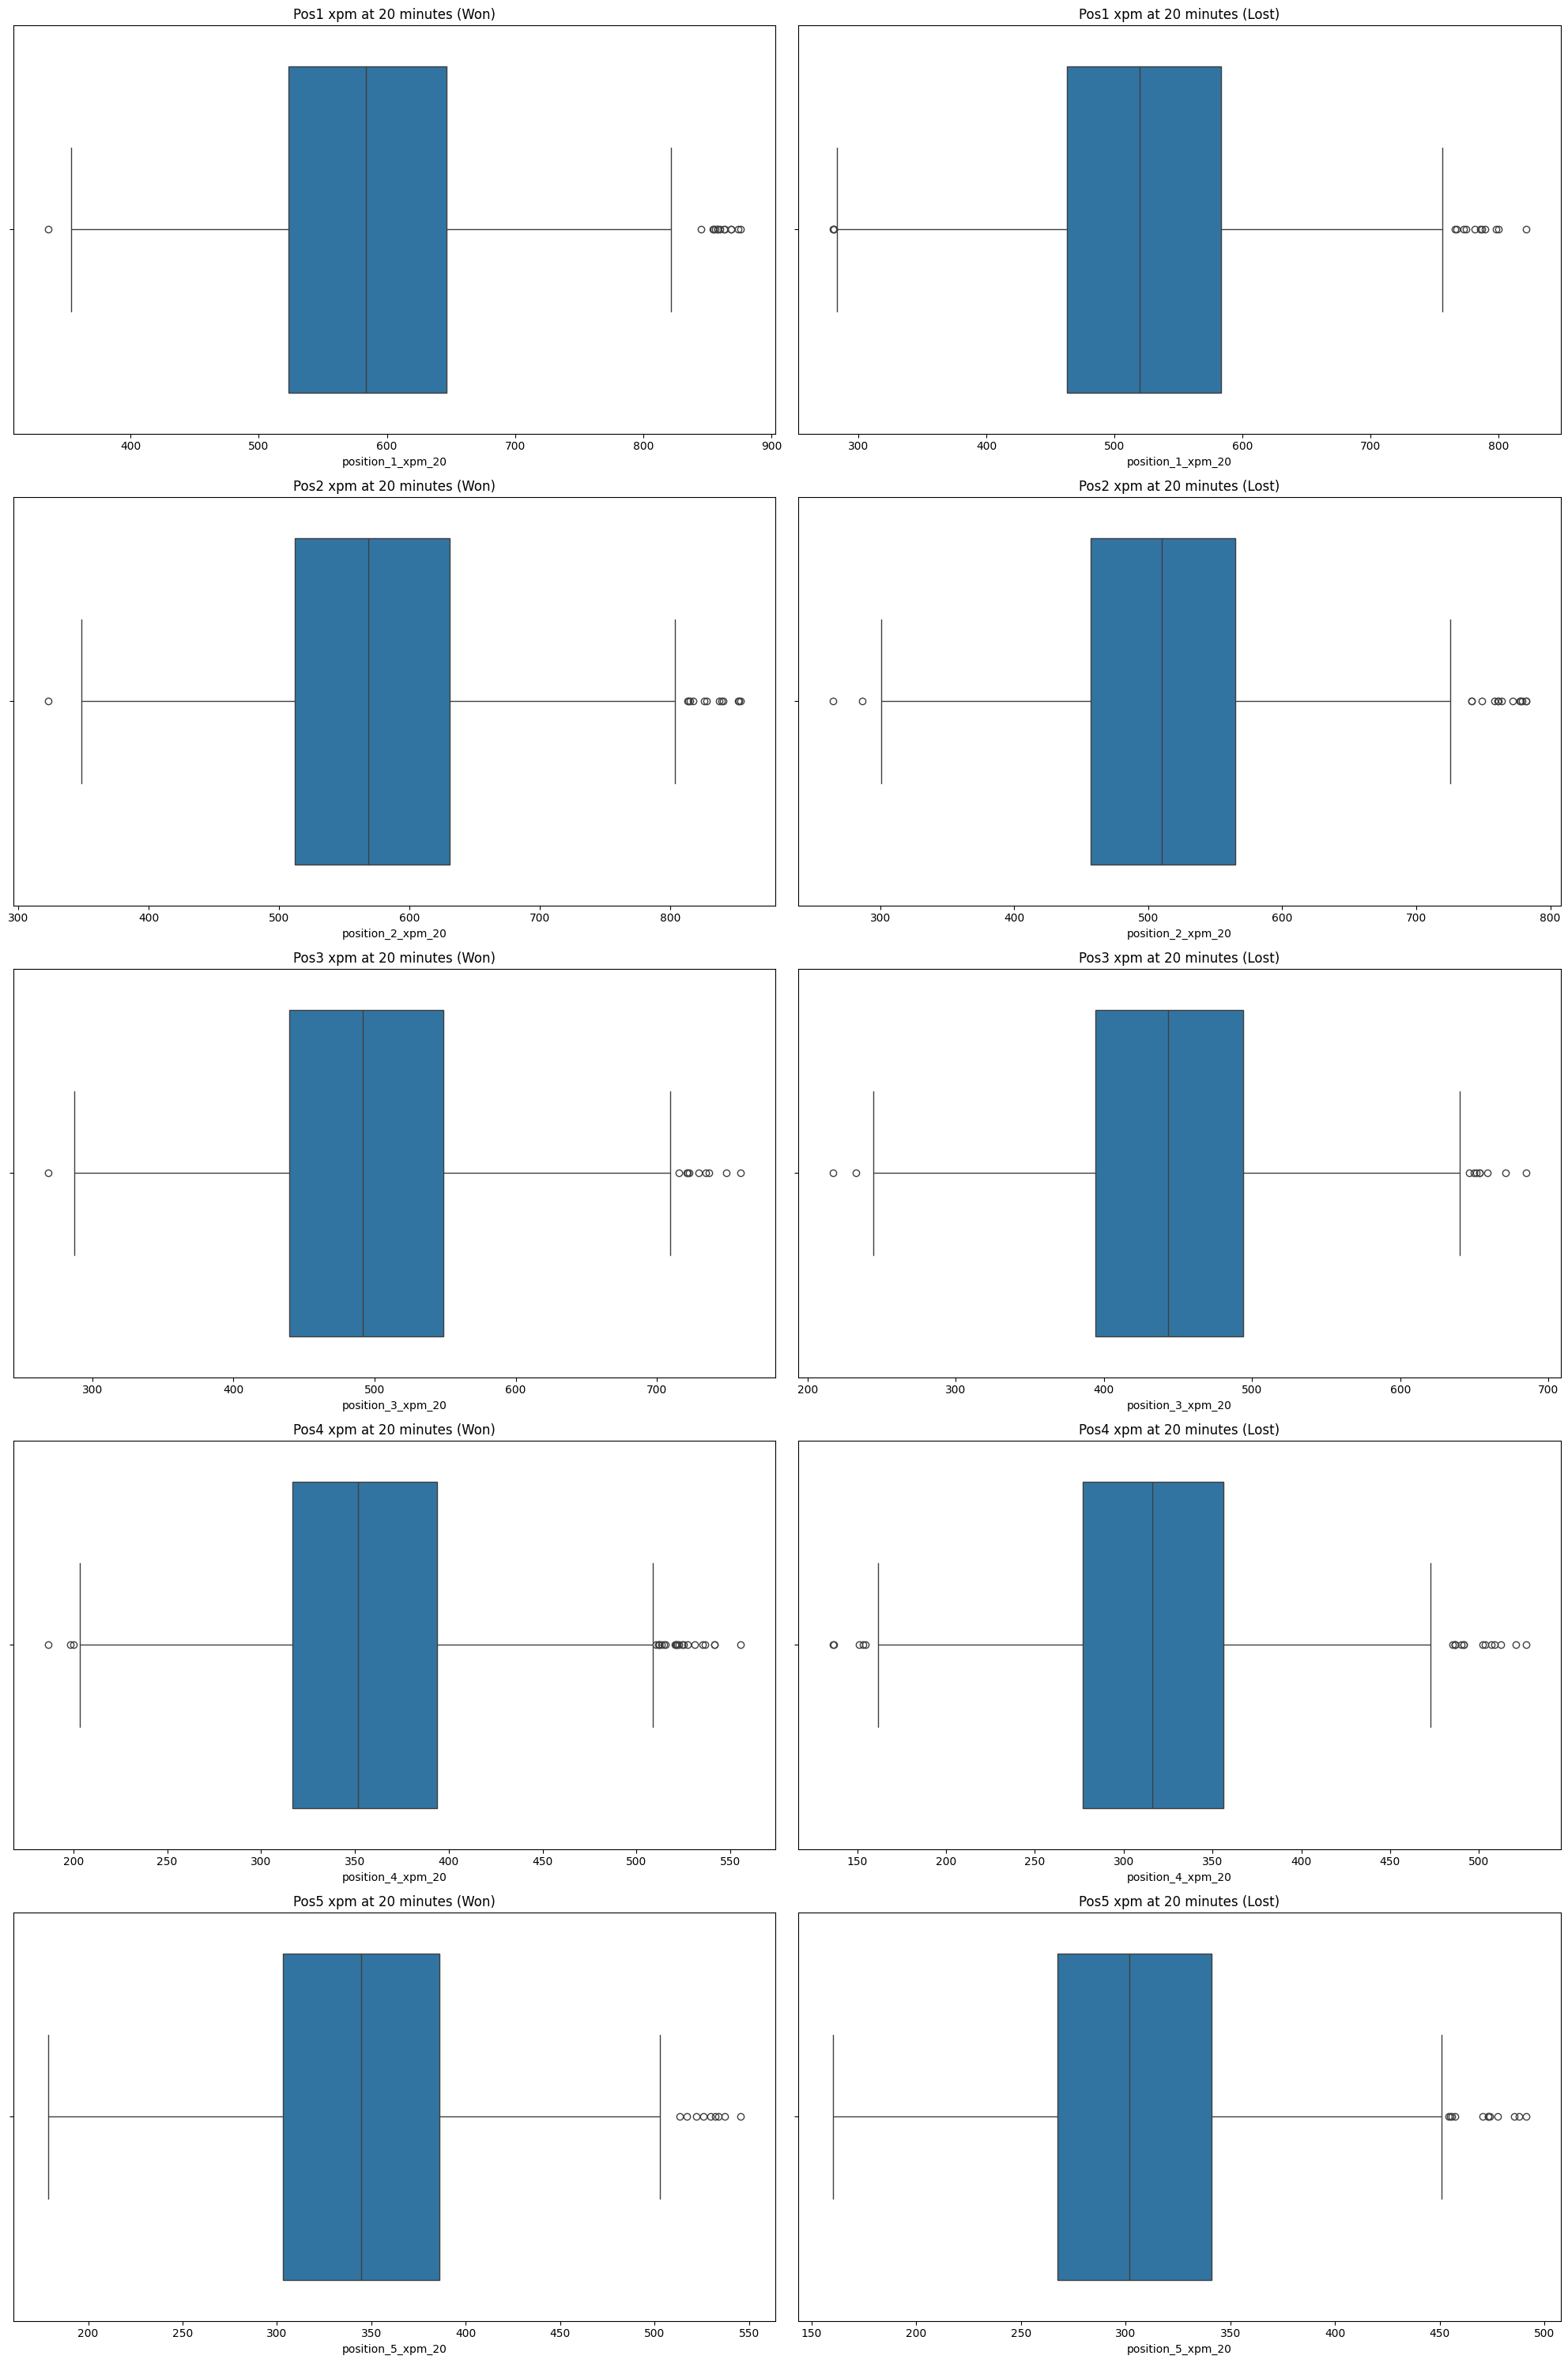

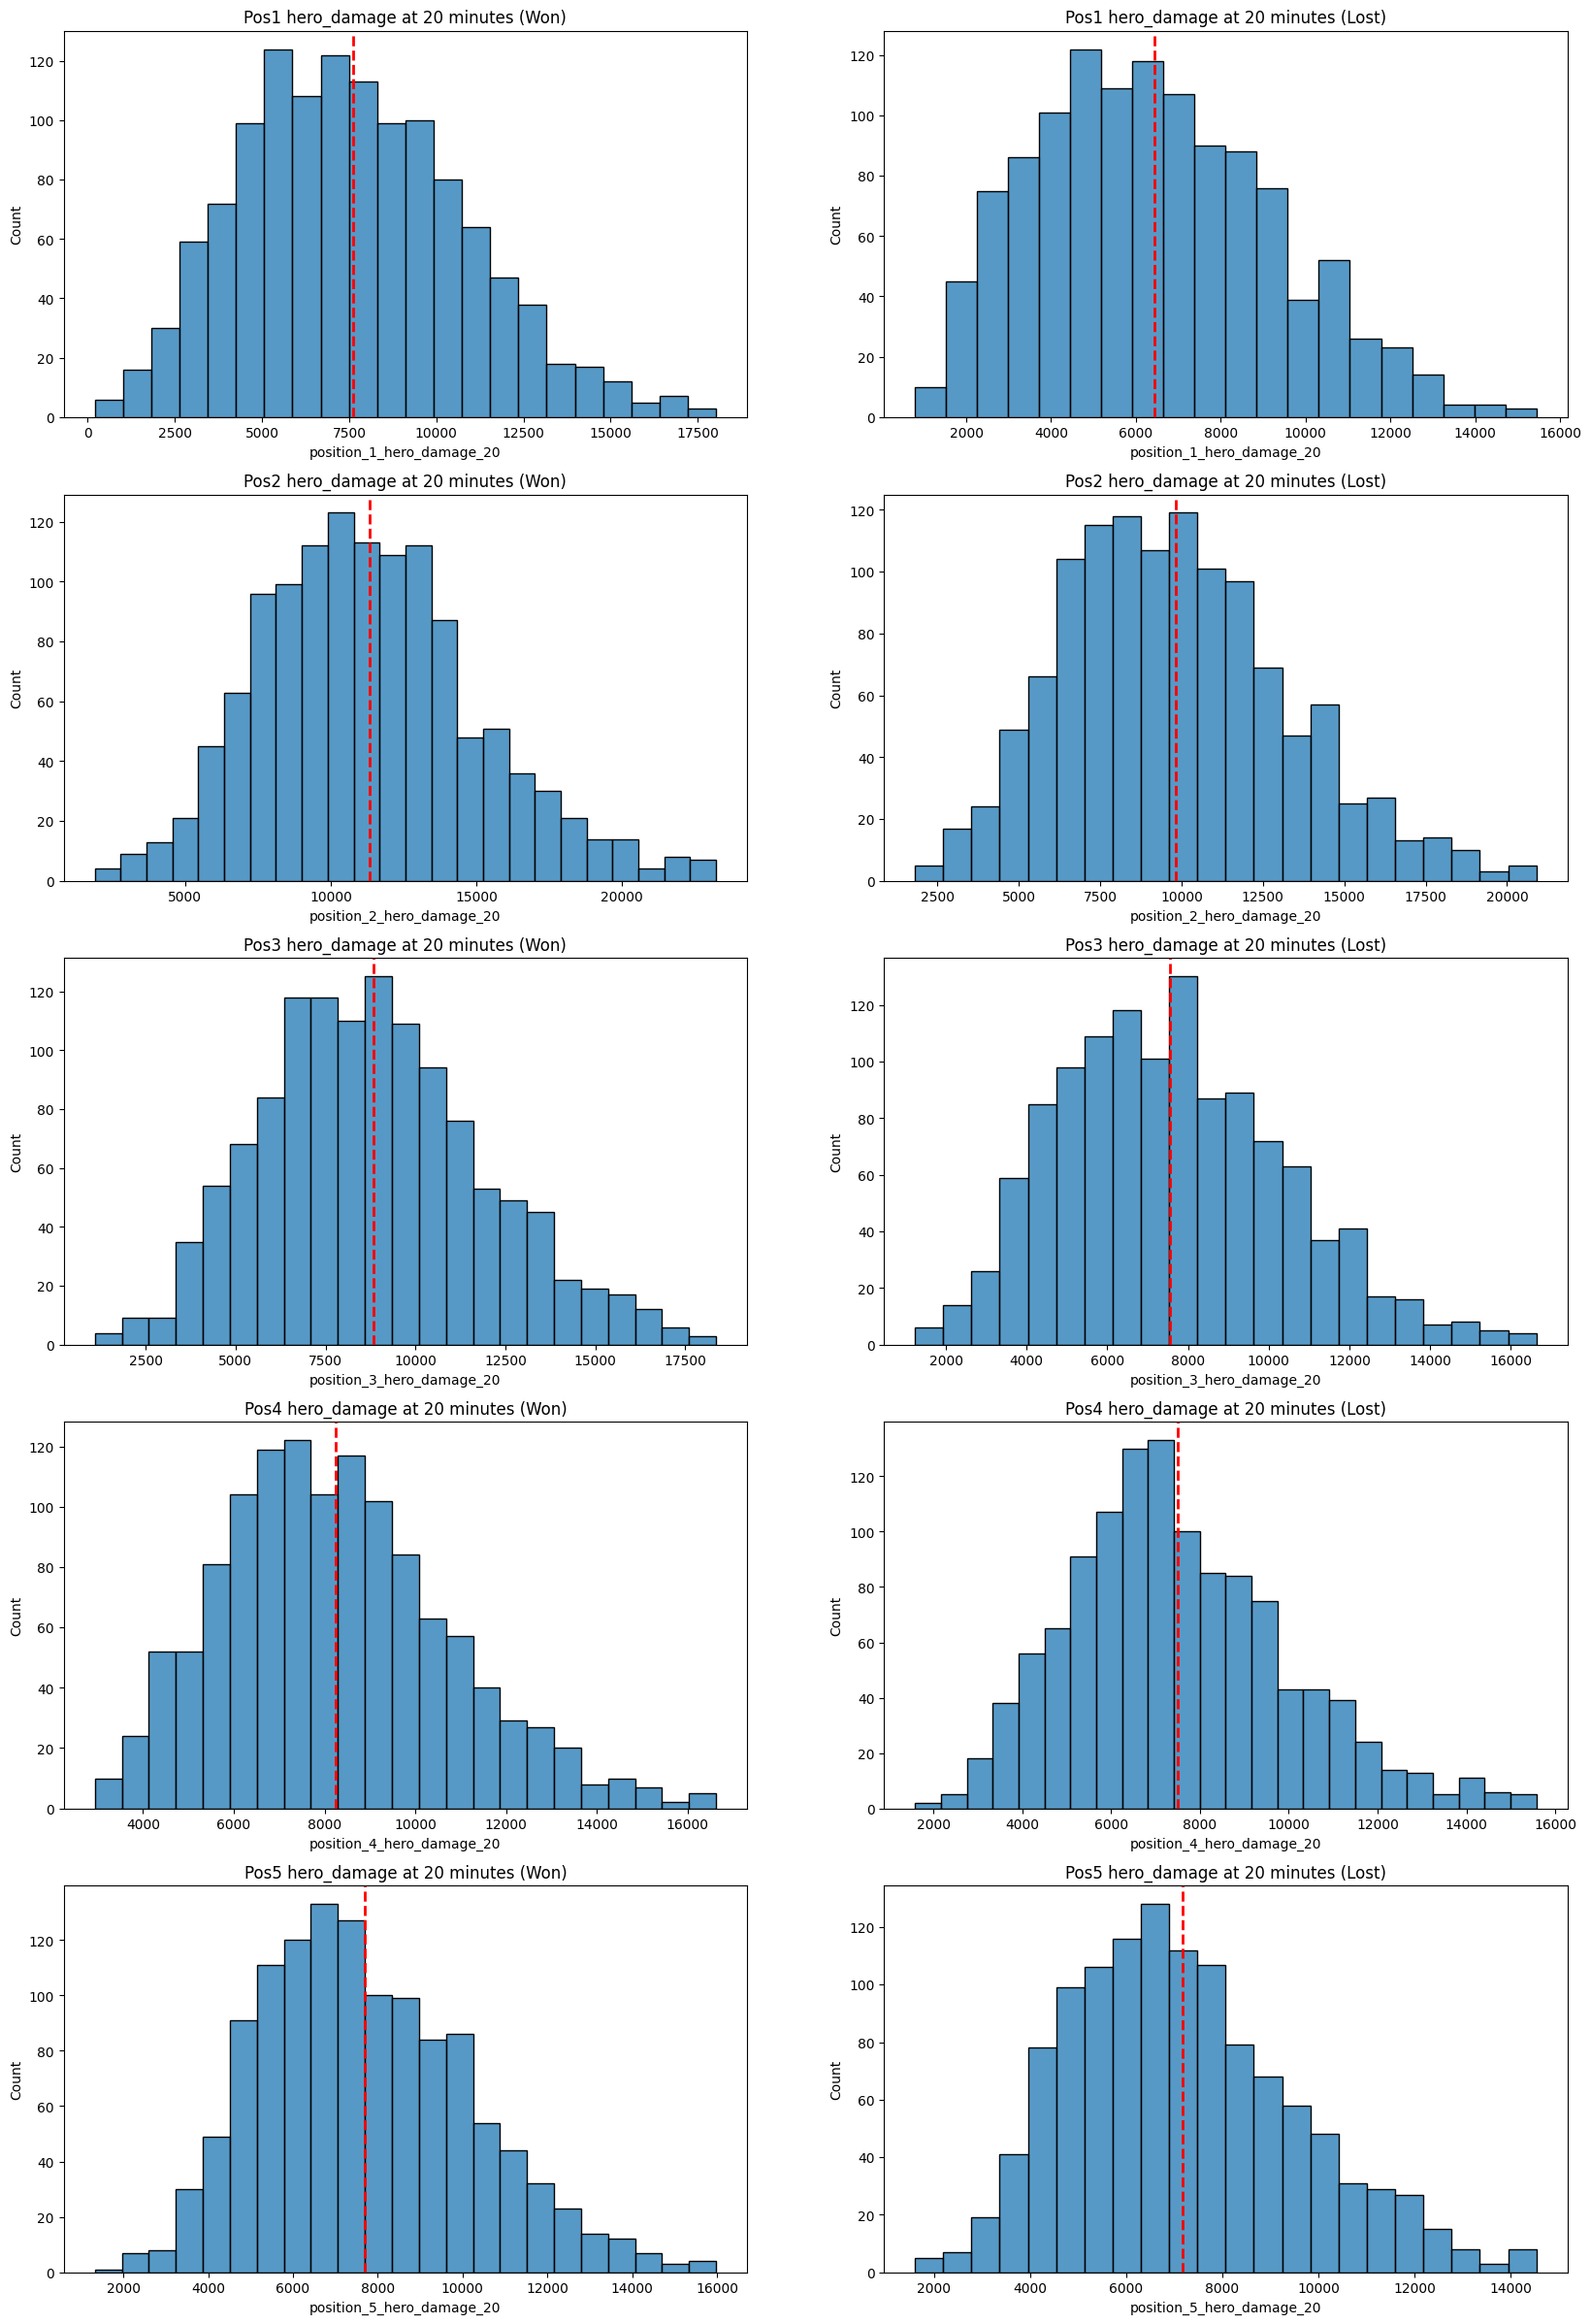

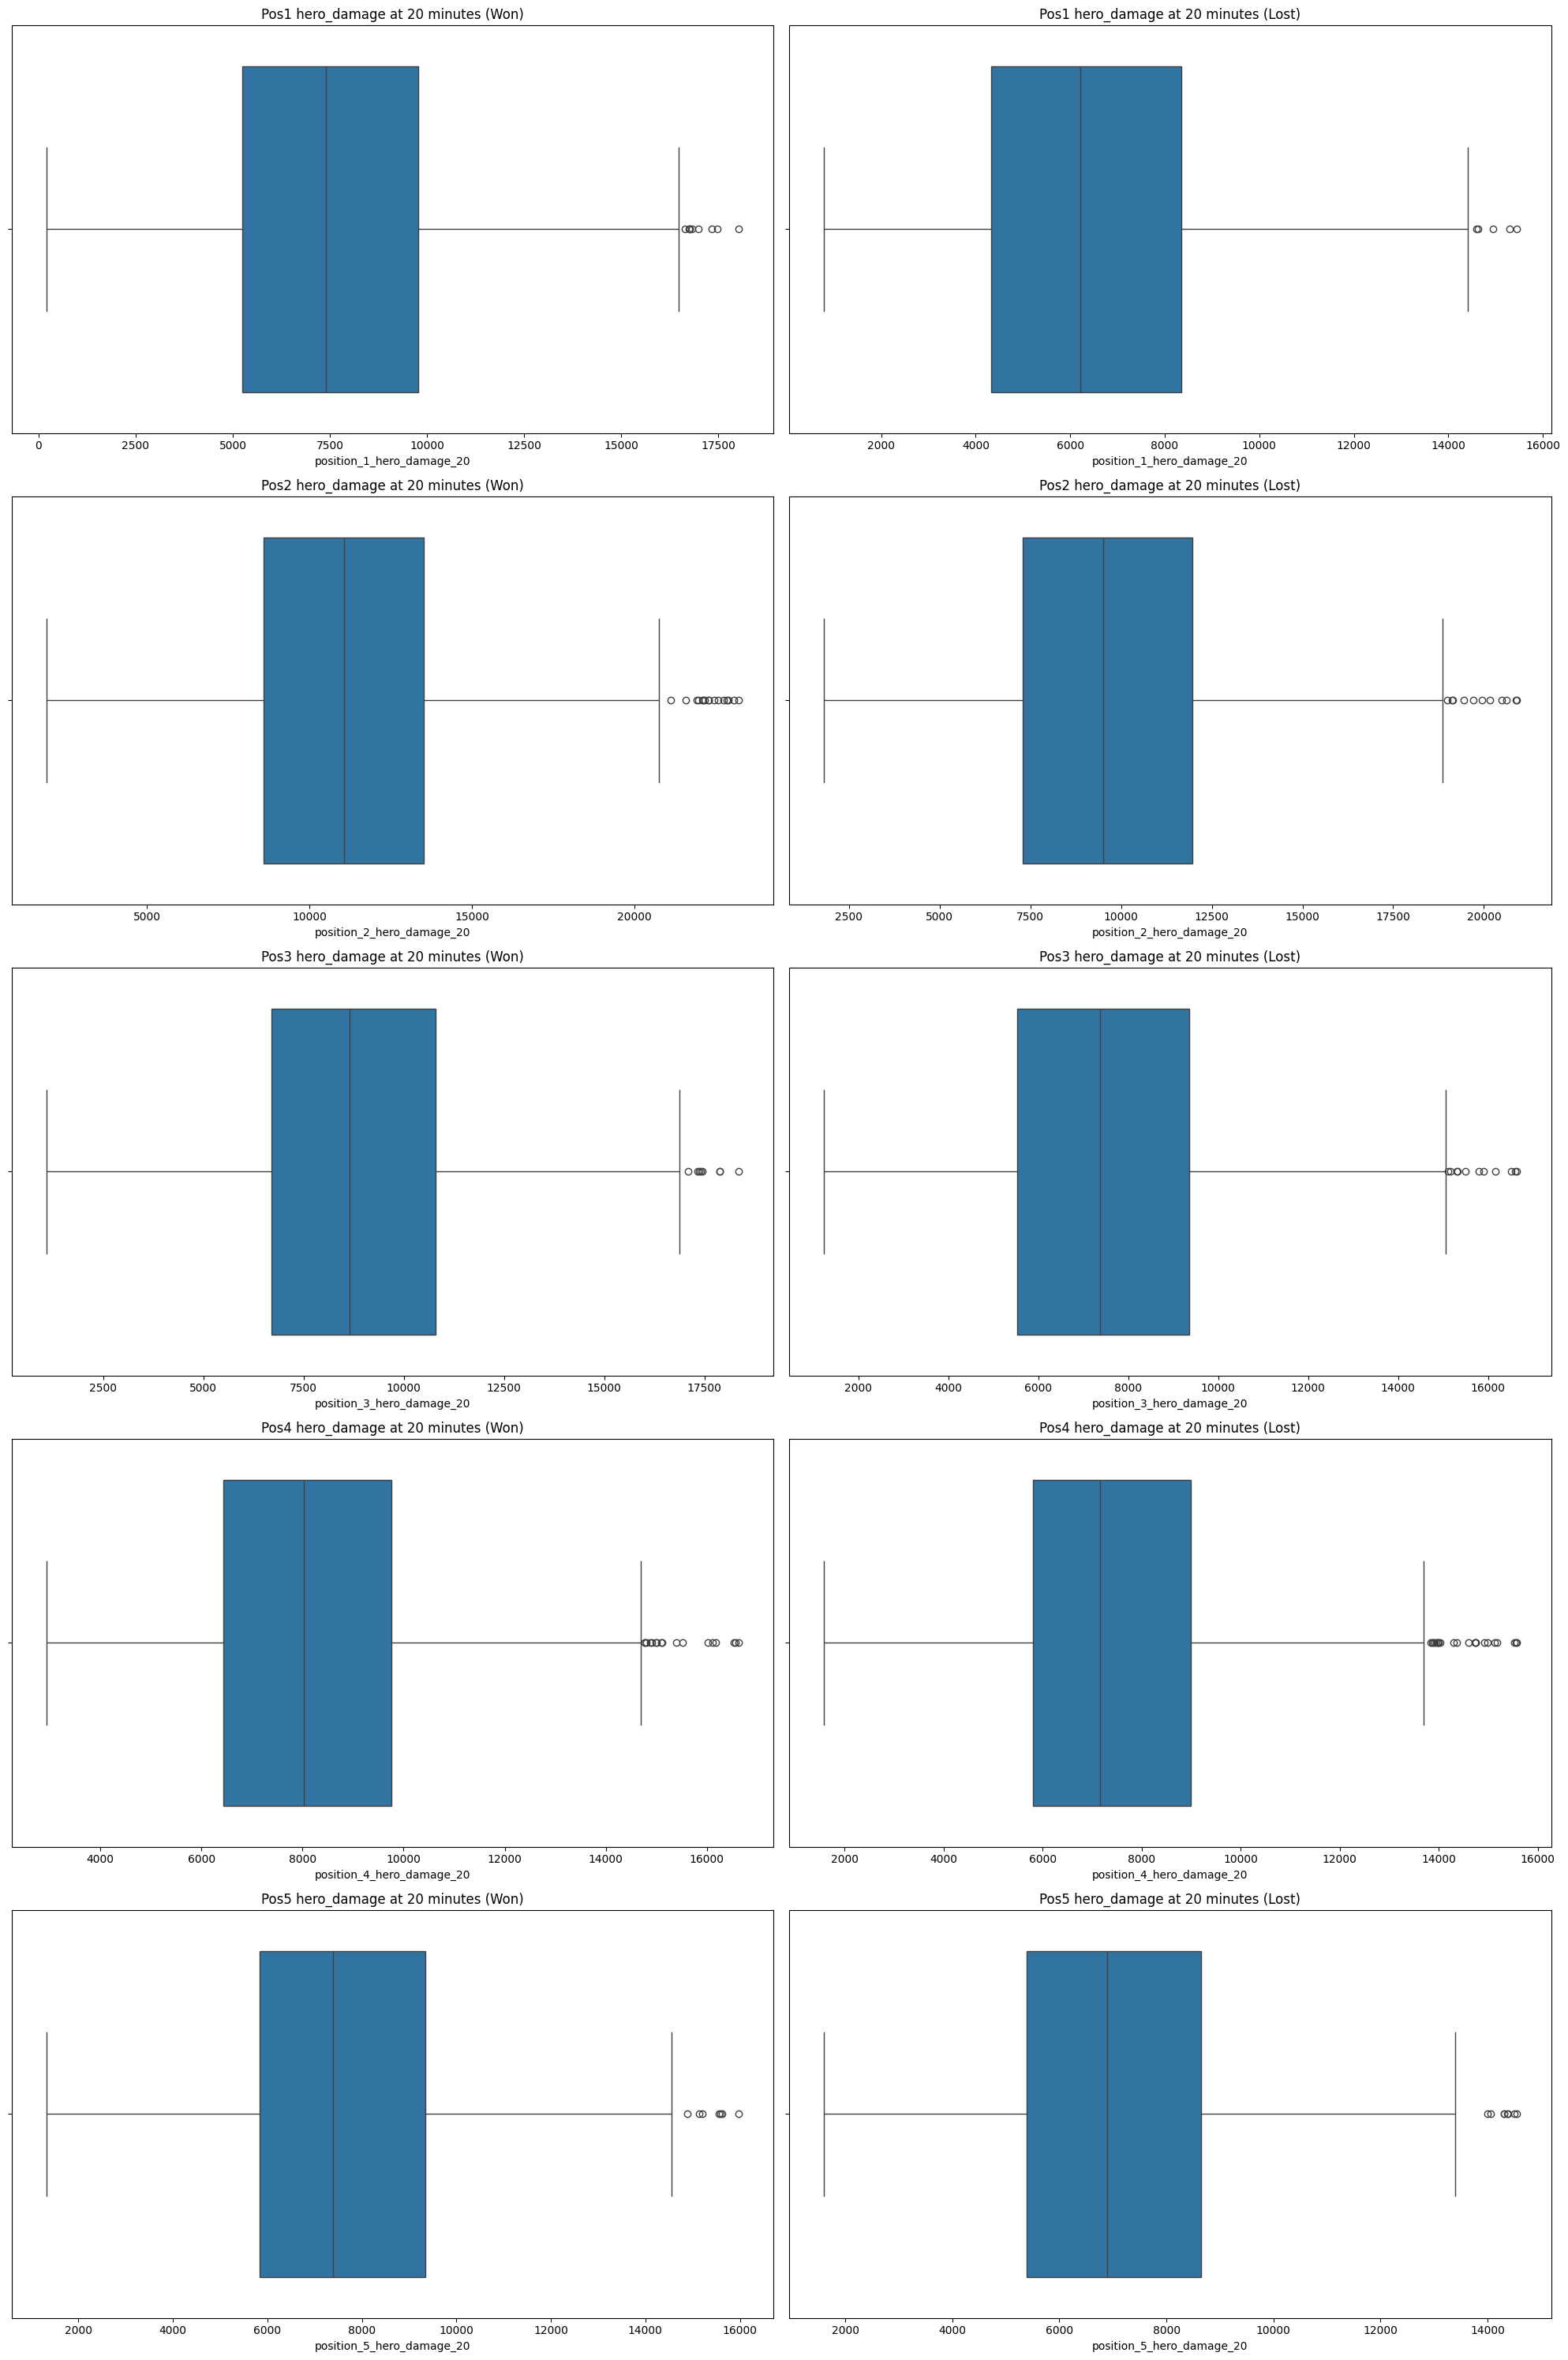

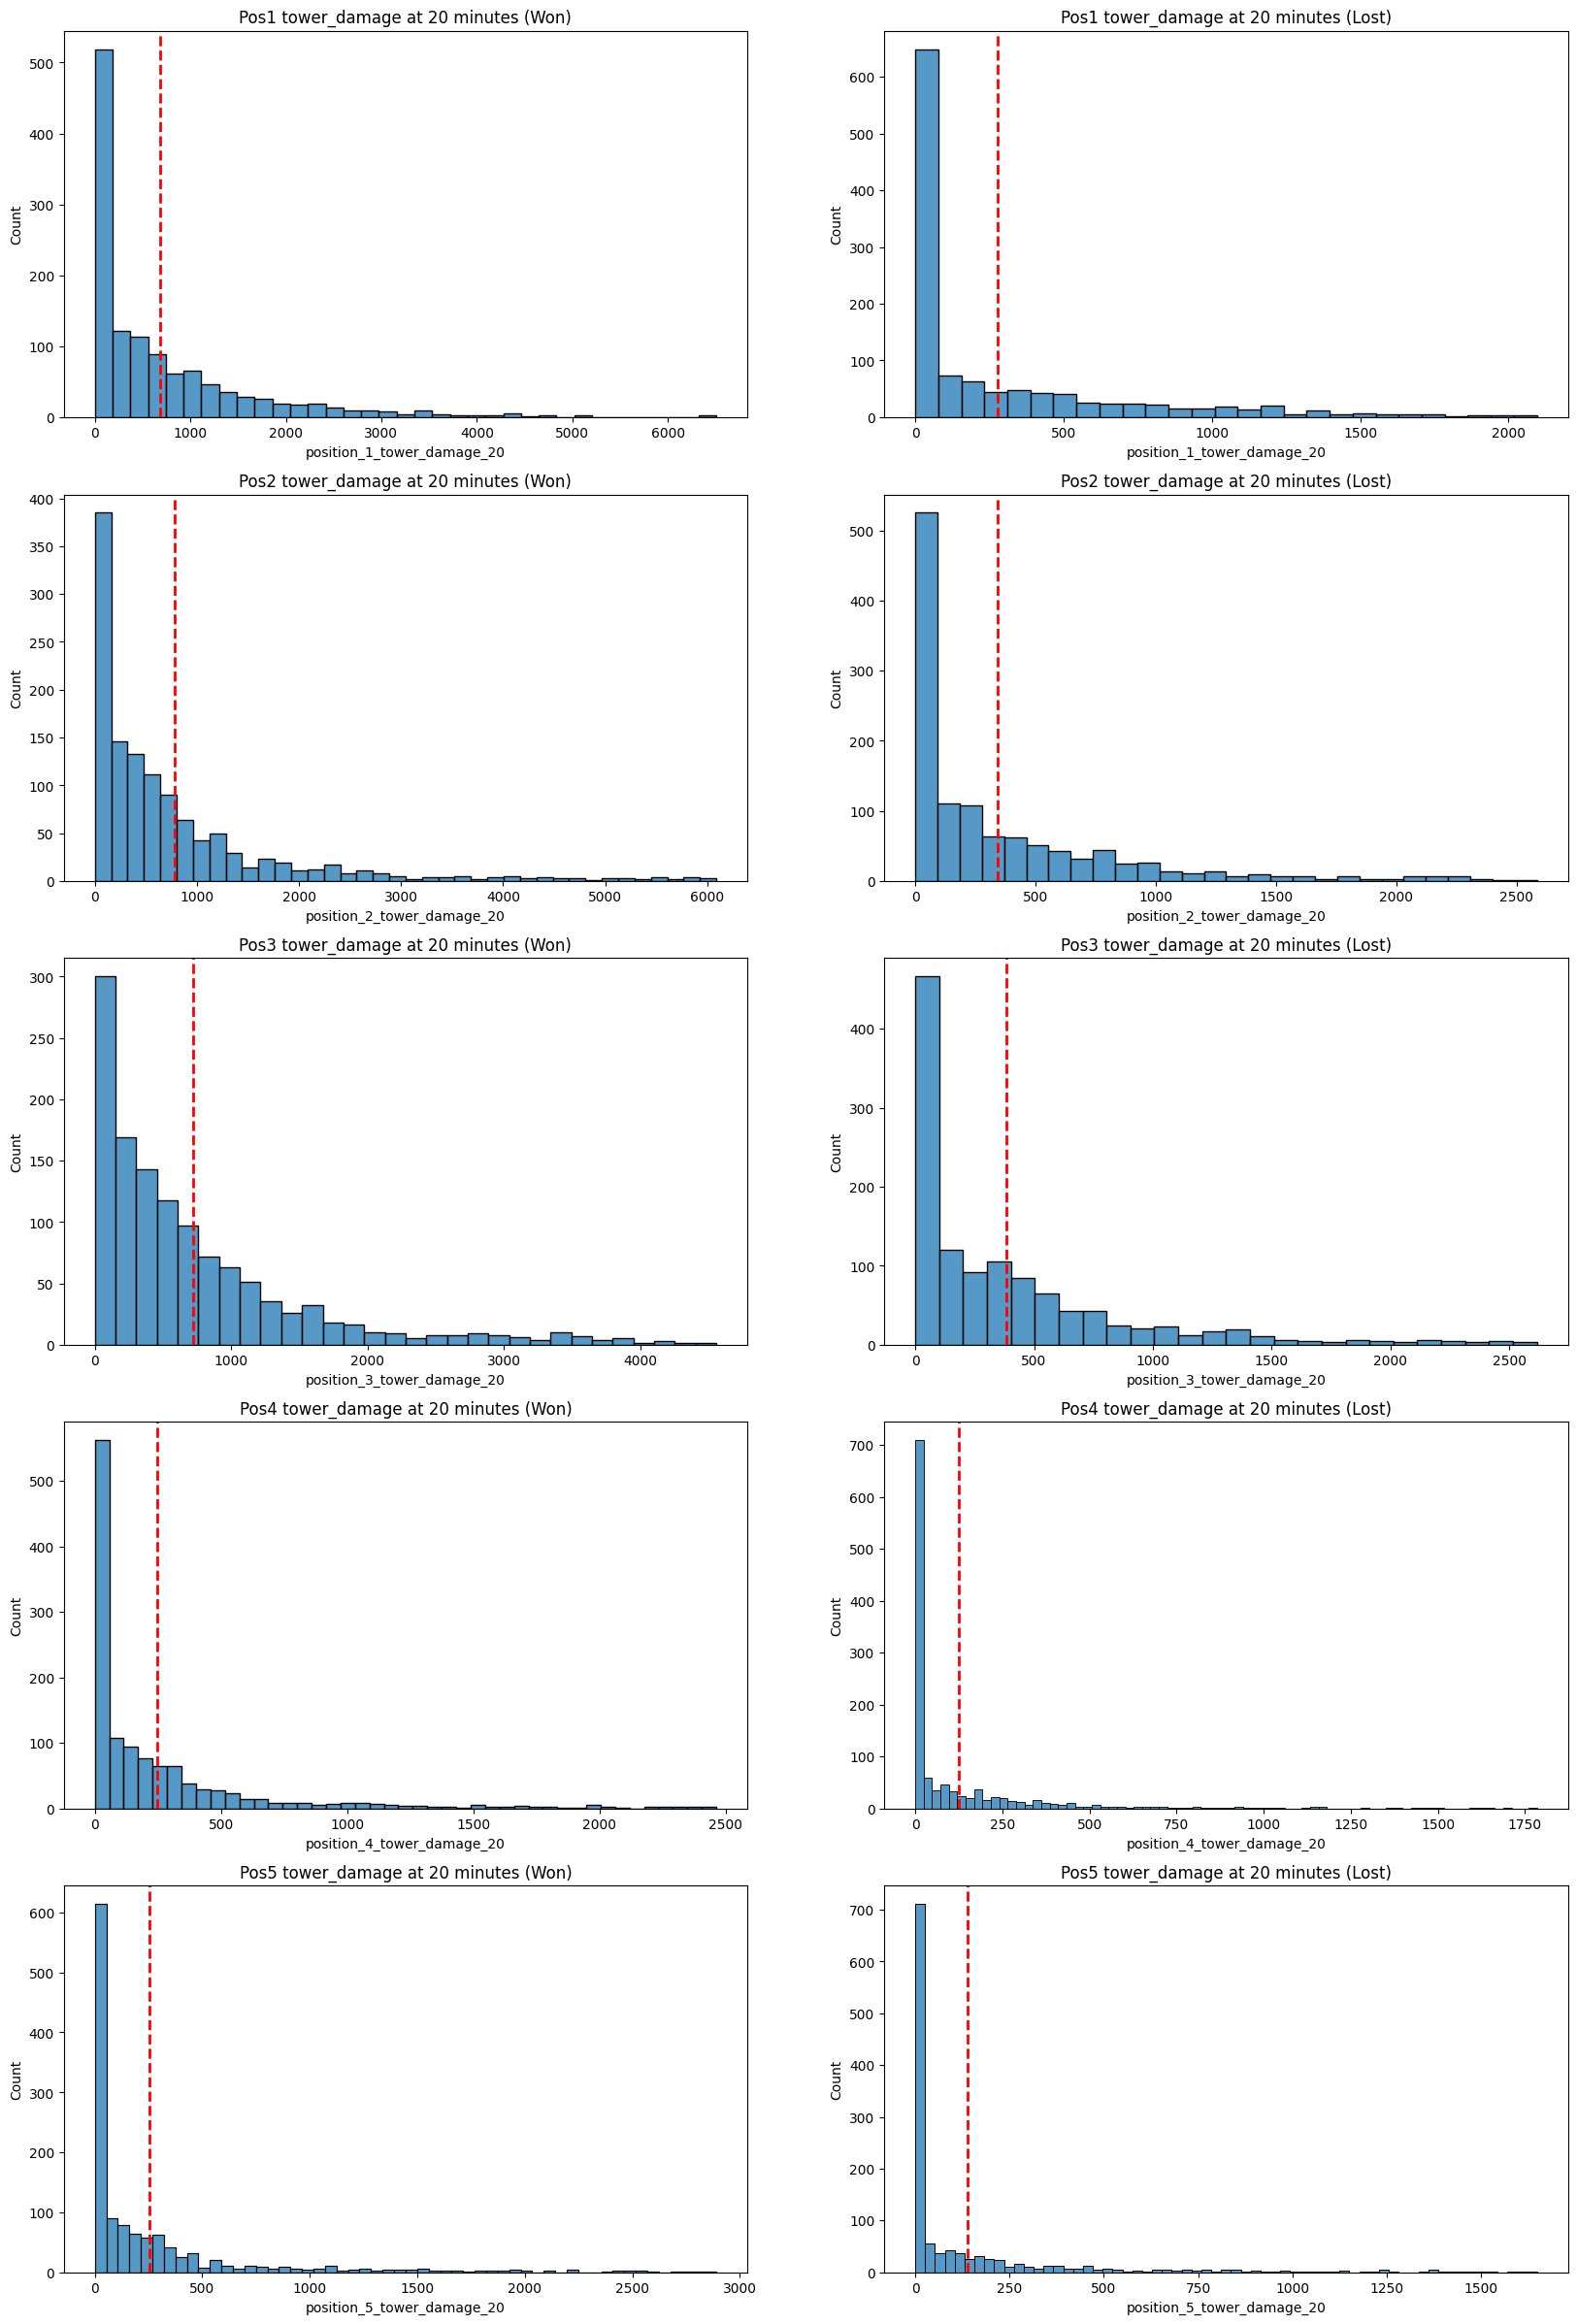

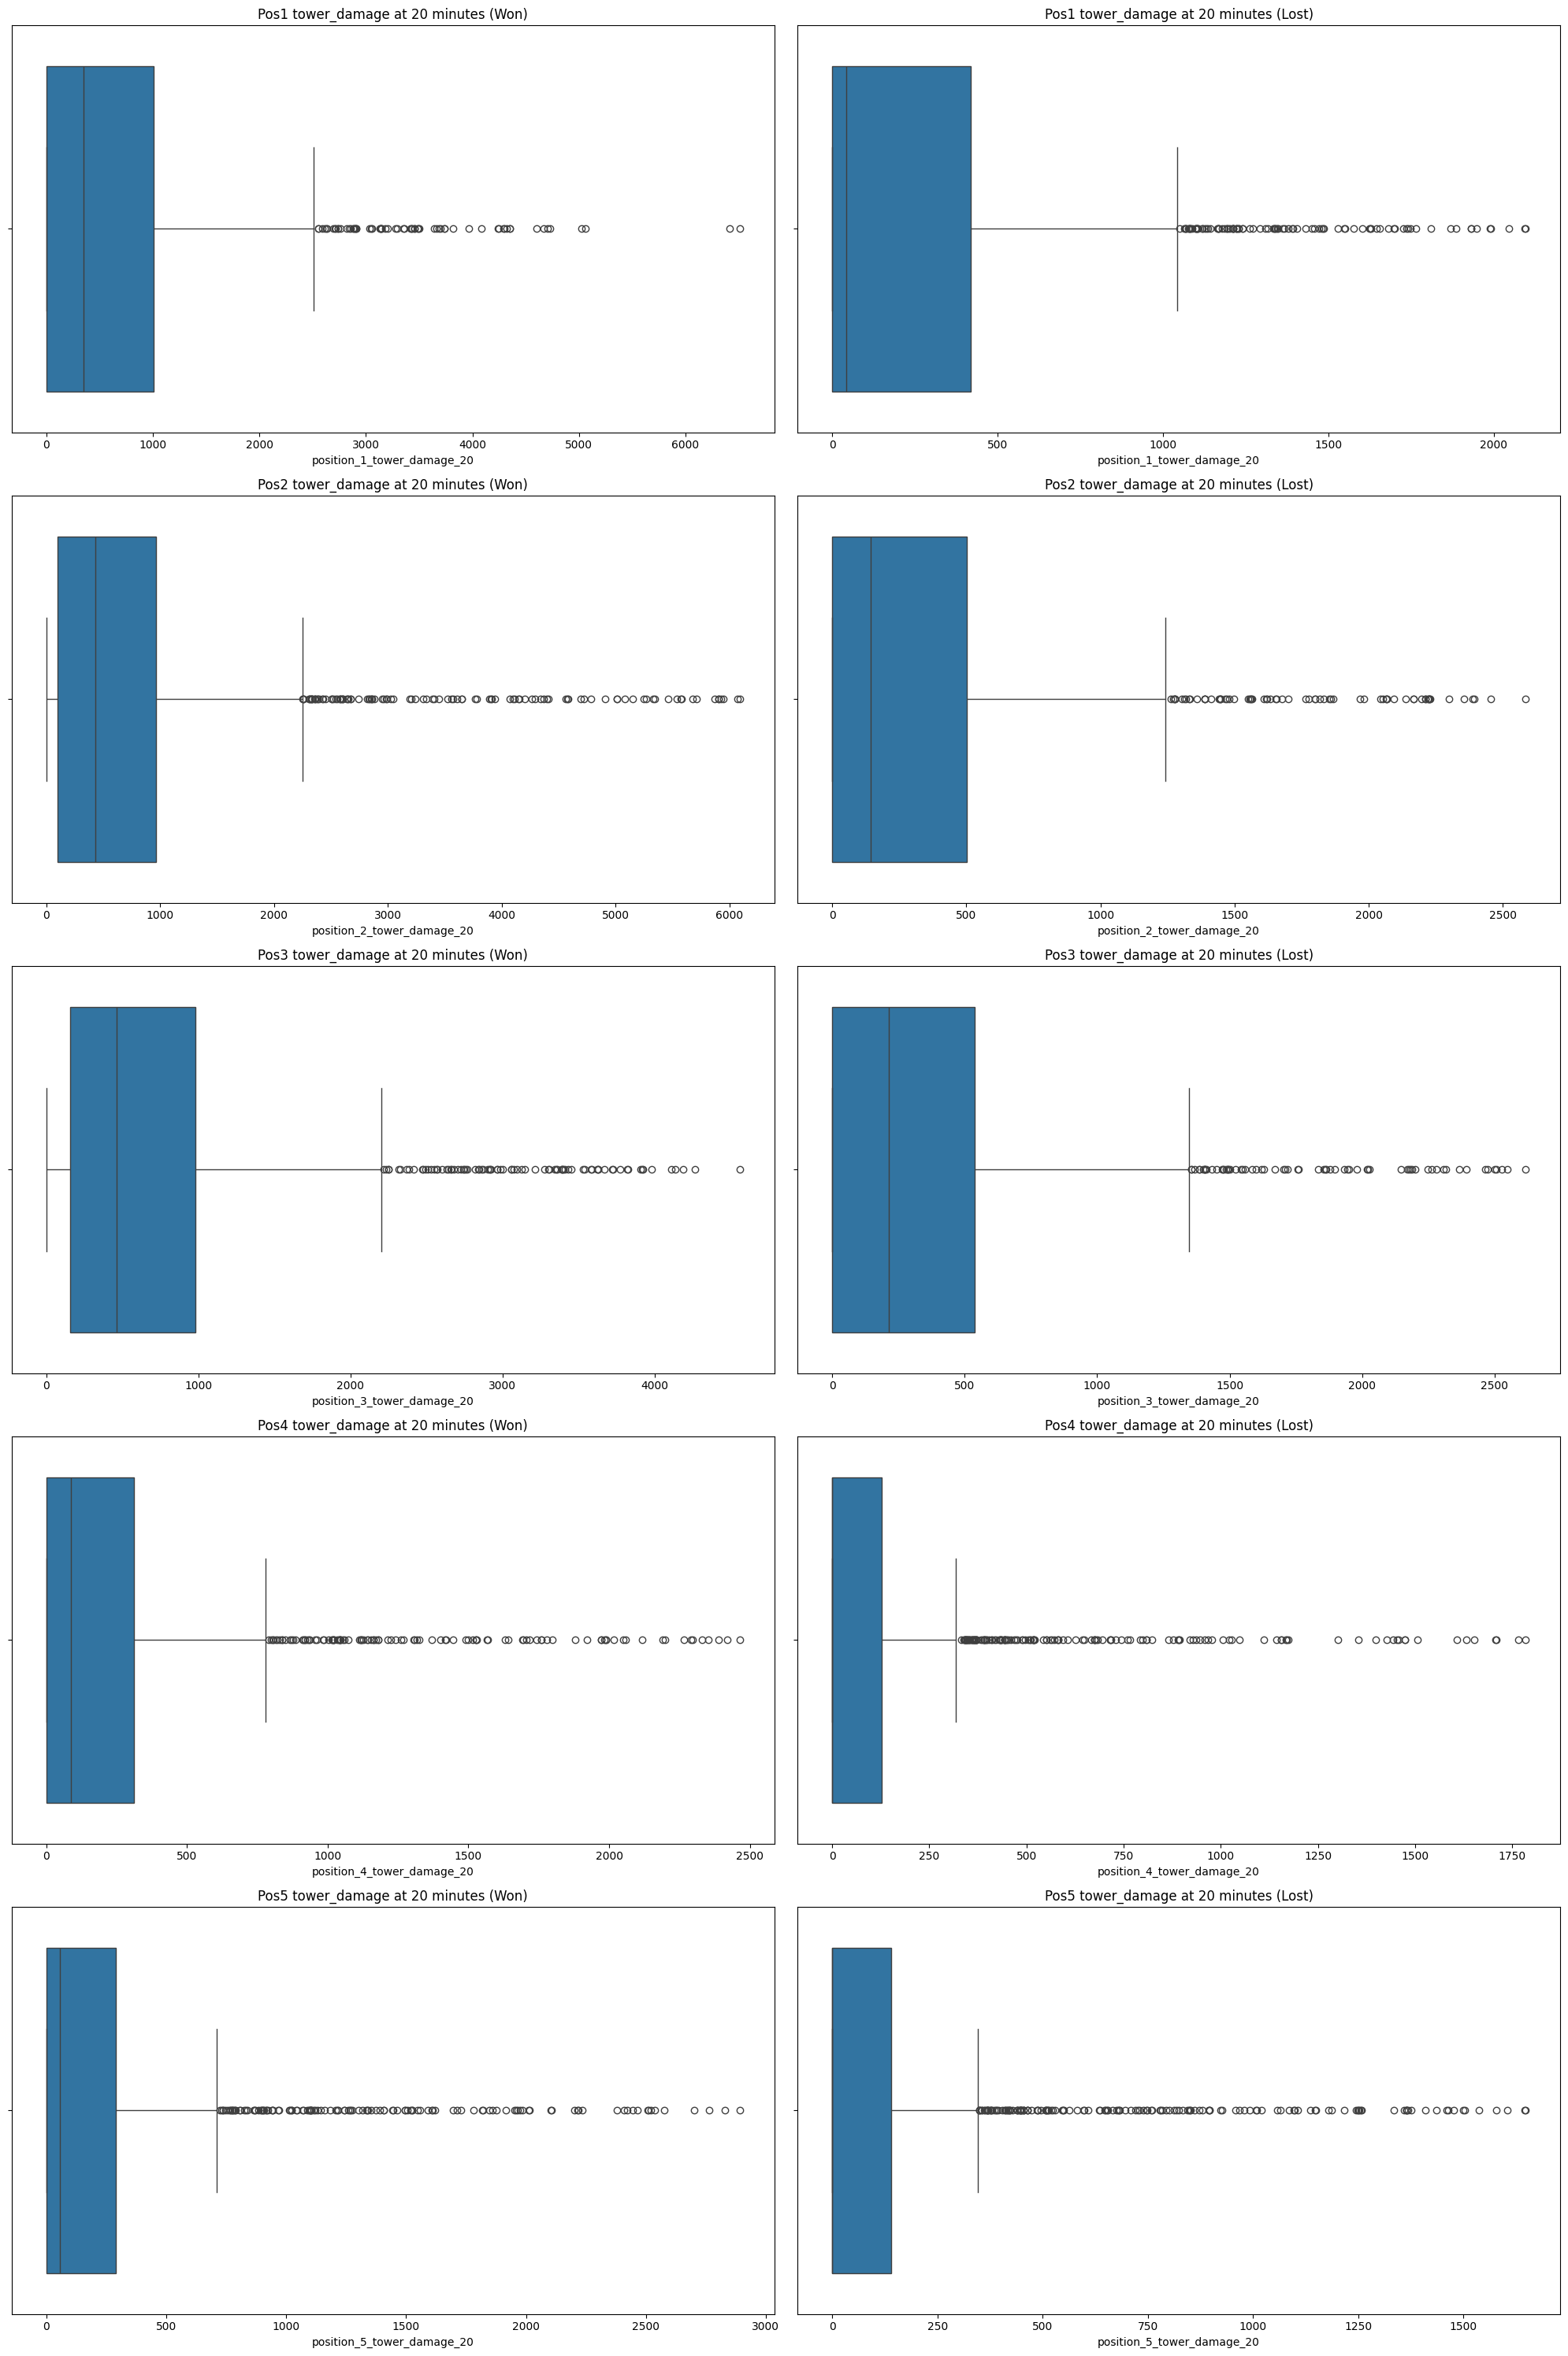

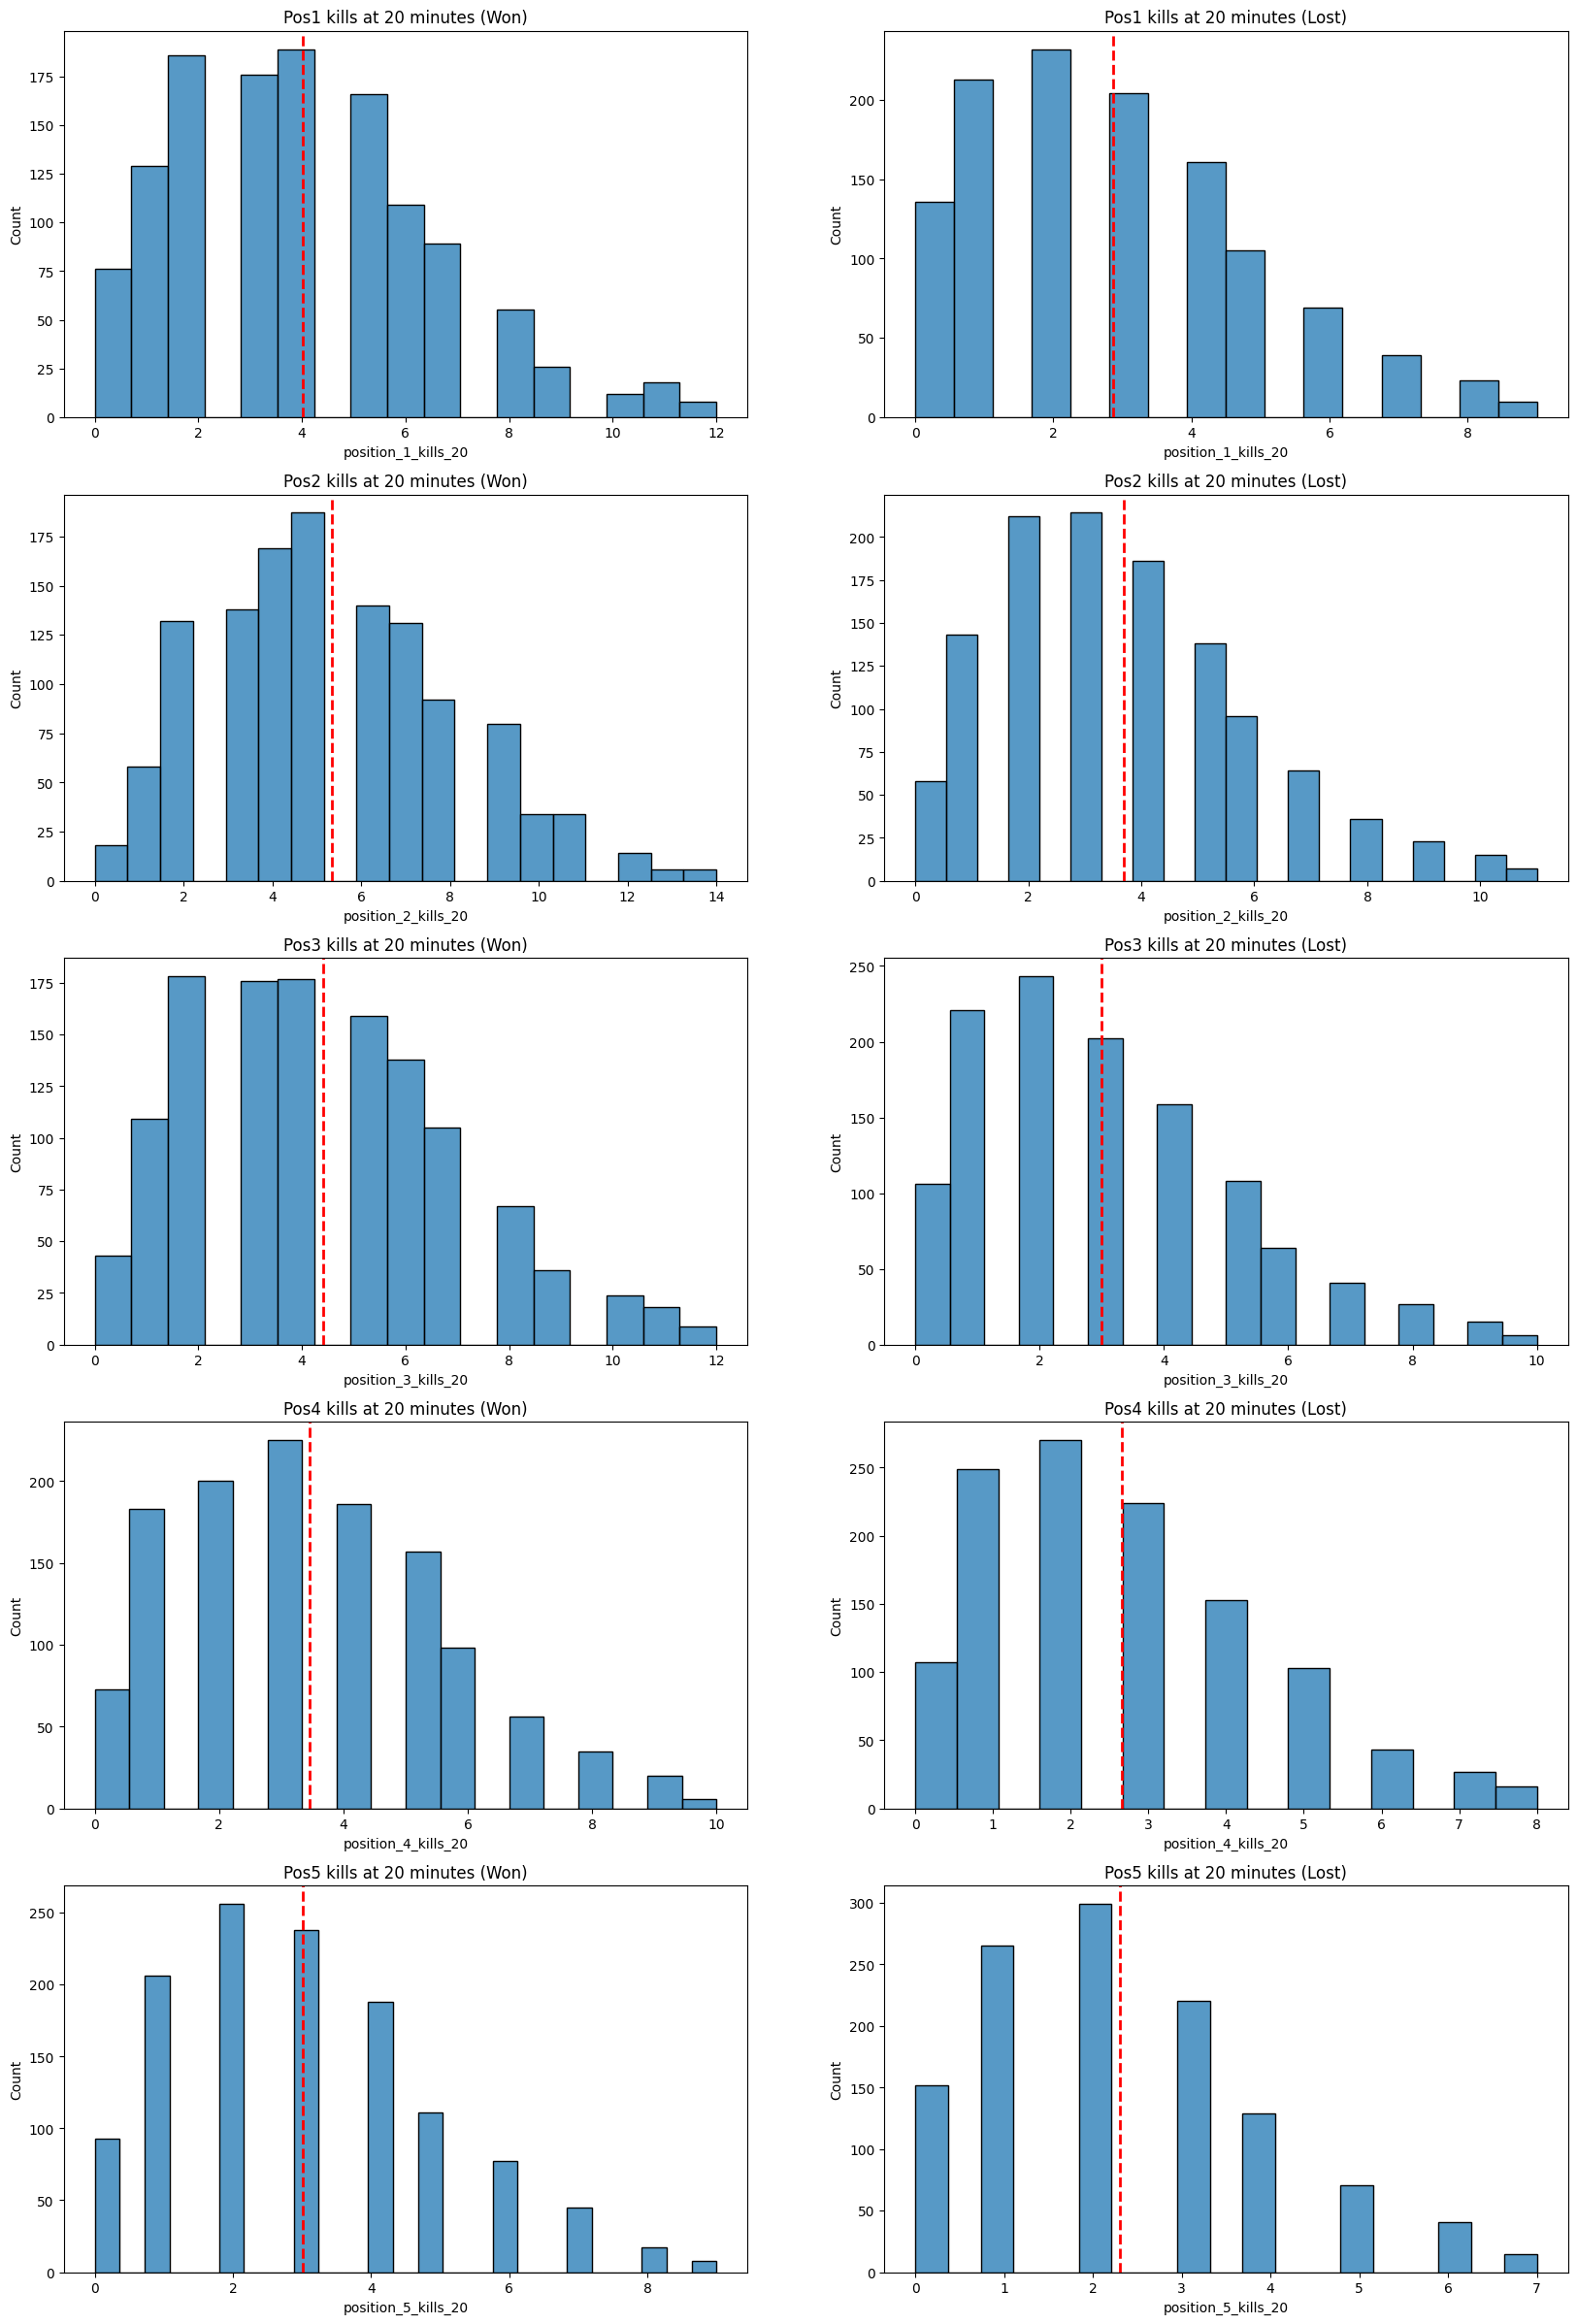

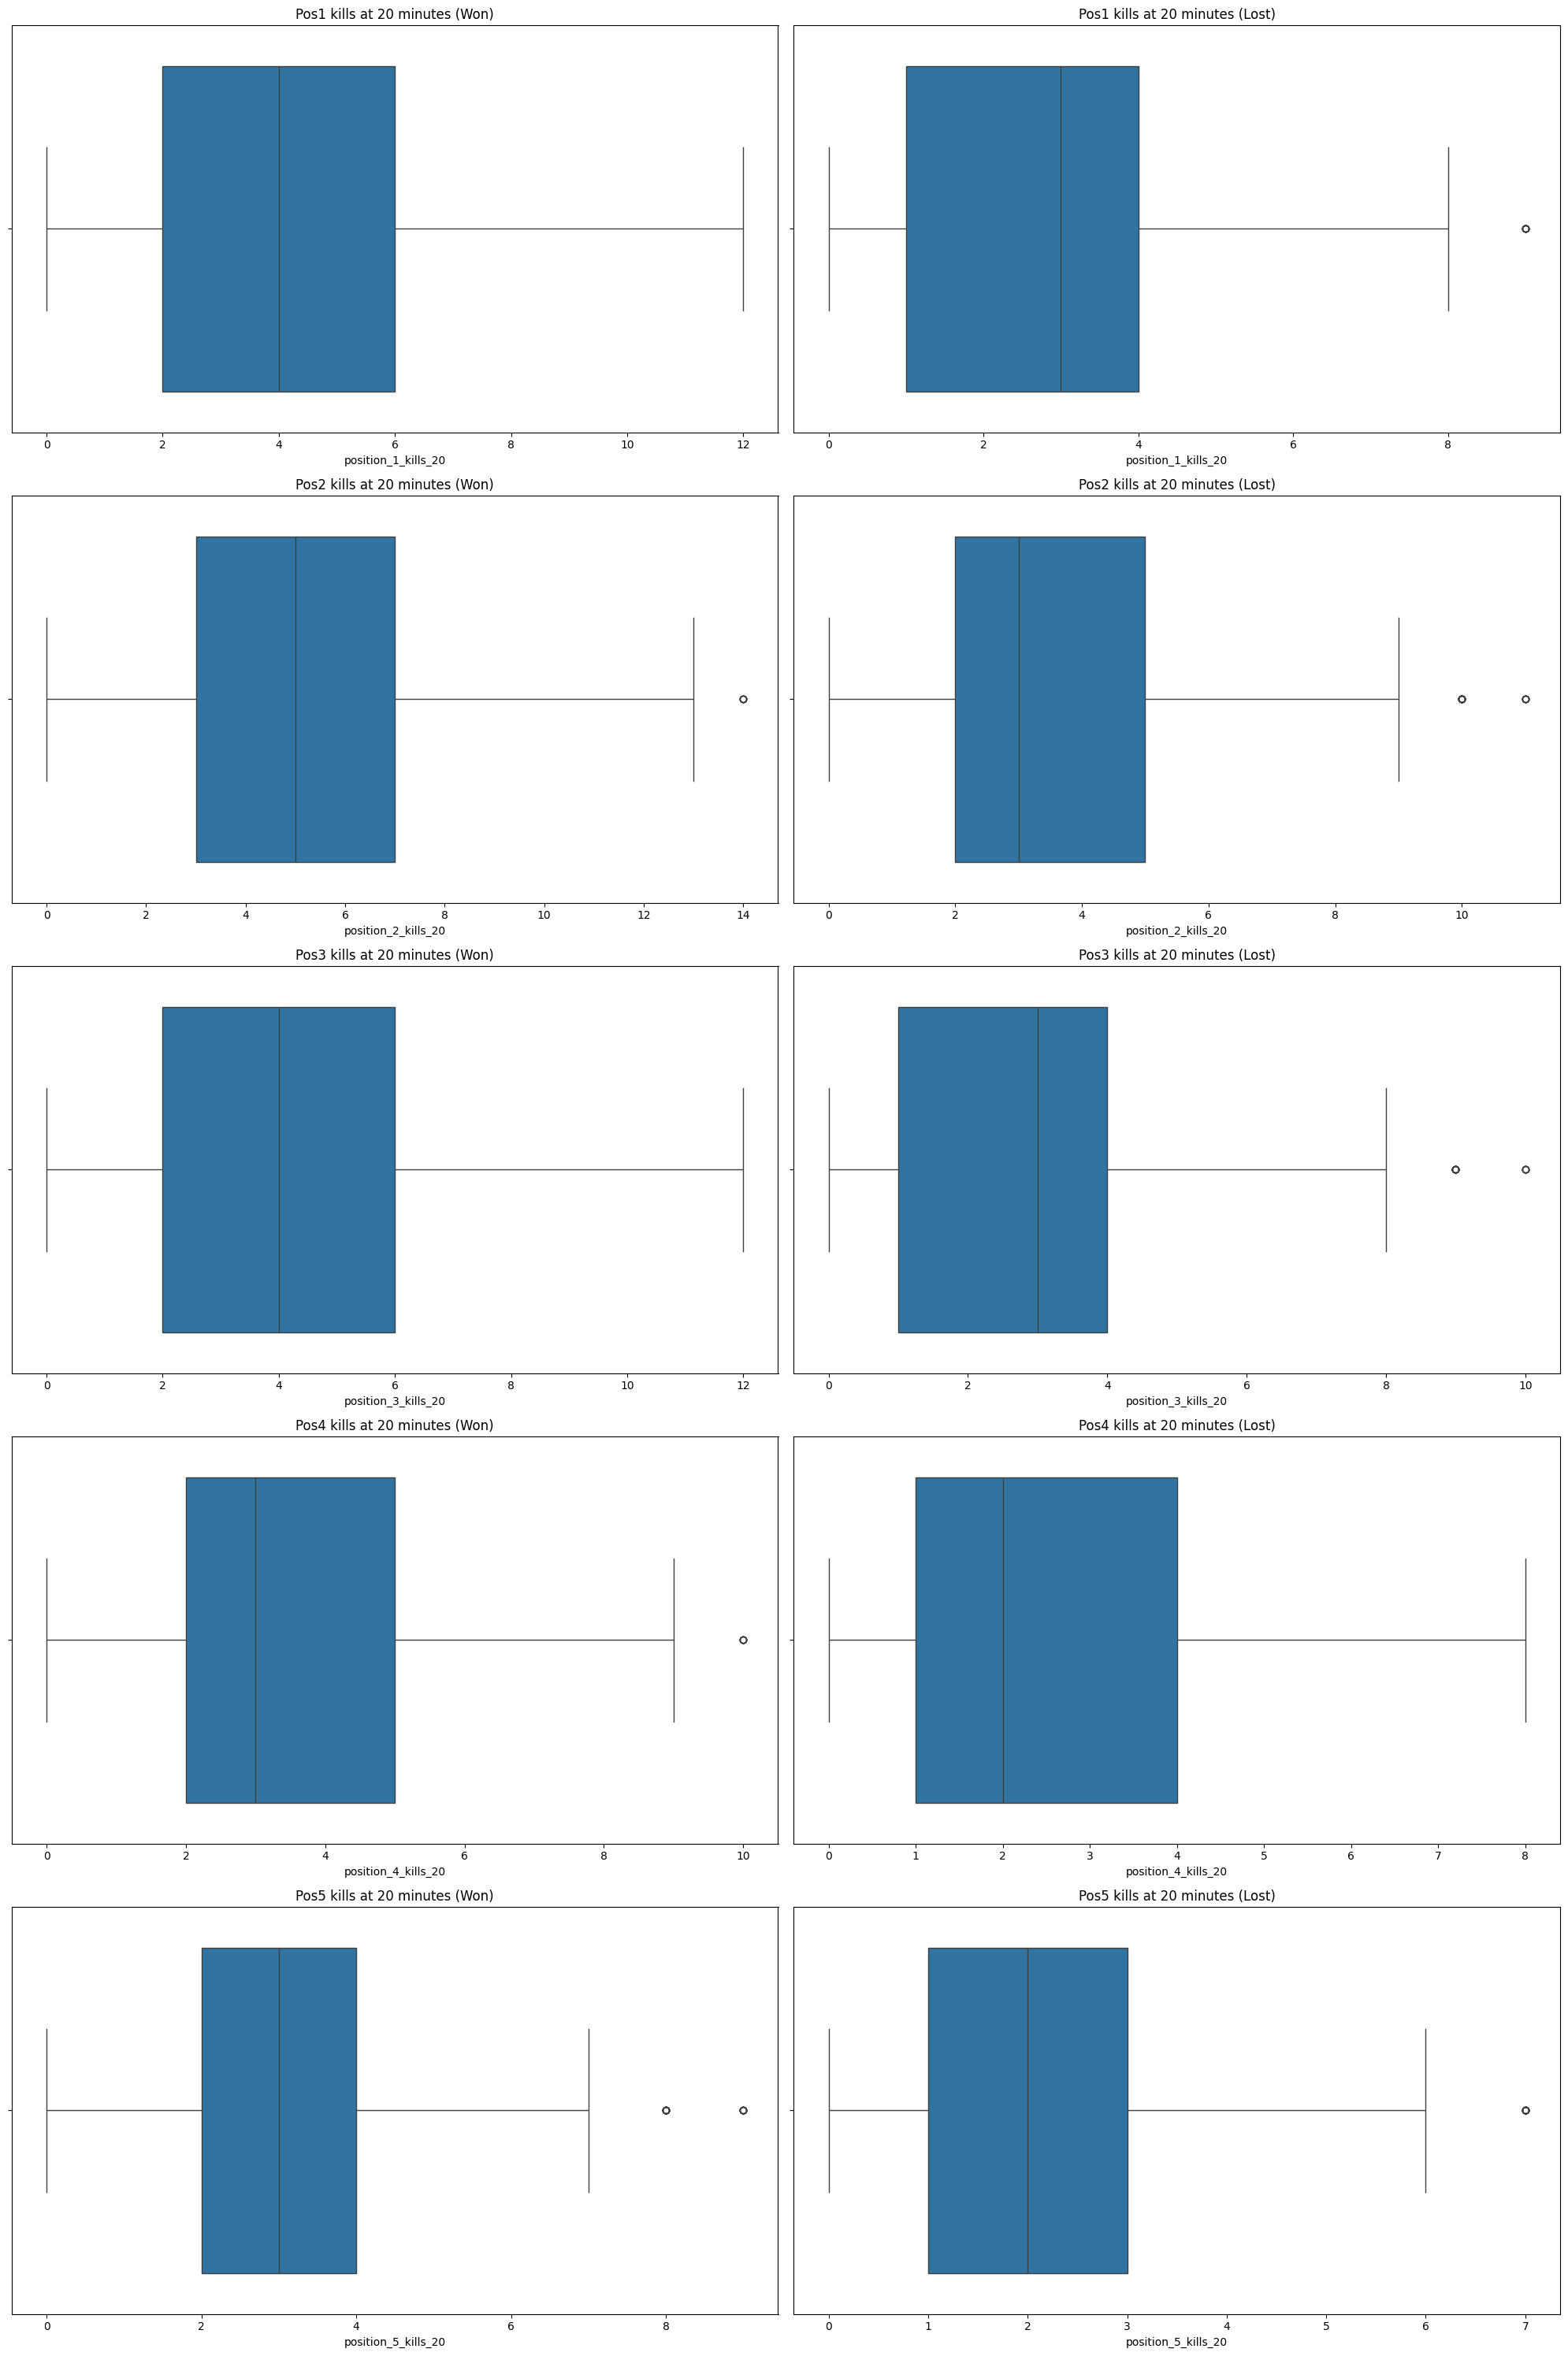

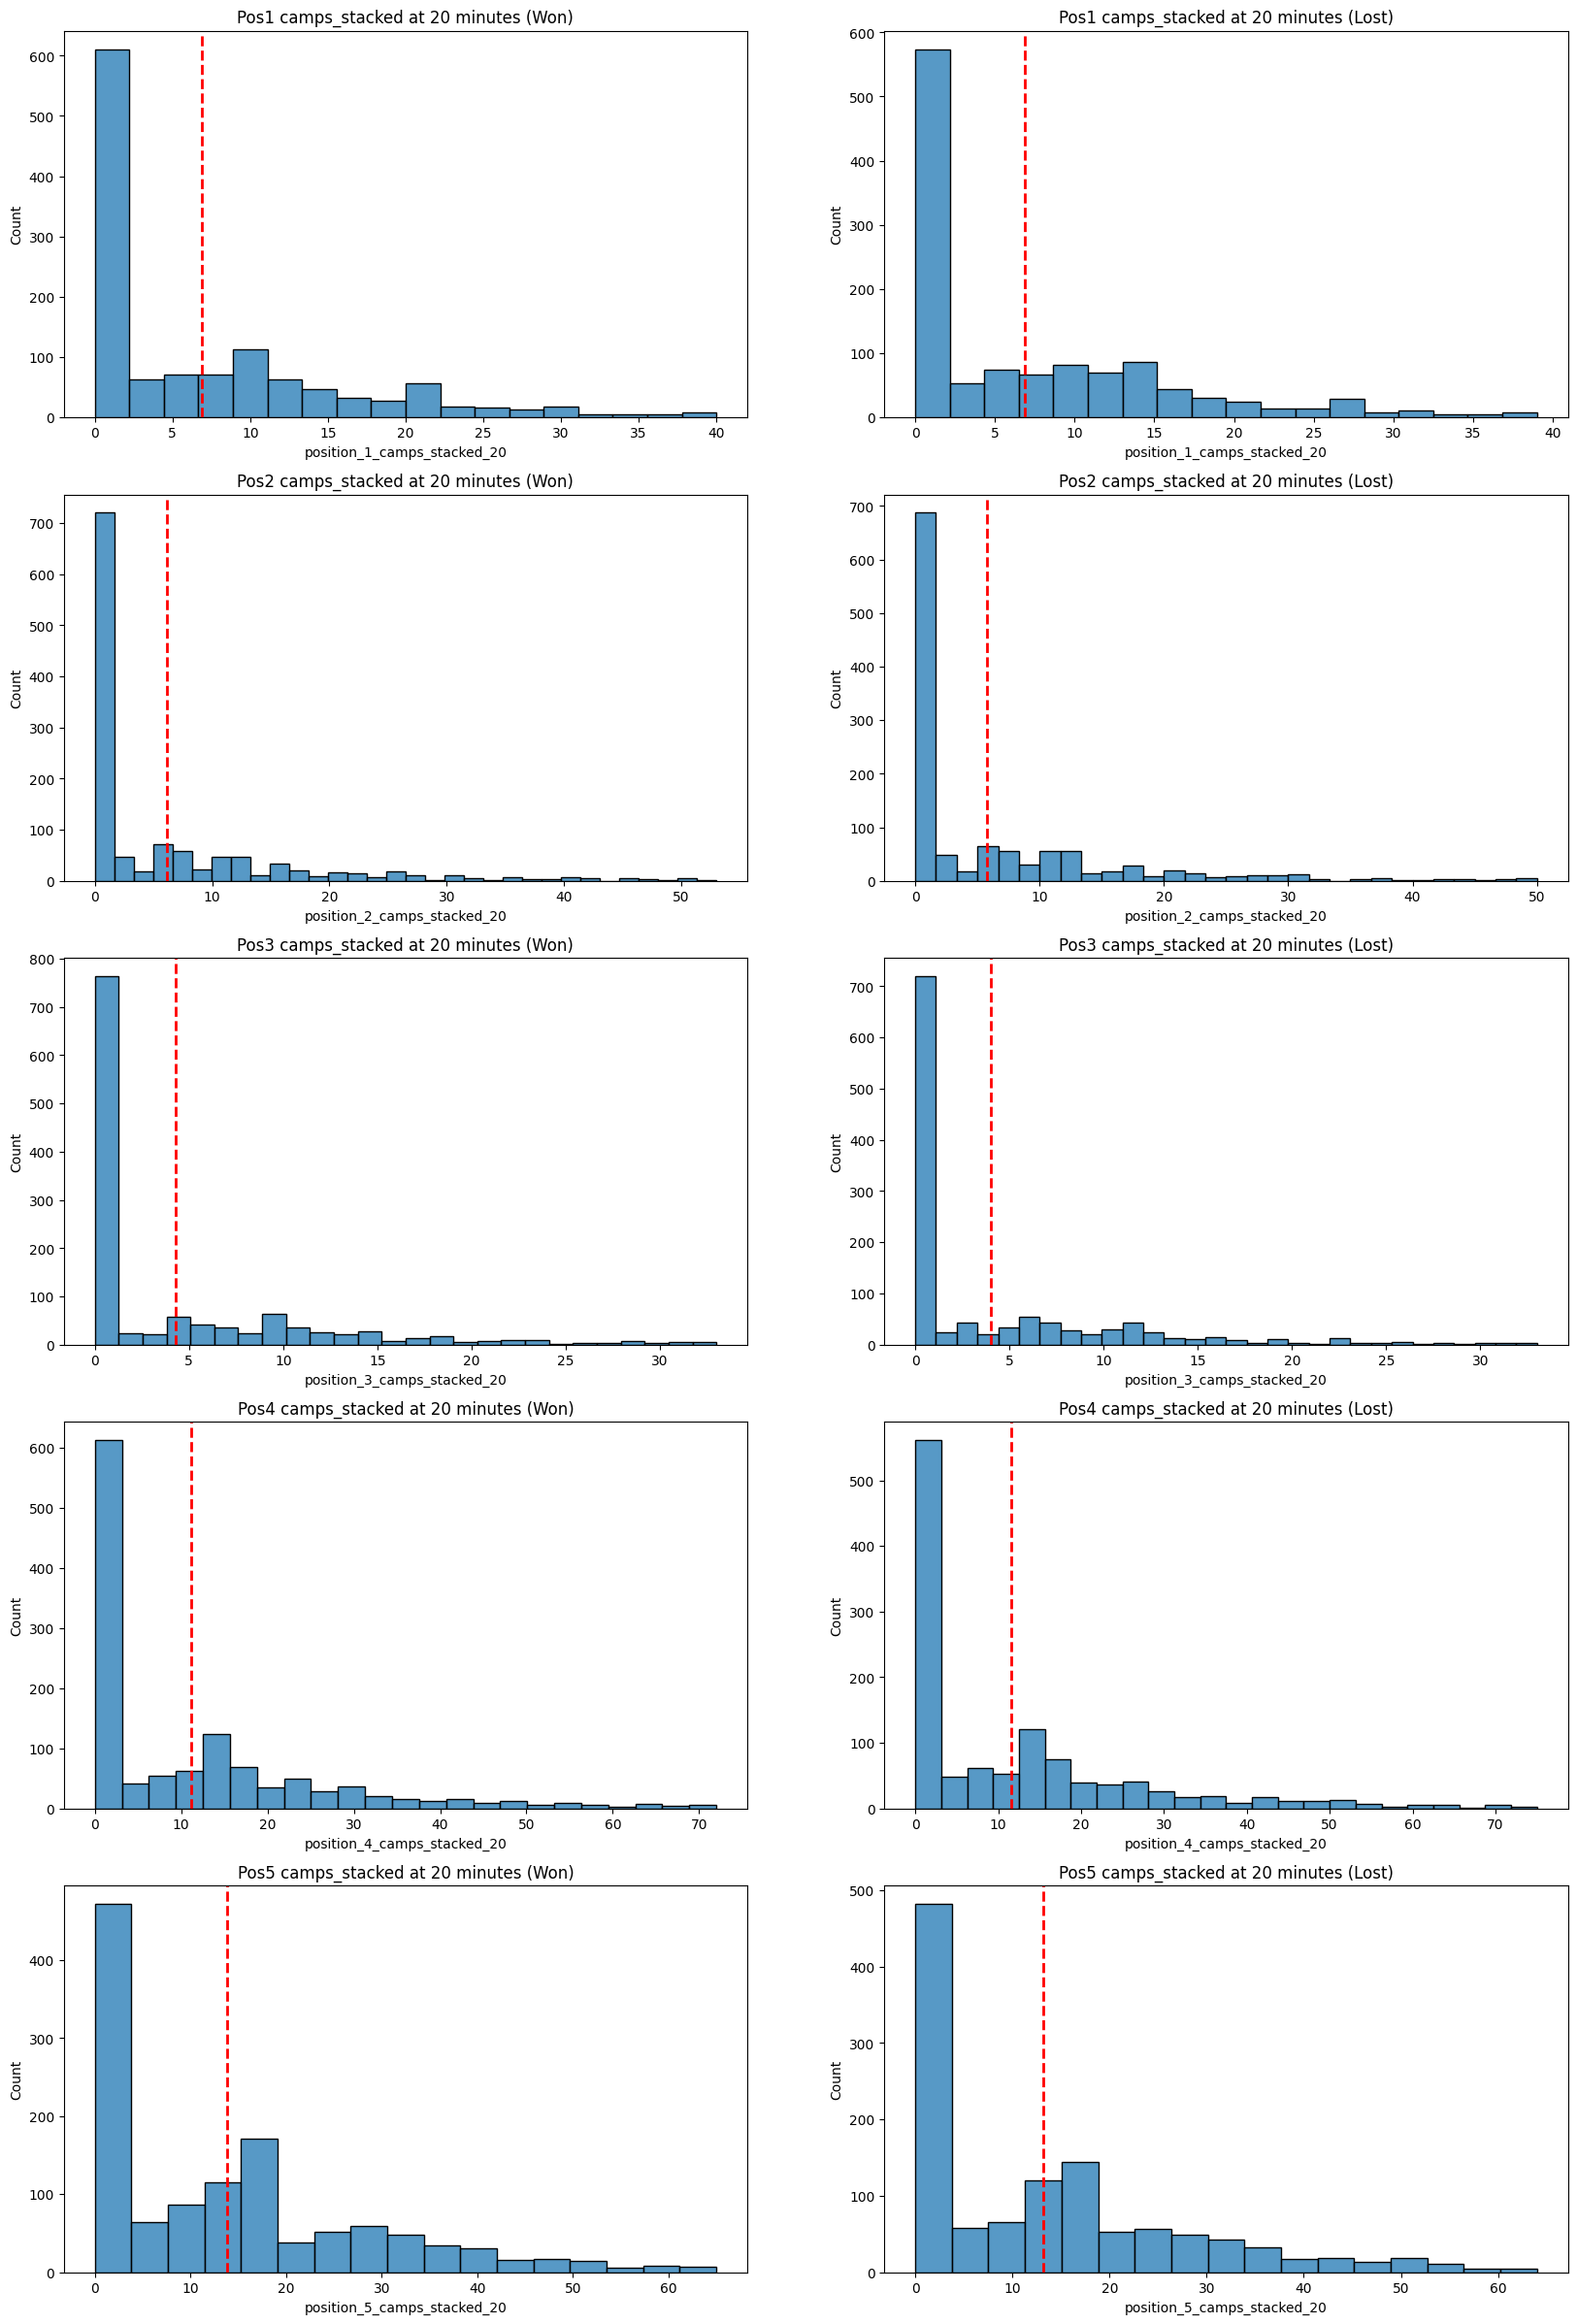

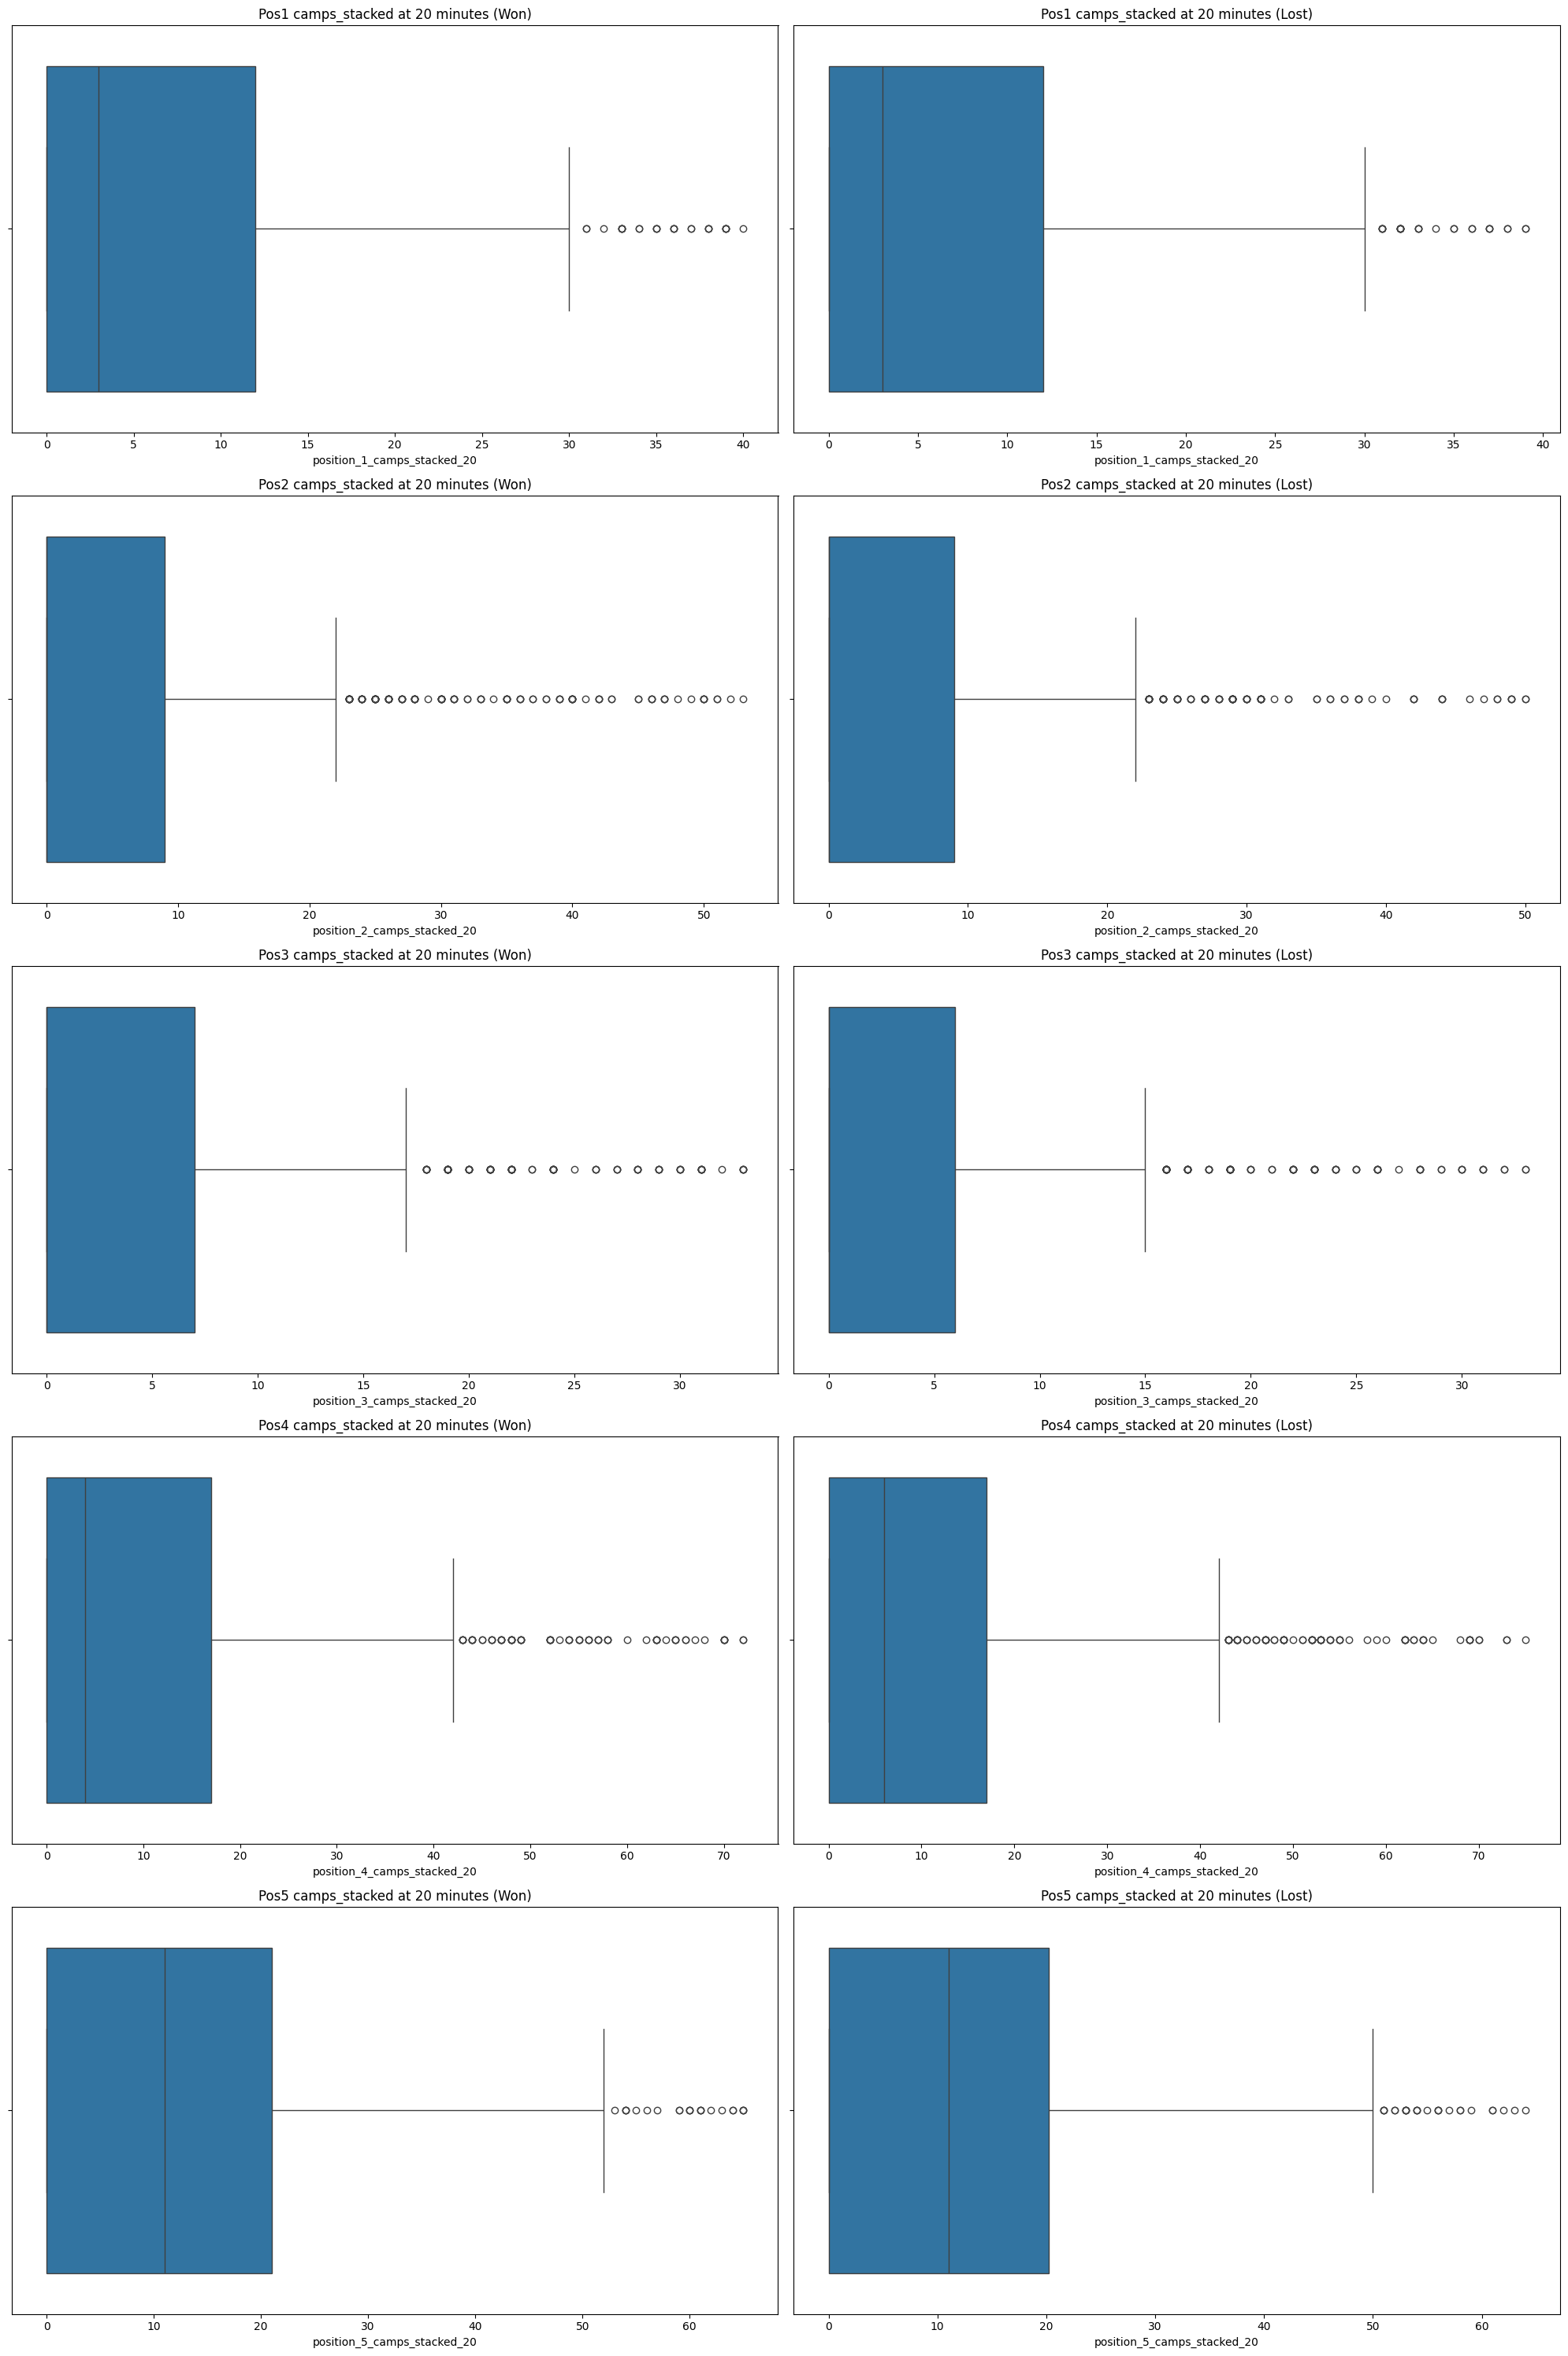

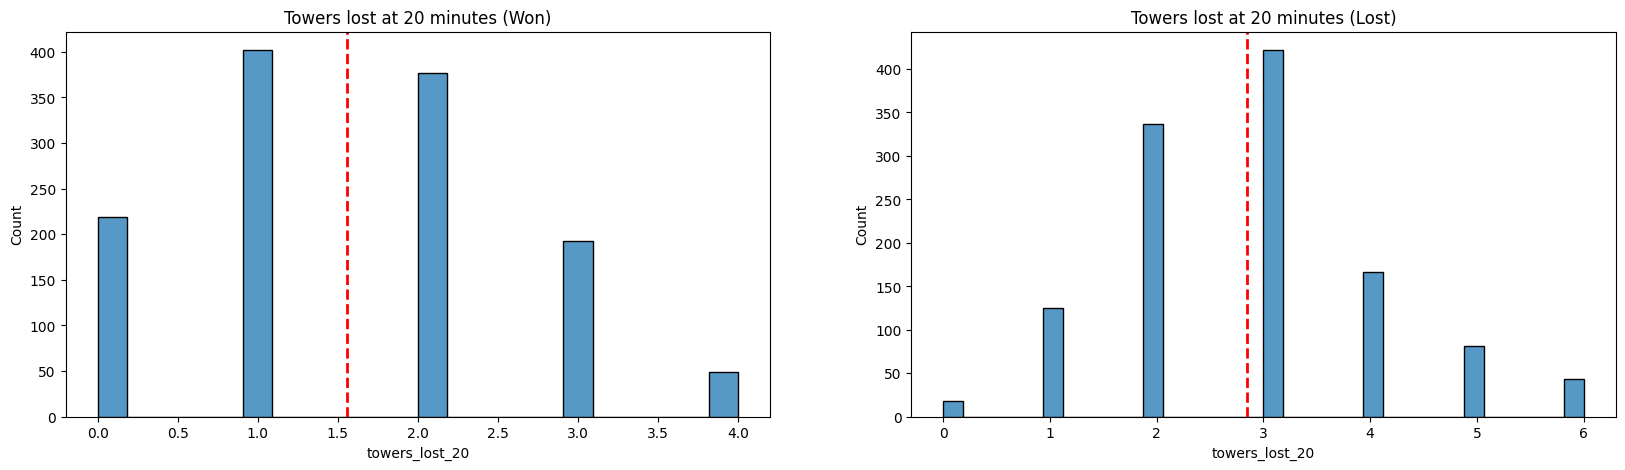

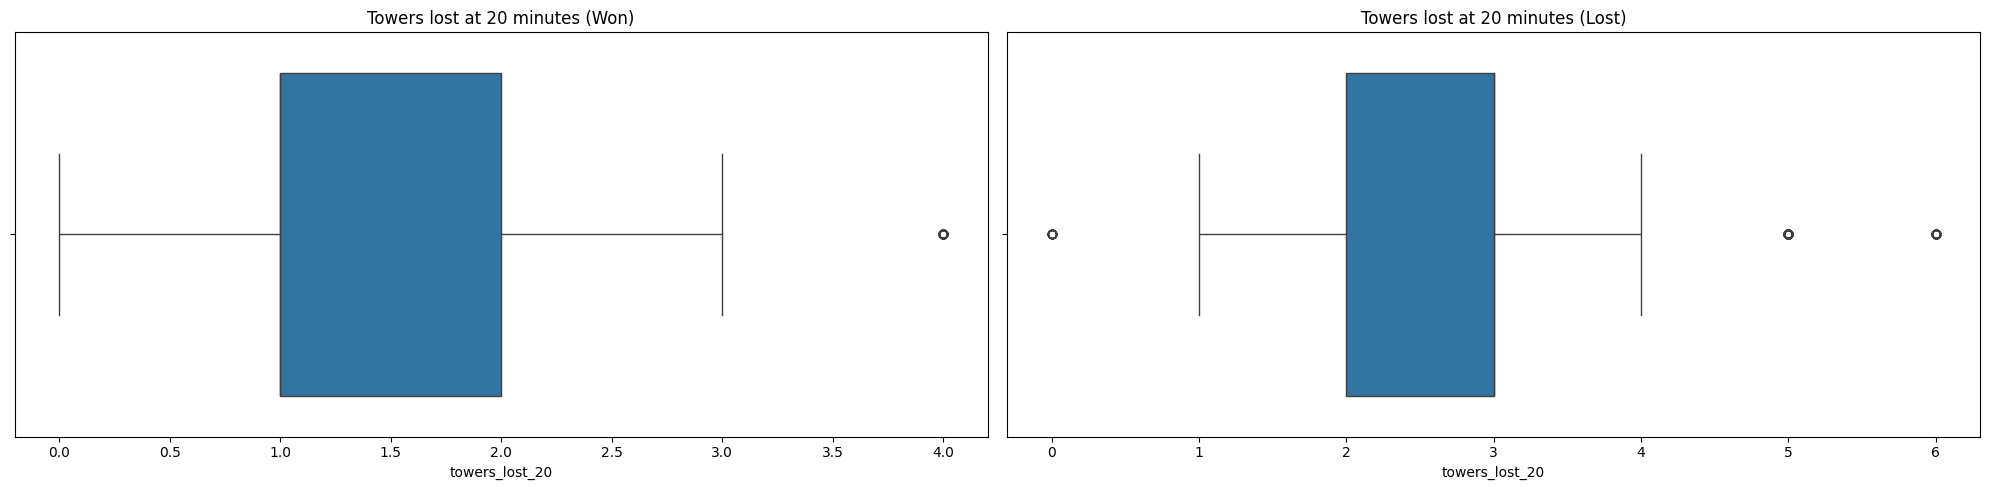

In [481]:
winner_copy, loser_copy = load_data(time=analysis_time, hero_count=hero_limit)
plot_params = [
    "networth",
    "xpm",
    "hero_damage",
    "tower_damage",
    "kills",
    "camps_stacked",
]
game_params = ["towers_lost"]
time = analysis_time

for param in plot_params:
    _, hist_axs = plt.subplots(5, 2, figsize=(20, 30))
    _, box_axs = plt.subplots(5, 2, figsize=(20, 30))
    for idx, pos in enumerate(positions):
        col = f"position_{pos}_{param}_{time}"

        # logarithmic normalization for skewed data
        # winner_copy[col] = np.log(winner_copy[col] + 1)
        # loser_copy[col] = np.log(loser_copy[col] + 1)

        # standard normalization
        # winner_copy[col] = (
        #     winner_copy[col] - winner_copy[col].mean()
        # ) / winner_copy[col].std()

        # loser_copy[col] = (
        #     loser_copy[col] - loser_copy[col].mean()
        # ) / loser_copy[col].std()

        title = f"Pos{pos} {param} at {time} minutes"

        # plot histograms
        ax = hist_axs[idx, 0]
        sns.histplot(winner_copy[col], ax=ax)
        ax.set_title(f"{title} (Won)")
        ax.axvline(
            winner_copy[col].mean(),
            color="red",
            linestyle="dashed",
            linewidth=2,
        )

        ax = hist_axs[idx, 1]
        sns.histplot(loser_copy[col], ax=ax)
        ax.set_title(f"{title} (Lost)")
        ax.axvline(
            loser_copy[col].mean(),
            color="red",
            linestyle="dashed",
            linewidth=2,
        )

        # plot boxplots
        ax = box_axs[idx, 0]
        sns.boxplot(x=winner_copy[col], ax=ax)
        ax.set_title(f"{title} (Won)")

        ax = box_axs[idx, 1]
        sns.boxplot(x=loser_copy[col], ax=ax)
        ax.set_title(f"{title} (Lost)")
    plt.tight_layout()
    plt.show()

for param in game_params:
    _, hist_axs = plt.subplots(1, 2, figsize=(20, 5))
    _, box_axs = plt.subplots(1, 2, figsize=(20, 5))
    col = f"{param}_{time}"

    # plot histograms
    ax = hist_axs[0]
    sns.histplot(winner_copy[col], ax=ax)
    ax.set_title(f"Towers lost at {time} minutes (Won)")
    ax.axvline(
        winner_copy[col].mean(),
        color="red",
        linestyle="dashed",
        linewidth=2,
    )

    ax = hist_axs[1]
    sns.histplot(loser_copy[col], ax=ax)
    ax.set_title(f"Towers lost at {time} minutes (Lost)")
    ax.axvline(
        loser_copy[col].mean(),
        color="red",
        linestyle="dashed",
        linewidth=2,
    )

    # plot boxplots
    ax = box_axs[0]
    sns.boxplot(x=winner_copy[col], ax=ax)
    ax.set_title(f"Towers lost at {time} minutes (Won)")

    ax = box_axs[1]
    sns.boxplot(x=loser_copy[col], ax=ax)
    ax.set_title(f"Towers lost at {time} minutes (Lost)")

    plt.tight_layout()
    plt.show()

### Ratios

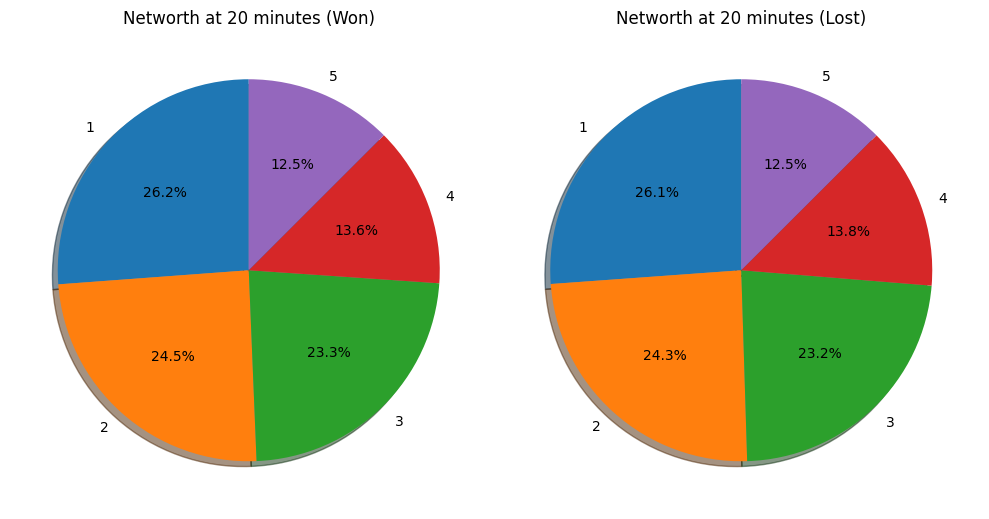

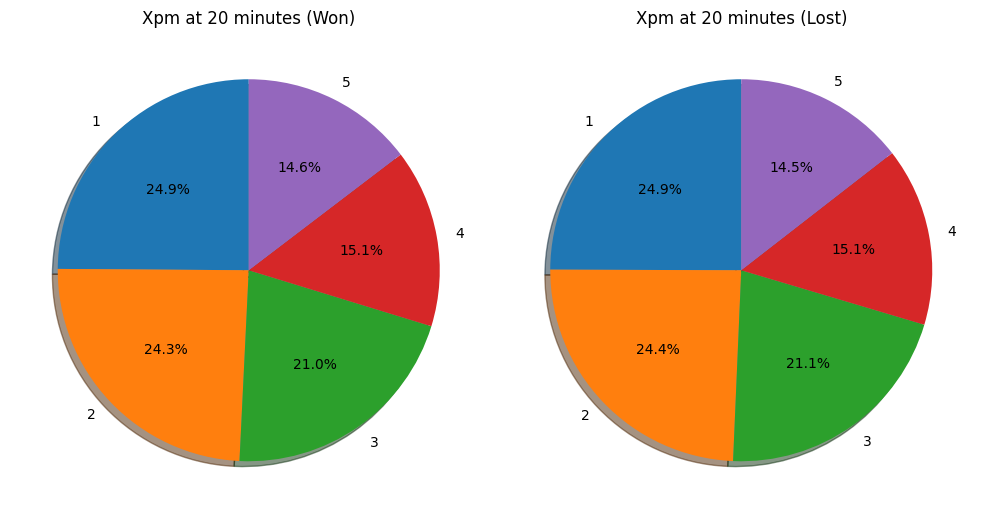

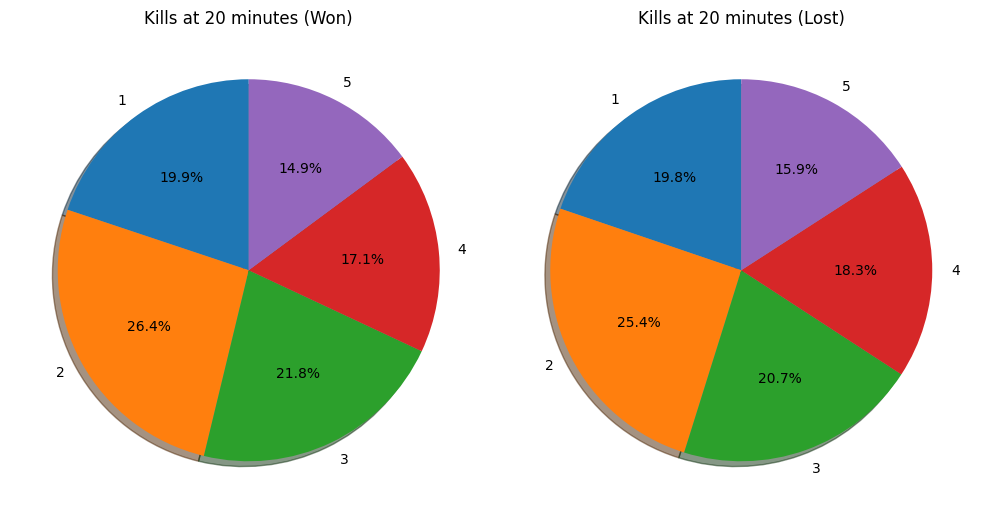

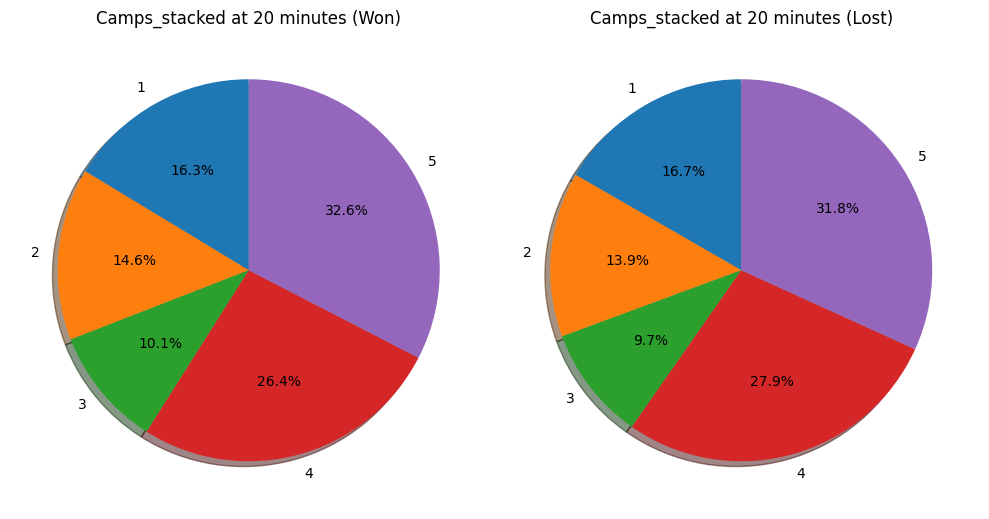

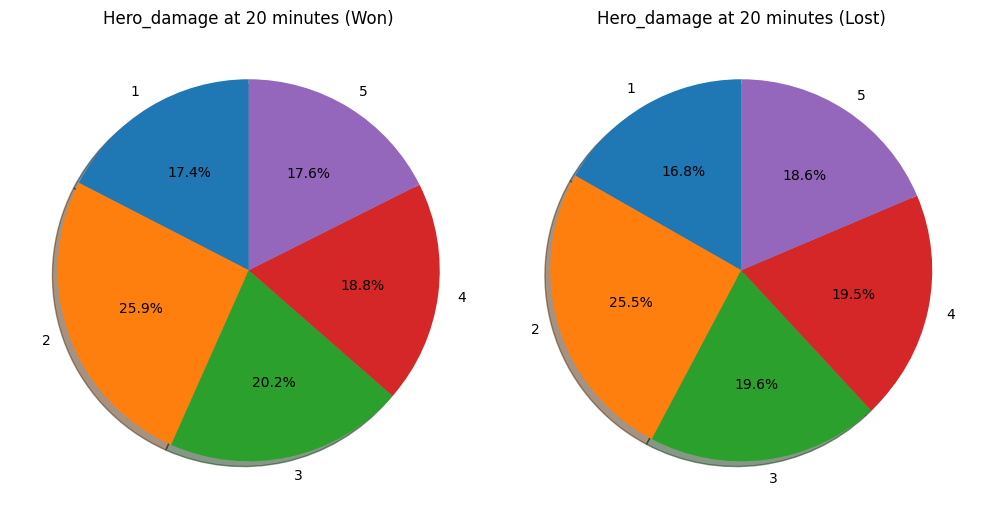

In [482]:
# plot total networth of each team as a pie chart
winner_copy = winner_data.copy(deep=True)
loser_copy = loser_data.copy(deep=True)
player_params = ["networth", "xpm", "kills", "camps_stacked", "hero_damage"]
time = analysis_time

for param in player_params:
    _, pie_axs = plt.subplots(1, 2, figsize=(10, 10))
    winner_pie = {}
    loser_pie = {}
    for pos in positions:
        col = f"position_{pos}_{param}_{time}"
        winner_pie[pos] = winner_copy[col].mean()
        loser_pie[pos] = loser_copy[col].mean()

    title = f"{param.capitalize()} at {time} minutes"
    # plot winner data
    ax = pie_axs[0]
    ax.pie(
        winner_pie.values(),
        labels=winner_pie.keys(),
        autopct="%1.1f%%",
        shadow=True,
        startangle=90,
    )
    ax.set_title(f"{title} (Won)")

    # plot loser data
    ax = pie_axs[1]
    ax.pie(
        loser_pie.values(),
        labels=loser_pie.keys(),
        autopct="%1.1f%%",
        shadow=True,
        startangle=90,
    )
    ax.set_title(f"{title} (Lost)")
    plt.tight_layout()
    plt.show()

### Correlations

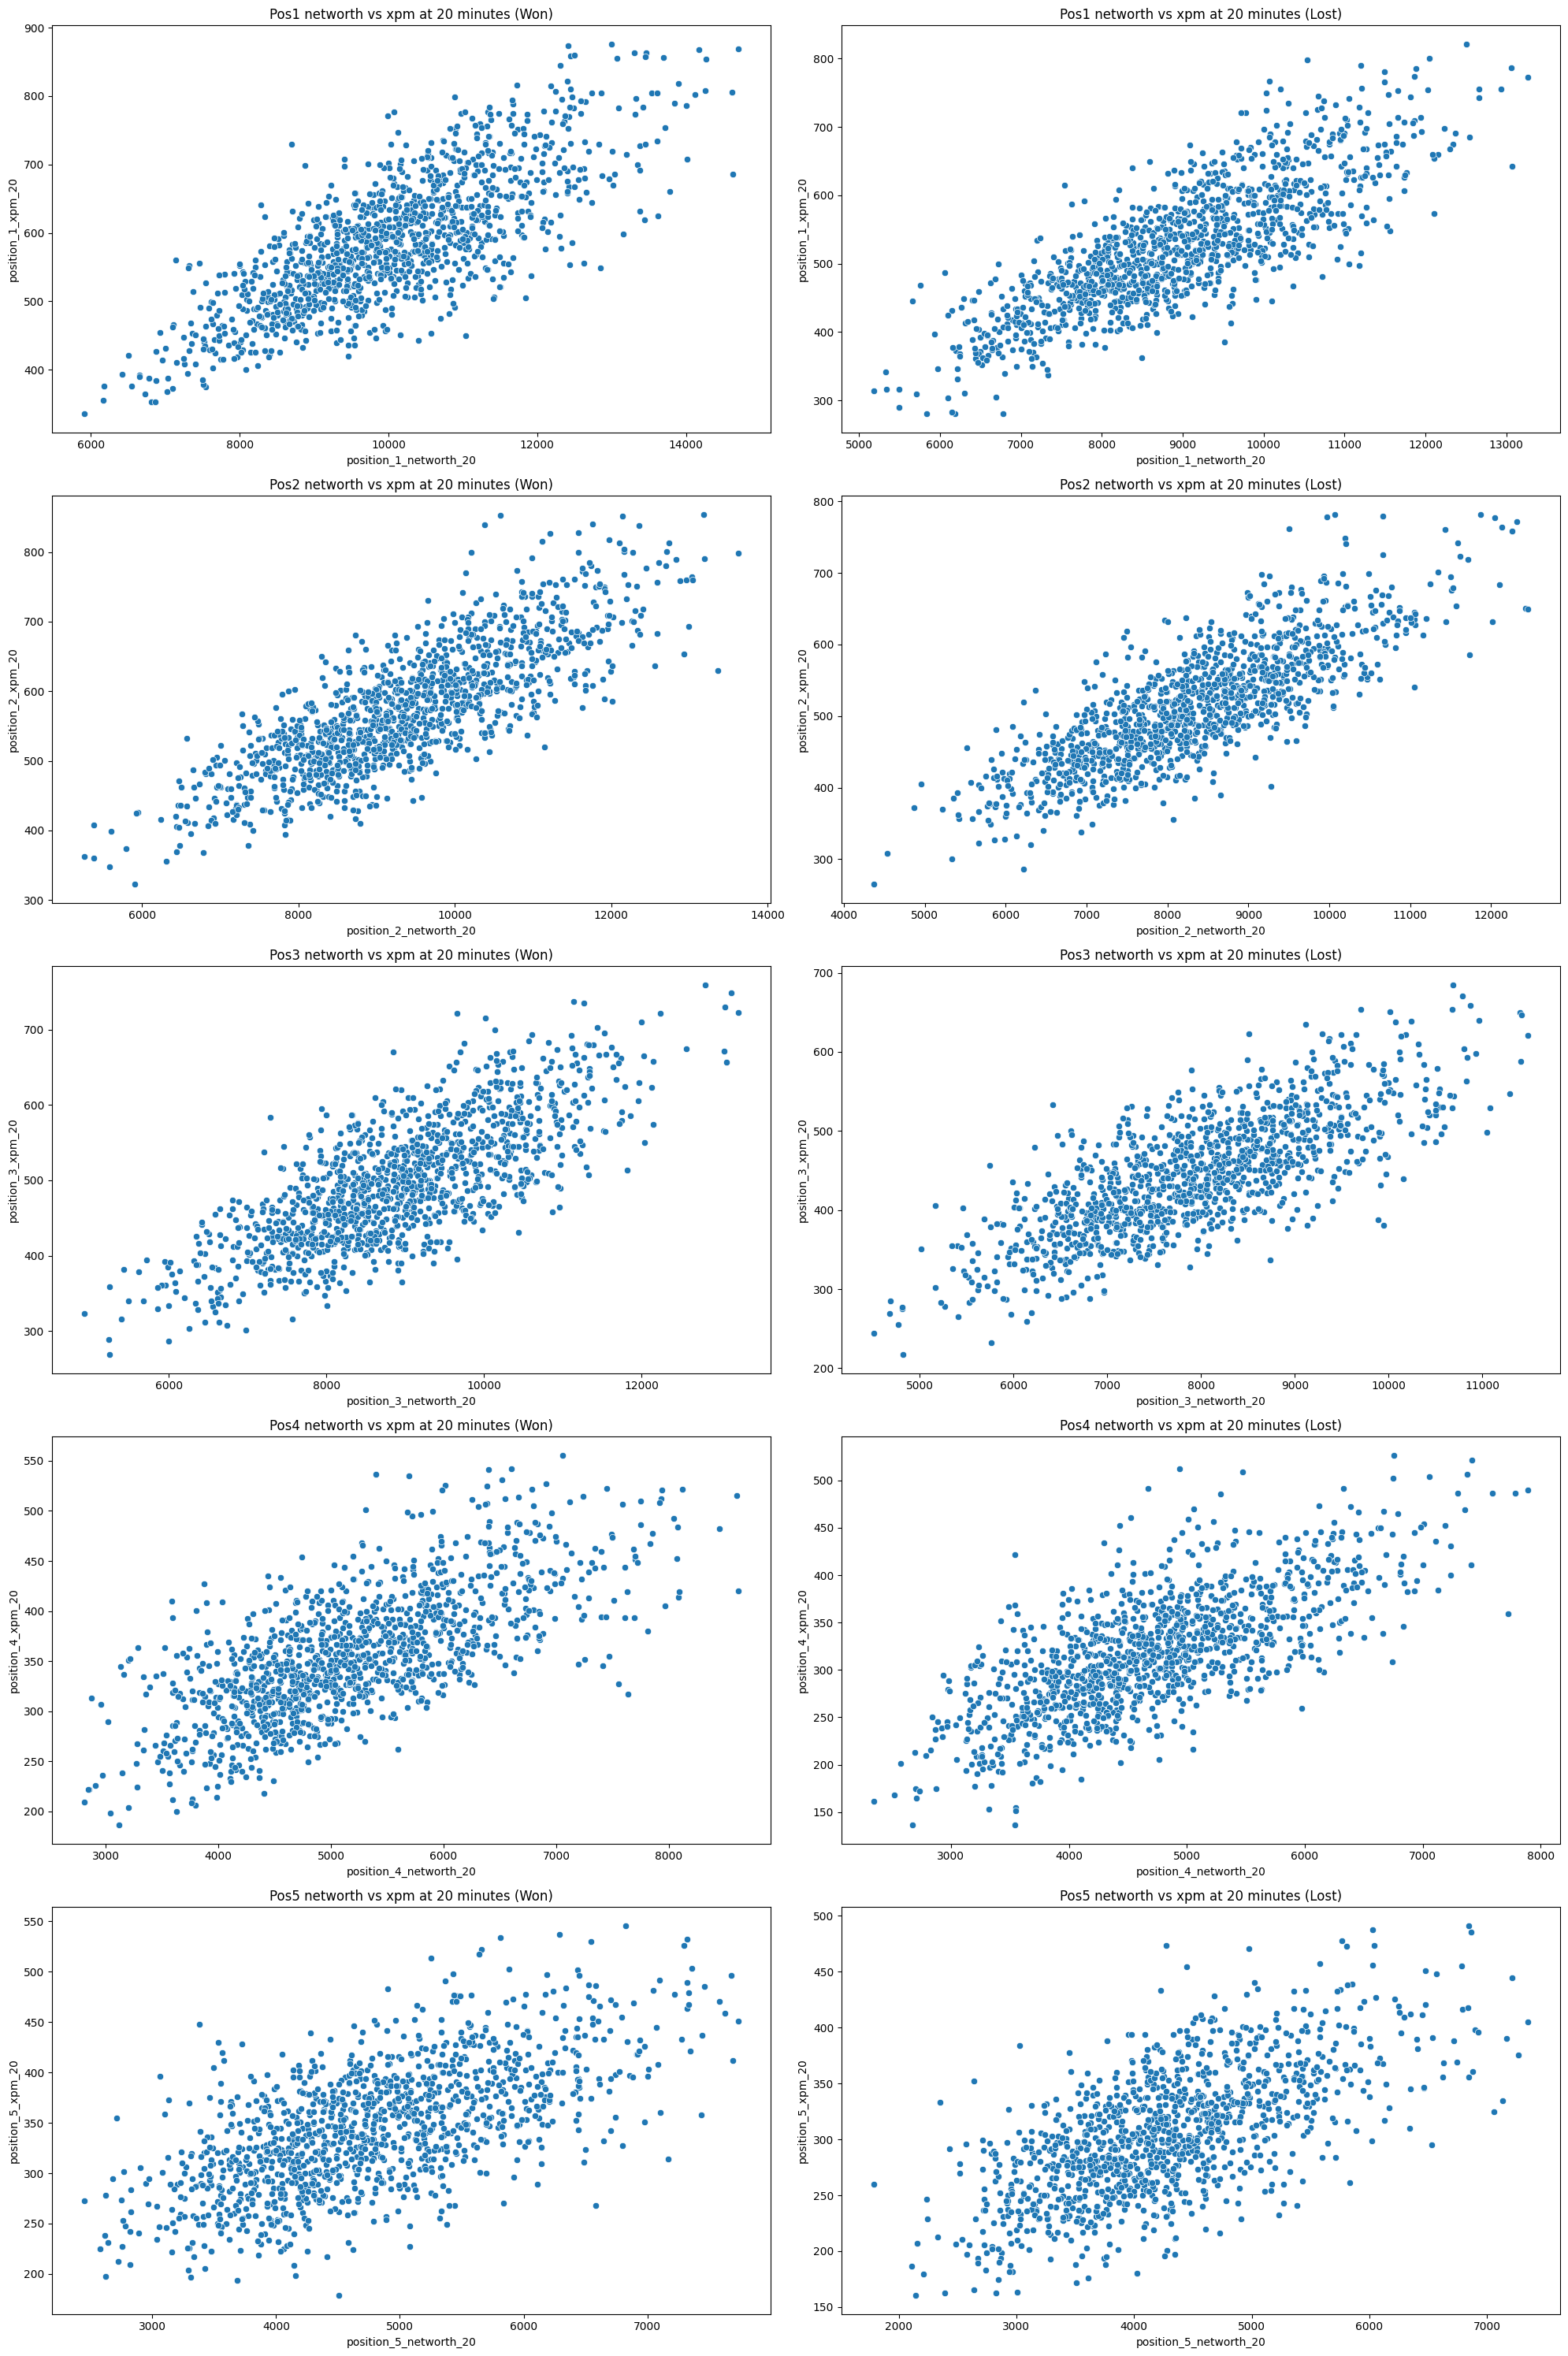

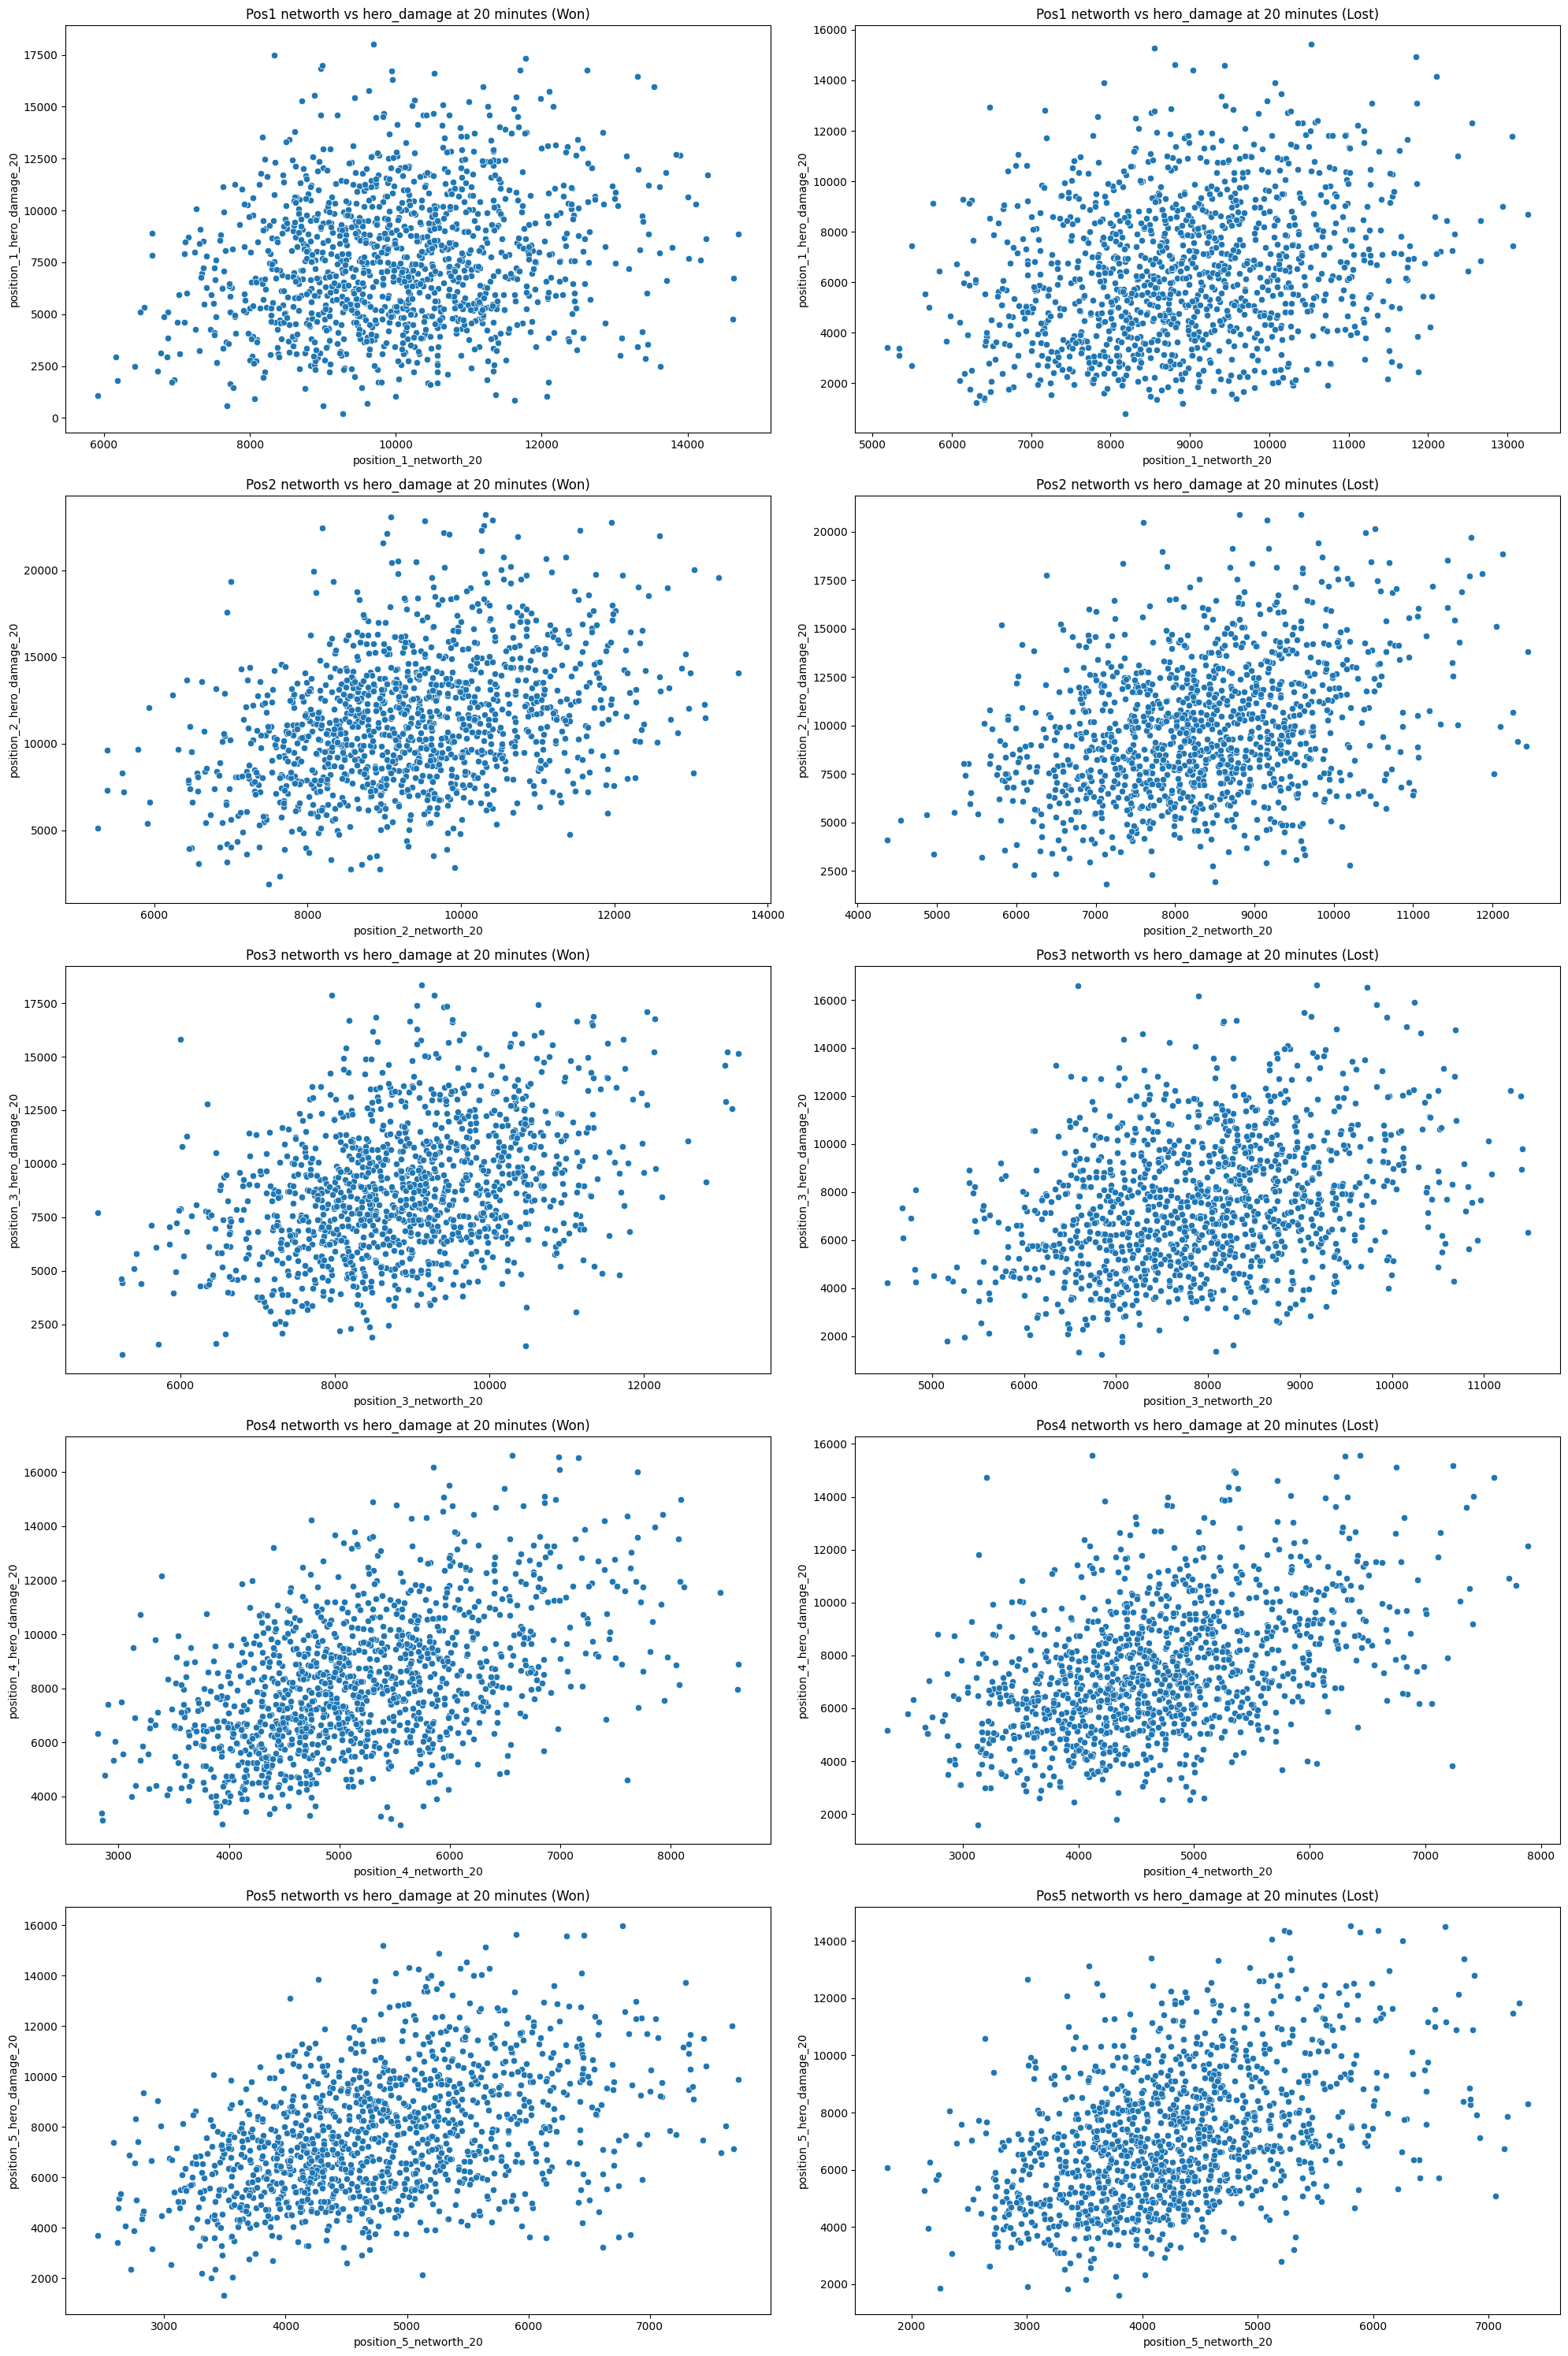

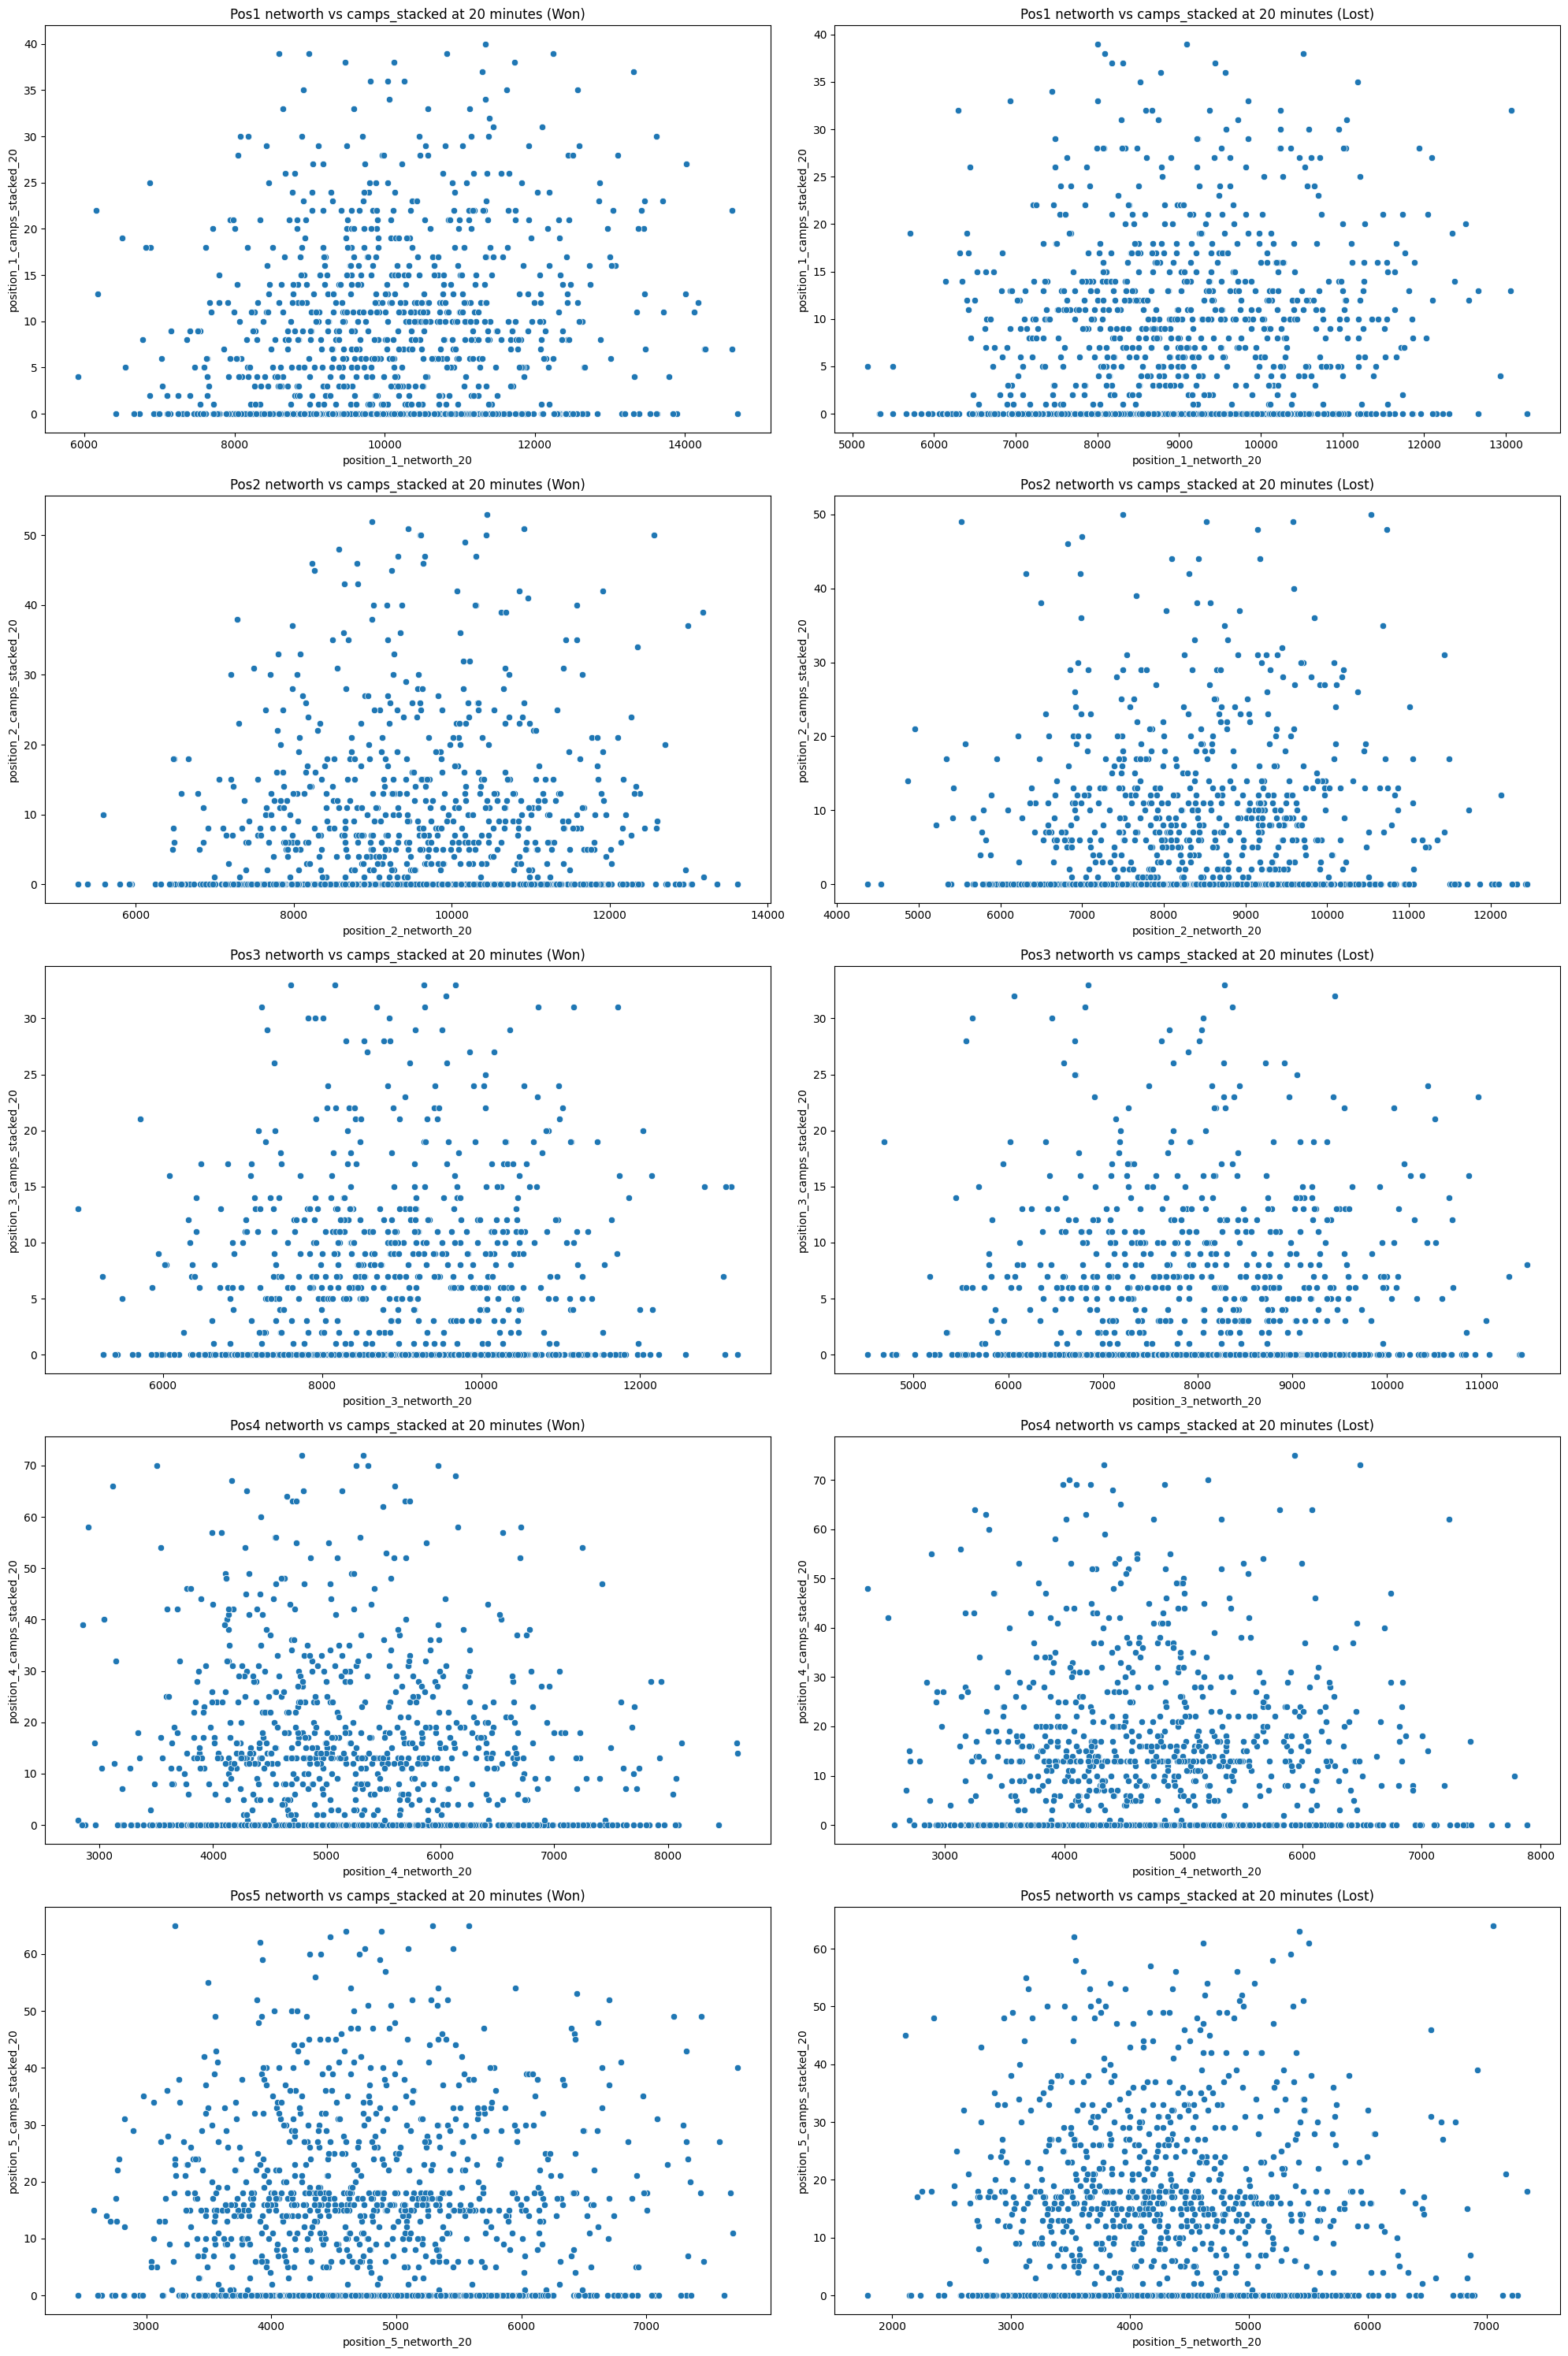

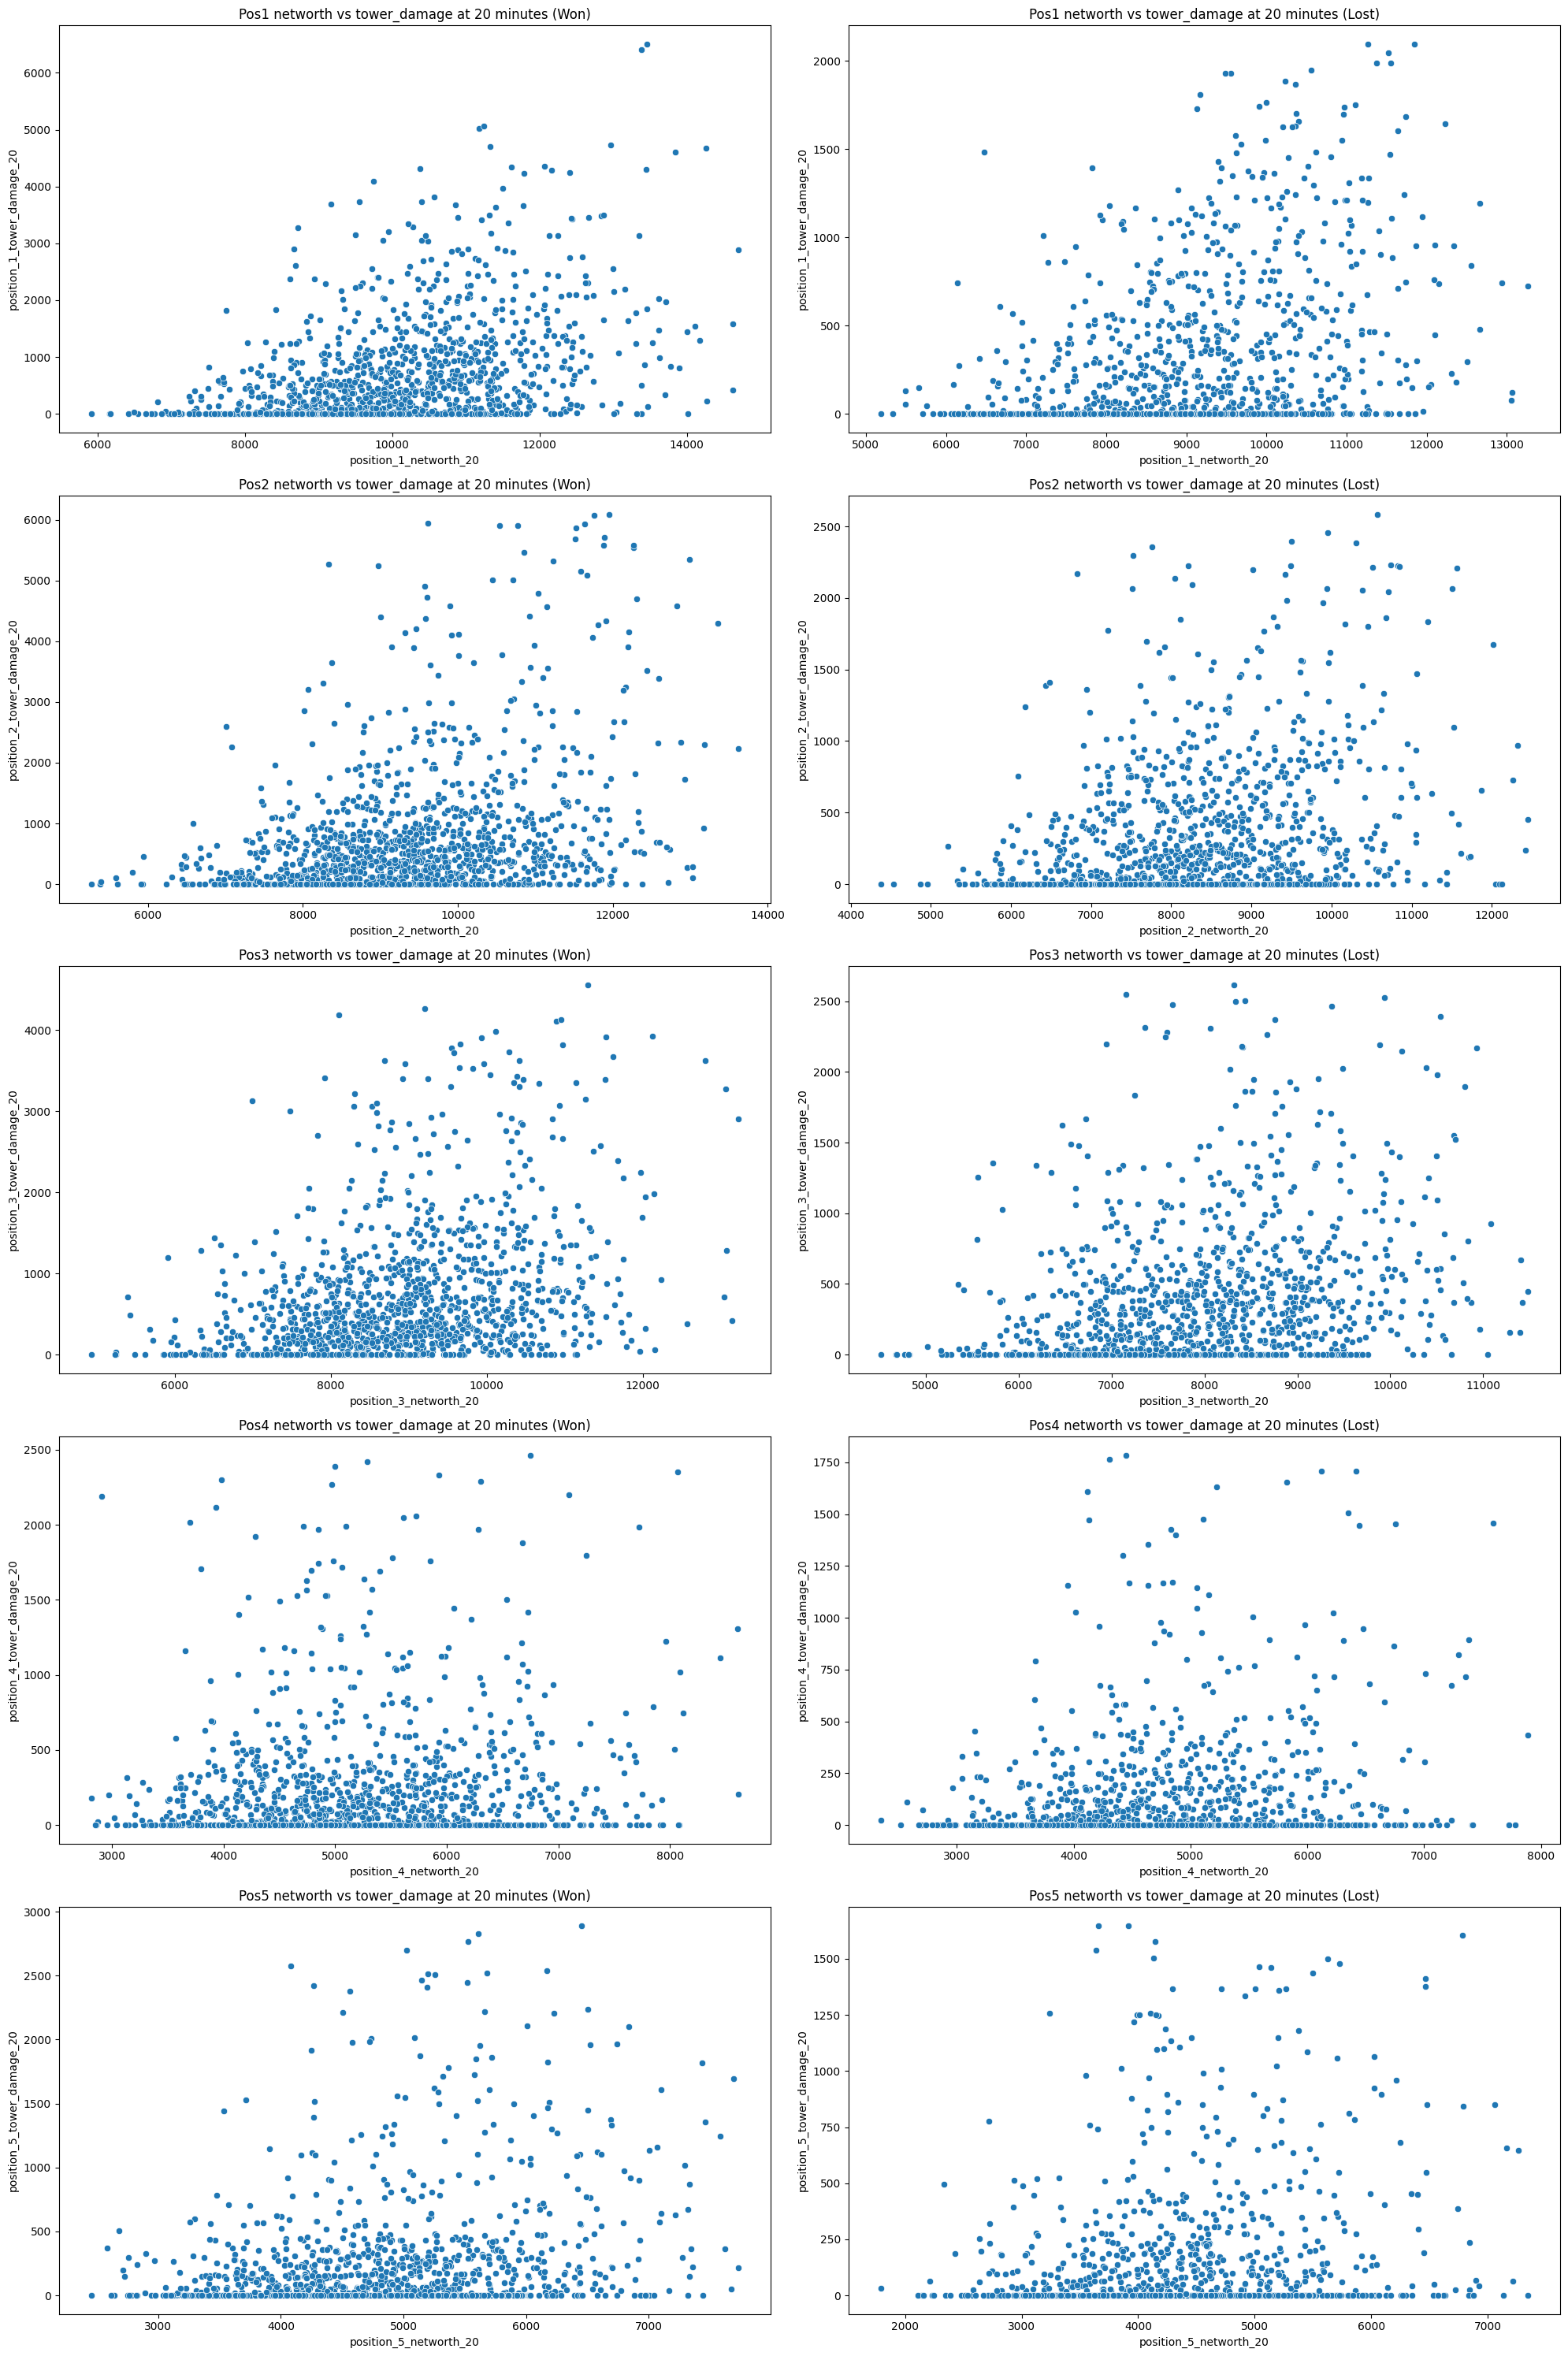

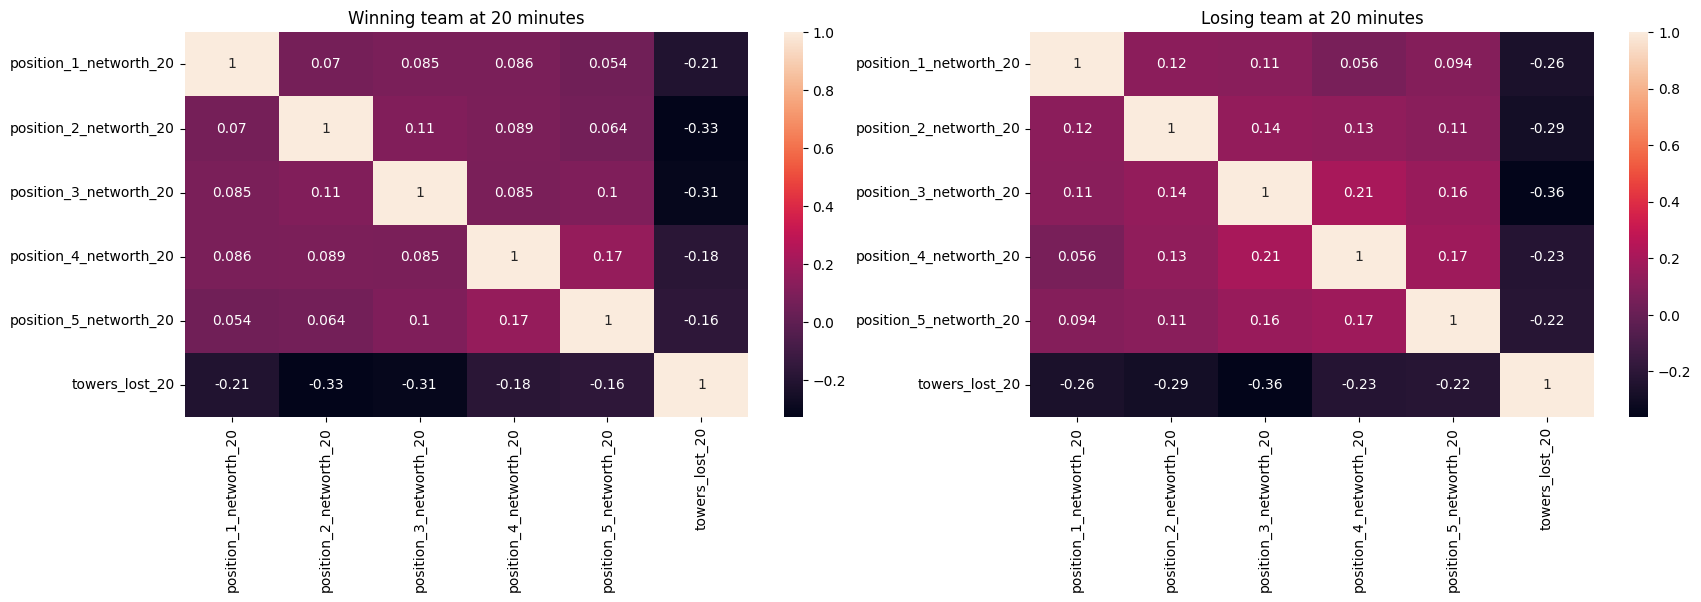

In [483]:
# plot total networth of each team as a pie chart
winner_copy = winner_data.copy(deep=True)
loser_copy = loser_data.copy(deep=True)
main_param = "networth"
player_params = ["xpm", "hero_damage", "camps_stacked", "tower_damage"]
game_params = ["towers_lost"]
time = analysis_time

for param in player_params:
    _, scatter_axs = plt.subplots(5, 2, figsize=(20, 30))
    for idx, pos in enumerate(positions):
        col = f"position_{pos}_{param}_{time}"
        main_col = f"position_{pos}_{main_param}_{time}"
        title = f"Pos{pos} {main_param} vs {param} at {time} minutes"

        # plot scatter plots
        ax = scatter_axs[idx, 0]
        sns.scatterplot(
            x=winner_copy[main_col],
            y=winner_copy[col],
            ax=ax,
        )
        ax.set_title(f"{title} (Won)")

        ax = scatter_axs[idx, 1]
        sns.scatterplot(
            x=loser_copy[main_col],
            y=loser_copy[col],
            ax=ax,
        )
        ax.set_title(f"{title} (Lost)")
    plt.tight_layout()

# plot a heatmap of correlations
plot_params = ["networth"]
game_params = ["towers_lost"]
heatmap_cols = []

for param in plot_params:
    for pos in positions:
        col = f"position_{pos}_{param}_{time}"
        heatmap_cols.append(col)

for param in game_params:
    col = f"{param}_{time}"
    heatmap_cols.append(col)

winner_hmap = winner_copy[heatmap_cols]
loser_hmap = loser_copy[heatmap_cols]

_, ax = plt.subplots(1, 2, figsize=(20, 5))
sns.heatmap(winner_hmap.corr(), annot=True, ax=ax[0])
ax[0].set_title(f"Winning team at {time} minutes")

sns.heatmap(loser_hmap.corr(), annot=True, ax=ax[1])
ax[1].set_title(f"Losing team at {time} minutes")
plt.show()

### Predictor analysis
**T-tests for individual predictors**

In [484]:
winner_copy, loser_copy = load_data(time=analysis_time, hero_count=hero_limit)
player_params = ["networth", "hero_damage", "camps_stacked", "tower_damage", "xpm", "kills"]
game_params = ["towers_lost"]


p_values = {}
time = analysis_time
for param in player_params:
    for pos in positions:
        col = f"position_{pos}_{param}_{time}"
        winner_col = winner_copy[col]
        loser_col = loser_copy[col]
        t, p = stats.ttest_ind(winner_col, loser_col, equal_var=False)
        p_values[col] = p

for param in game_params:
    col = f"{param}_{time}"
    winner_col = winner_copy[col]
    loser_col = loser_copy[col]
    t, p = stats.ttest_ind(winner_col, loser_col, equal_var=False)
    p_values[col] = p

# for param in category_params:
#     col = param
#     winner_col = winner_copy[col]
#     loser_col = loser_copy[col]
#     t, p = stats.ttest_ind(winner_col, loser_col, equal_var=False)
#     p_values[col] = p

p_values = pd.DataFrame.from_dict(p_values, orient="index", columns=["p-value"])
print(p_values)

(1239, 36) (1192, 36)
                                   p-value
position_1_networth_20        1.691768e-77
position_2_networth_20        3.967226e-80
position_3_networth_20        1.398963e-77
position_4_networth_20        2.300846e-36
position_5_networth_20        5.341578e-41
position_1_hero_damage_20     1.045274e-21
position_2_hero_damage_20     6.991893e-25
position_3_hero_damage_20     1.378263e-26
position_4_hero_damage_20     4.668537e-13
position_5_hero_damage_20     6.717947e-08
position_1_camps_stacked_20   9.308508e-01
position_2_camps_stacked_20   3.010314e-01
position_3_camps_stacked_20   2.756412e-01
position_4_camps_stacked_20   5.728522e-01
position_5_camps_stacked_20   2.573183e-01
position_1_tower_damage_20    1.096244e-42
position_2_tower_damage_20    7.370176e-38
position_3_tower_damage_20    1.915226e-34
position_4_tower_damage_20    8.024081e-19
position_5_tower_damage_20    3.262213e-13
position_1_xpm_20             8.957760e-57
position_2_xpm_20             2.

### Model fitting

In [513]:
winner_copy, loser_copy = load_data(time=analysis_time, hero_count=60)

player_params = ["networth"]
game_params = ["towers_lost"]

time = analysis_time
model_params = []

for param in player_params:
    for pos in positions:
        col = f"position_{pos}_{param}_{time}"
        model_params.append(col)

for param in game_params:
    col = f"{param}_{time}"
    model_params.append(col)

# winner_copy["interaction"] = winner_copy["position_1_networth_20"] * winner_copy["towers_lost_20"]
# loser_copy["interaction"] = loser_copy["position_1_networth_20"] * loser_copy["towers_lost_20"]
# model_params.append("interaction")

# logarithmic normalization for skewed data
winner_copy[model_params] = np.log(winner_copy[model_params] + 1)
loser_copy[model_params] = np.log(loser_copy[model_params] + 1)

# standard normalization
# winner_copy[model_params] = (
#     winner_copy[model_params] - winner_copy[model_params].mean()
# ) / winner_copy[model_params].std()

# loser_copy[model_params] = (
#     loser_copy[model_params] - loser_copy[model_params].mean()
# ) / loser_copy[model_params].std()

# add result column
model_params.append("result")
winner_copy["result"] = 1
loser_copy["result"] = 0

# combine data
game_data = pd.concat([winner_copy, loser_copy], axis=0)
# game_data["result"] = game_data["result"].astype("category")
game_data = game_data[model_params]

game_data.head()

# game_data = game_data.dropna()
# print(game_data.describe(include="all"))

# fit a model
X = game_data.drop("result", axis=1)
Y = game_data["result"]

# add constant
X = sm.add_constant(X)
model = sm.Logit(Y, X).fit()
print(model.summary())
print("AIC:", model.aic)
print("BIC:", model.bic)


(2242, 36) (2149, 36)
Optimization terminated successfully.
         Current function value: 0.489963
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 result   No. Observations:                 4391
Model:                          Logit   Df Residuals:                     4384
Method:                           MLE   Df Model:                            6
Date:                Fri, 08 Dec 2023   Pseudo R-squ.:                  0.2929
Time:                        08:49:06   Log-Likelihood:                -2151.4
converged:                       True   LL-Null:                       -3042.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   -107.1492      4.694    -22.825      0

### Multi-collinearity test


In [507]:
# Assuming X is your predictors DataFrame
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [
    variance_inflation_factor(X.values, i) for i in range(len(X.columns))
]
print(vif_data)

                  feature           VIF
0                   const  10715.797253
1  position_1_networth_20      1.197780
2  position_2_networth_20      1.201405
3  position_3_networth_20      1.259943
4  position_4_networth_20      1.183073
5  position_5_networth_20      1.160273
6          towers_lost_20      1.558813


### Goodness of the fit

In [508]:
# Pseudo R-squared
print("Pseudo R-squared:", model.prsquared)

# Making predictions
predictions = model.predict(sm.add_constant(X))
predictions_binary = [1 if x > 0.5 else 0 for x in predictions]

# Confusion Matrix
conf_matrix = confusion_matrix(Y, predictions_binary)
print("Confusion Matrix:\n", conf_matrix)

# Classification Report
class_report = classification_report(Y, predictions_binary)
print("Classification Report:\n", class_report)

Pseudo R-squared: 0.29290404099266165
Confusion Matrix:
 [[1605  544]
 [ 512 1730]]
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.75      0.75      2149
           1       0.76      0.77      0.77      2242

    accuracy                           0.76      4391
   macro avg       0.76      0.76      0.76      4391
weighted avg       0.76      0.76      0.76      4391



### Likelihood test

In [509]:
X["intercept"] = 1.0
reduced_x = X["intercept"]
reduced_model = sm.Logit(
    Y, reduced_x
).fit()  # X_reduced contains only a subset of predictors

print(reduced_model.summary())

# Perform Likelihood Ratio Test
D = -2 * (reduced_model.llf - model.llf)
p_value = stats.chi2.sf(D, df=model.df_model - reduced_model.df_model)

print("Likelihood Ratio Test Statistic:", D)
print("P-value:", p_value)

if p_value < 0.05:
    print(
        "The test is significant: The full model provides a significantly better fit than the reduced model."
    )
else:
    print(
        "The test is not significant: The additional predictors do not significantly improve the model's fit."
    )

Optimization terminated successfully.
         Current function value: 0.692923
         Iterations 3
                           Logit Regression Results                           
Dep. Variable:                 result   No. Observations:                 4391
Model:                          Logit   Df Residuals:                     4390
Method:                           MLE   Df Model:                            0
Date:                Fri, 08 Dec 2023   Pseudo R-squ.:               1.557e-11
Time:                        08:45:28   Log-Likelihood:                -3042.6
converged:                       True   LL-Null:                       -3042.6
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0424      0.030      1.403      0.161      -0.017       0.102
Likelihood Ratio Test Statist

In [510]:
# # test for interactions
# winner_copy, loser_copy = load_data(time=analysis_time, hero_count=60)
# winner_copy["result"] = 1
# loser_copy["result"] = 0

# game_data = pd.concat([winner_copy, loser_copy], axis=0)

# player_params = ["networth"]
# game_params = ["towers_lost"]

# time = analysis_time
# model_params = []

# pos_columns = {}

# for pos in positions:
#     for param in player_params:
#         col = f"position_{pos}_{param}_{time}"
#         model_params.append(col)
#         pos_columns[pos] = col

# for param in game_params:
#     col = f"{param}_{time}"
#     model_params.append(col)

# # add interactions
# interactions = {
#     "pos1_x_pos5": ["1", "5"],
#     "pos3_x_pos4": ["3", "4"],
#     "pos1_x_pos4": ["1", "4"],
# }

# for key, value in interactions.items():
#     x1, x2 = value
#     winner_copy[key] = (
#         winner_copy[pos_columns[x1]] * winner_copy[pos_columns[x2]]
#     )
#     loser_copy[key] = loser_copy[pos_columns[x1]] * loser_copy[pos_columns[x2]]
#     model_params.append(key)

# # logarithmic normalization for skewed data
# winner_copy[model_params] = np.log(winner_copy[model_params] + 1)
# loser_copy[model_params] = np.log(loser_copy[model_params] + 1)

# # add result column
# model_params.append("result")
# winner_copy["result"] = 1
# loser_copy["result"] = 0

# # combine data
# game_data = pd.concat([winner_copy, loser_copy], axis=0)
# # game_data["result"] = game_data["result"].astype("category")
# game_data = game_data[model_params]

# X = game_data.drop("result", axis=1)
# Y = game_data["result"]

# # add constant
# X = sm.add_constant(X)
# interaction_model = sm.Logit(Y, X).fit()
# print(interaction_model.summary())
# print("AIC:", interaction_model.aic)
# print("BIC:", interaction_model.bic)

# # Perform Likelihood Ratio Test
# D = -2 * (interaction_model.llf - reduced_model.llf)
# p_value = stats.chi2.sf(
#     D, df=reduced_model.df_model - interaction_model.df_model
# )

# print("Likelihood Ratio Test Statistic:", D)
# print("P-value:", p_value)

# if p_value < 0.05:
#     print(
#         "The test is significant: The full model provides a significantly better fit than the reduced model."
#     )
# else:
#     print(
#         "The test is not significant: The additional predictors do not significantly improve the model's fit."
#     )

(2242, 36) (2149, 36)
         Current function value: 0.492475
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                 result   No. Observations:                 4391
Model:                          Logit   Df Residuals:                     4381
Method:                           MLE   Df Model:                            9
Date:                Fri, 08 Dec 2023   Pseudo R-squ.:                  0.2893
Time:                        08:45:31   Log-Likelihood:                -2162.5
converged:                      False   LL-Null:                       -3042.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    -79.0890     26.195     -3.019      0.003    -130.430     -27.748
positio

c:\Users\helios\Desktop\build\dota_analyst\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Hypothesis testing

In [520]:
# test for interactions
winner_copy, loser_copy = load_data(time=analysis_time, hero_count=60)
winner_copy["result"] = 1
loser_copy["result"] = 0

game_data = pd.concat([winner_copy, loser_copy], axis=0)

player_params = ["networth"]
game_params = ["towers_lost"]

time = analysis_time
model_params = []

pos_columns = {}

for pos in positions:
    for param in player_params:
        col = f"position_{pos}_{param}_{time}"
        model_params.append(col)
        pos_columns[pos] = col

for param in game_params:
    col = f"{param}_{time}"
    model_params.append(col)

# add result column
model_params.append("result")
winner_copy["result"] = 1
loser_copy["result"] = 0

# combine data
game_data = pd.concat([winner_copy, loser_copy], axis=0)
# game_data["result"] = game_data["result"].astype("category")
game_data = game_data[model_params]


# convert absolute networth into percentage
for row in game_data:
    team_networth = 0
    for pos in positions:
        col = f"position_{pos}_networth_{time}"
        team_networth += game_data[col]

    for pos in positions:
        col = f"position_{pos}_networth_{time}"
        game_data[col] = np.round(game_data[col] / team_networth, 2)

X = game_data.drop("result", axis=1)
Y = game_data["result"]

# add constant
X = sm.add_constant(X)
hypothesis_model = sm.Logit(Y, X).fit()
print(hypothesis_model.summary())
print("AIC:", hypothesis_model.aic)
print("BIC:", hypothesis_model.bic)


# Perform Likelihood Ratio Test
D = -2 * (hypothesis_model.llf - reduced_model.llf)
p_value = stats.chi2.sf(
    D, df=reduced_model.df_model - hypothesis_model.df_model
)

print("Likelihood Ratio Test Statistic:", D)
print("P-value:", p_value)

if p_value < 0.05:
    print(
        "The test is significant: The full model provides a significantly better fit than the reduced model."
    )
else:
    print(
        "The test is not significant: The additional predictors do not significantly improve the model's fit."
    )

(2242, 36) (2149, 36)
Optimization terminated successfully.
         Current function value: 0.564457
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 result   No. Observations:                 4391
Model:                          Logit   Df Residuals:                     4384
Method:                           MLE   Df Model:                            6
Date:                Fri, 08 Dec 2023   Pseudo R-squ.:                  0.1854
Time:                        08:57:28   Log-Likelihood:                -2478.5
converged:                       True   LL-Null:                       -3042.6
Covariance Type:            nonrobust   LLR p-value:                1.662e-240
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      5.0625      5.448      0.929      0

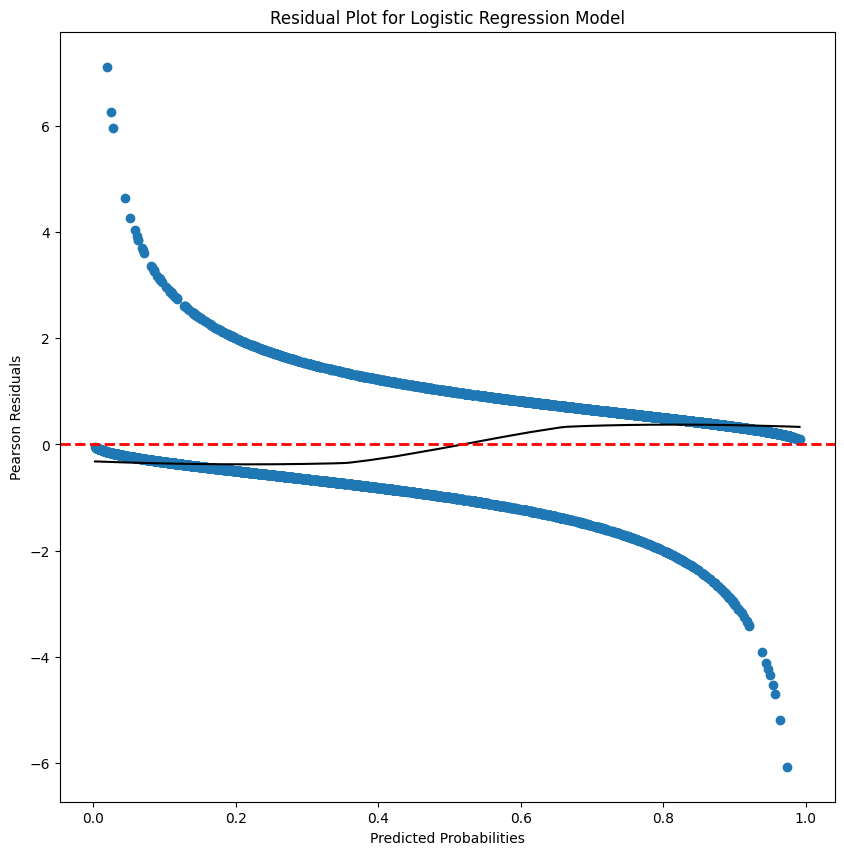

In [514]:
# residual plot
predicted_probabilities = model.predict(X)
pearson_residuals = model.resid_pearson

fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(predicted_probabilities, pearson_residuals)
ax.set_xlabel("Predicted Probabilities")
ax.set_ylabel("Pearson Residuals")

# LOWESS smoothing
smoothed = sm.nonparametric.lowess(
    pearson_residuals, predicted_probabilities
)
abs_smoothed_values = np.abs(smoothed[:, 1])
ax.plot(smoothed[:, 0], smoothed[:, 1], color="black")

plt.axhline(y=0, color="red", linestyle="--", linewidth=2)
plt.title("Residual Plot for Logistic Regression Model")
plt.show()

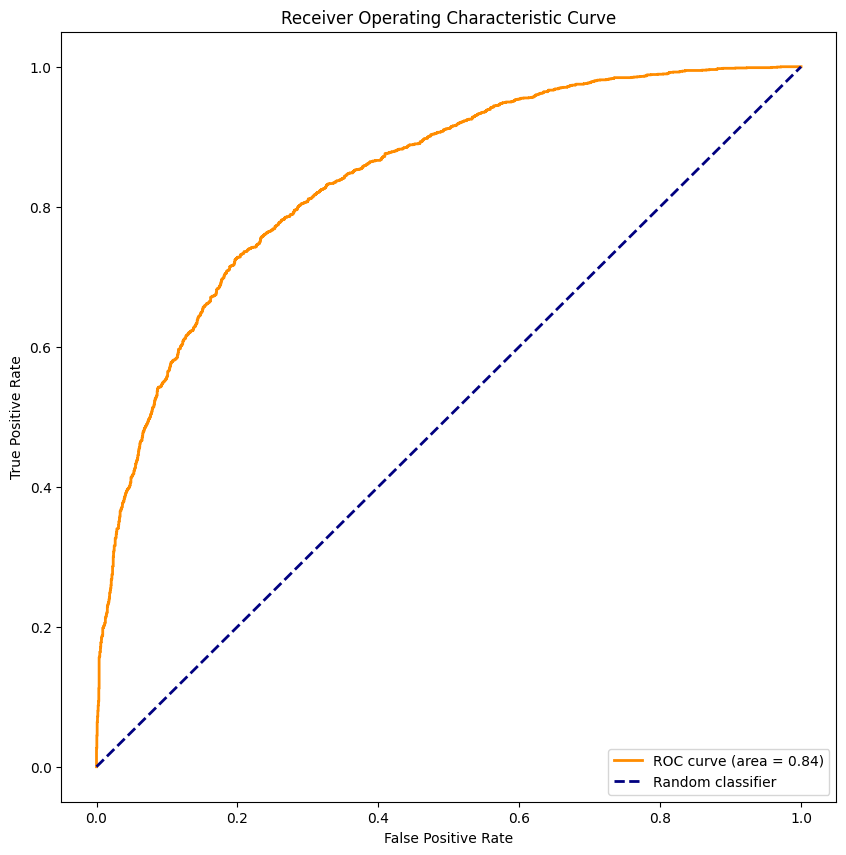

In [515]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(Y, predicted_probabilities)

# Compute AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot ROC curve

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, label="Random classifier", linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc='lower right')
plt.show()

In [516]:
# Calculate predictions
game_data["predictions"] = model.predict(X)

# Binning the data into deciles
game_data["decile"] = pd.qcut(game_data["predictions"], 10, labels=False)

# Calculating observed and expected frequencies
# game_data["result"] = game_data["result"].astype("int")
observed = game_data.groupby("decile")["result"].sum()
total = game_data.groupby("decile")["result"].count()
expected = total * game_data.groupby("decile")["predictions"].mean()

# Calculating the Hosmer-Lemeshow statistic
chi_squared = ((observed - expected) ** 2 / expected).sum()
degrees_of_freedom = 8  # 10 deciles - 2
p_value = stats.chi2.sf(chi_squared, degrees_of_freedom)

print("Hosmer-Lemeshow test statistic: ", chi_squared)
print("Degrees of freedom: ", degrees_of_freedom)
print("P-value: ", p_value)

Hosmer-Lemeshow test statistic:  4.858590720527118
Degrees of freedom:  8
P-value:  0.7725777443477942


### Forward selection

In [517]:
def forward_selection_with_interactions(data, response):
    """
    Perform forward selection with interactions and return the model with the lowest AIC
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    aic_values = []
    current_score, best_new_score = float("inf"), float("inf")

    while remaining and current_score == best_new_score:
        scores_with_candidates = []

        # Evaluate adding each remaining predictor
        for candidate in remaining:
            formula = "{} ~ {}".format(
                response, " + ".join(selected + [candidate])
            )
            score = sm.Logit.from_formula(formula, data).fit(disp=0).aic
            scores_with_candidates.append((score, candidate, ""))

        # Evaluate adding interactions between selected predictors and each remaining predictor
        for candidate in remaining:
            for feature in selected:
                interaction_term = f"{candidate}:{feature}"
                formula = "{} ~ {} + {}".format(
                    response,
                    " + ".join(selected + [candidate]),
                    interaction_term,
                )
                score = sm.Logit.from_formula(formula, data).fit(disp=0).aic
                scores_with_candidates.append(
                    (score, candidate, interaction_term)
                )

        # Choose the best candidate to add
        scores_with_candidates.sort()
        (
            best_new_score,
            best_candidate,
            interaction,
        ) = scores_with_candidates.pop(0)
        if current_score > best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            if interaction:
                selected.append(interaction)
            current_score = best_new_score
            aic_values.append(current_score)

    formula = "{} ~ {}".format(response, " + ".join(selected))
    model = sm.Logit.from_formula(formula, data).fit(disp=0)
    return model, selected, aic_values

### Testing model with heroes and interactions

(1647, 11) (1615, 11)


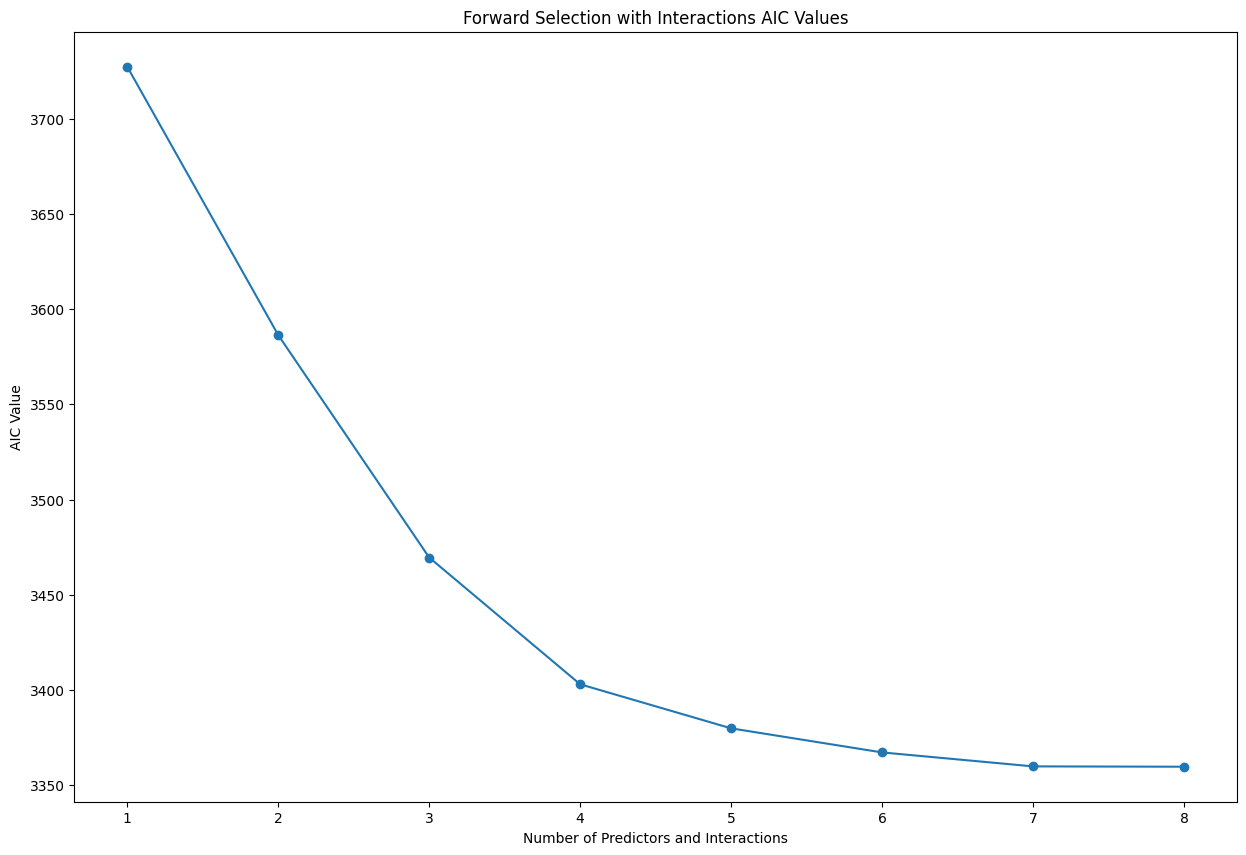

                           Logit Regression Results                           
Dep. Variable:                 result   No. Observations:                 3262
Model:                          Logit   Df Residuals:                     3250
Method:                           MLE   Df Model:                           11
Date:                Fri, 08 Dec 2023   Pseudo R-squ.:                  0.2623
Time:                        08:49:28   Log-Likelihood:                -1667.8
converged:                       True   LL-Null:                       -2260.9
Covariance Type:            nonrobust   LLR p-value:                1.522e-247
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                 -8.2929      0.964     -8.605      0.000     -10.182      -6.404
towers_lost_20                            -0.21

In [518]:
winner_copy, loser_copy = load_data(
    time=analysis_time,
    hero_count=hero_limit,
    include_result=True,
    include_heroes=True,
    player_params=["networth"],
)

game_data = pd.concat([winner_copy, loser_copy], axis=0)
response = "result"

model, selected_predictors, aic_values = forward_selection_with_interactions(
    game_data, "result"
)

# Plotting the AIC values
plt.figure(figsize=(15, 10))
plt.plot(range(1, len(aic_values) + 1), aic_values, marker="o")
plt.xlabel("Number of Predictors and Interactions")
plt.ylabel("AIC Value")
plt.title("Forward Selection with Interactions AIC Values")
plt.show()

# Printing the summary of the selected model
print(model.summary())

### Testing model without heroes, with interactions

(1436, 16) (1412, 16)


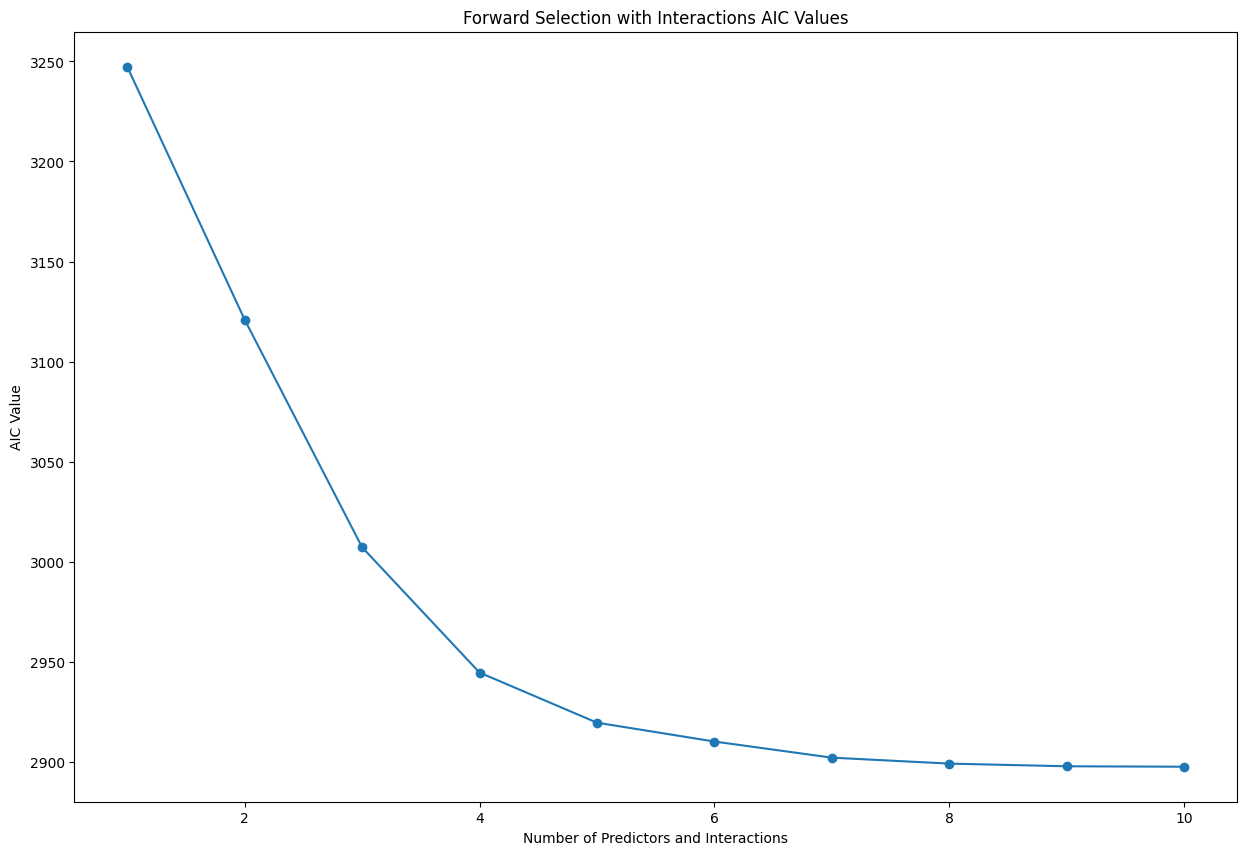

                           Logit Regression Results                           
Dep. Variable:                 result   No. Observations:                 2848
Model:                          Logit   Df Residuals:                     2831
Method:                           MLE   Df Model:                           16
Date:                Fri, 08 Dec 2023   Pseudo R-squ.:                  0.2747
Time:                        08:50:48   Log-Likelihood:                -1431.7
converged:                       True   LL-Null:                       -1974.0
Covariance Type:            nonrobust   LLR p-value:                8.720e-221
                                                                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------
Intercept                                                       -8.9478      1.458     -6.137      0.000     -

In [519]:
winner_copy, loser_copy = load_data(
    time=analysis_time,
    hero_count=hero_limit,
    include_result=True,
    player_params=["networth", "hero_damage", "camps_stacked"],
)

game_data = pd.concat([winner_copy, loser_copy], axis=0)
response = "result"

model, selected_predictors, aic_values = forward_selection_with_interactions(
    game_data, "result"
)

# Plotting the AIC values
plt.figure(figsize=(15, 10))
plt.plot(range(1, len(aic_values) + 1), aic_values, marker="o")
plt.xlabel("Number of Predictors and Interactions")
plt.ylabel("AIC Value")
plt.title("Forward Selection with Interactions AIC Values")
plt.show()

# Printing the summary of the selected model
print(model.summary())